# CRAWL DATA

In [1]:
import requests
import pandas as pd
import time
import os
from datetime import datetime
import json

class NASAPowerCrawlerCitySimplified:
    """
    Class để crawl dữ liệu từ NASA POWER API cho toàn thành phố TP.HCM
    Version đơn giản với 20 parameters - crawl 1 lần duy nhất
    """

    def __init__(self):
        self.base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"

        self.parameters = [
            "PRECTOTCORR",           # Precipitation
            "QV2M",                  # Specific Humidity at 2 Meters
            "RH2M",                  # Relative Humidity at 2 Meters
            "T2M",                   # Temperature at 2 Meters
            "T2MDEW",                # Dew/Frost Point at 2 Meters
            "T2MWET",                # Wet Bulb Temperature at 2 Meters
            "T2M_MAX",               # Temperature at 2 Meters Maximum
            "TS",                    # Earth Skin Temperature
            "T2M_MIN",               # Temperature at 2 Meters Minimum
            "ALLSKY_SFC_LW_DWN",     # All Sky Surface Longwave Downward Irradiance
            "PS",                    # Surface Pressure
            "WS10M",                 # Wind Speed at 10 Meters
            "WD10M",                 # Wind Direction at 10 Meters
            "WS10M_MAX",             # Wind Speed at 10 Meters Maximum
            'WS2M_MAX',              # Wind Speed at 2 Meters Maximum
            'WS2M',                  # Wind Speed at 2 Meters
            'WD2M',                  # Wind Direction at 2 Meters
            "GWETPROF",              # Profile Soil Moisture
            "GWETTOP",               # Surface Soil Wetness
            "GWETROOT"               # Root Zone Soil Wetness
        ]

        # Tọa độ trung tâm TP.HCM
        self.hcmc_center = {
            "lat": 10.78,  # Trung tâm TP.HCM (chính xác hơn)
            "lon": 106.7
        }

        # Tạo thư mục lưu dữ liệu
        self.output_dir = "nasa_power_hcmc_data"
        os.makedirs(self.output_dir, exist_ok=True)

    def crawl_data(self, start_date, end_date):
        """
        Crawl tất cả dữ liệu trong 1 lần duy nhất

        Args:
            start_date: Ngày bắt đầu YYYYMMDD
            end_date: Ngày kết thúc YYYYMMDD
        """
        print("🚀 BẮT ĐẦU CRAWL DỮ LIỆU CHO TP.HỒ CHÍ MINH")
        print("="*80)
        print(f"📅 Thời gian: {start_date} → {end_date}")
        print(f"📊 Tổng số parameters: {len(self.parameters)}")
        print(f"📍 Vị trí: lat={self.hcmc_center['lat']}, lon={self.hcmc_center['lon']}")

        # Validate số lượng parameters
        if len(self.parameters) > 20:
            print(f"⚠️ CẢNH BÁO: {len(self.parameters)} parameters vượt quá giới hạn API (20)")
            return None

        # Setup request parameters
        params = {
            "parameters": ",".join(self.parameters),
            "community": "RE",
            "longitude": self.hcmc_center["lon"],
            "latitude": self.hcmc_center["lat"],
            "start": start_date,
            "end": end_date,
            "format": "JSON"
        }

        print(f"\n🌍 Đang crawl dữ liệu từ NASA POWER API...")
        print(f"   📊 Parameters: {len(self.parameters)} indicators")

        try:
            # Make API request
            response = requests.get(self.base_url, params=params, timeout=120)
            response.raise_for_status()

            data = response.json()

            # Kiểm tra lỗi API
            if "messages" in data and data["messages"]:
                print(f"   ❌ Lỗi API: {data['messages']}")
                return None

            # Parse JSON data
            properties = data.get("properties", {})
            parameters_data = properties.get("parameter", {})

            if not parameters_data:
                print(f"   ❌ Không có dữ liệu được trả về")
                return None

            # Tạo DataFrame từ JSON data
            df_dict = {}
            for param, values in parameters_data.items():
                df_dict[param] = values

            df = pd.DataFrame(df_dict)

            # Thêm metadata columns
            df["DATE"] = pd.to_datetime(df.index)
            df["LATITUDE"] = self.hcmc_center["lat"]
            df["LONGITUDE"] = self.hcmc_center["lon"]

            print(f"   ✅ Crawl thành công: {df.shape[0]:,} days × {df.shape[1]} columns")

            # Lưu dataset
            saved_df = self.save_dataset(df, start_date, end_date)

            return saved_df

        except requests.exceptions.RequestException as e:
            print(f"   ❌ Lỗi network request: {str(e)}")
            return None
        except Exception as e:
            print(f"   ❌ Lỗi xử lý dữ liệu: {str(e)}")
            return None

    def save_dataset(self, df, start_date, end_date):
        """
        Lưu dataset và tạo báo cáo tóm tắt
        """
        try:
            # Tạo tên file
            output_filename = f"hcmc_weather_data_{start_date}_{end_date}.csv"
            output_filepath = os.path.join(self.output_dir, output_filename)

            # Lưu CSV file
            df.to_csv(output_filepath, index=False, encoding='utf-8')

            print(f"\n💾 ĐÃ LƯU DATASET THÀNH CÔNG!")
            print(f"   📁 File: {output_filename}")
            print(f"   📂 Path: {output_filepath}")
            print(f"   📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
            print(f"   📅 Date range: {df['DATE'].min()} → {df['DATE'].max()}")

            # Tạo báo cáo chi tiết
            self.generate_data_summary(df)

            return df

        except Exception as e:
            print(f"   ❌ Lỗi khi lưu dataset: {str(e)}")
            return None

    def generate_data_summary(self, df):
        """
        Tạo báo cáo tóm tắt chi tiết về dữ liệu
        """
        print("\n📋 BÁO CÁO TÓM TẮT DỮ LIỆU WEATHER TP.HCM")
        print("="*60)

        # Basic info
        print(f"📊 Kích thước dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"📅 Khoảng thời gian: {df['DATE'].min().strftime('%Y-%m-%d')} → {df['DATE'].max().strftime('%Y-%m-%d')}")
        print(f"📈 Số ngày dữ liệu: {df['DATE'].nunique():,} days")

        # Tính số năm
        years = (df['DATE'].max() - df['DATE'].min()).days / 365.25
        print(f"⏱️ Tổng thời gian: {years:.1f} năm")

        # Weather parameters info
        weather_params = [col for col in df.columns if col not in ['DATE', 'LATITUDE', 'LONGITUDE']]
        print(f"🌤️ Số weather parameters: {len(weather_params)}")

        print(f"\n📋 Danh sách parameters:")
        for i, param in enumerate(weather_params, 1):
            print(f"   {i:2d}. {param}")

        # Data quality checks
        print(f"\n🔍 KIỂM TRA CHẤT LƯỢNG DỮ LIỆU:")

        # Missing values
        missing_info = df.isnull().sum()
        missing_cols = missing_info[missing_info > 0]

        if len(missing_cols) > 0:
            print(f"⚠️ Missing values tìm thấy:")
            for col, count in missing_cols.items():
                pct = (count / len(df)) * 100
                print(f"   - {col}: {count:,} ({pct:.1f}%)")
        else:
            print(f"✅ Không có missing values")

        # Check for -999 (NASA missing indicator)
        print(f"\n🔍 Kiểm tra giá trị -999 (NASA missing indicator):")
        has_999 = False
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

        for col in numeric_cols:
            count_999 = (df[col] == -999).sum()
            if count_999 > 0:
                pct = (count_999 / len(df)) * 100
                print(f"   ⚠️ {col}: {count_999:,} values = -999 ({pct:.1f}%)")
                has_999 = True

        if not has_999:
            print(f"✅ Không có giá trị -999")

    def validate_parameters(self):
        """
        Validate danh sách parameters
        """
        print("🔍 VALIDATION PARAMETERS:")
        print(f"   📊 Tổng số: {len(self.parameters)}")

        print(f"\n📋 Danh sách parameters sẽ crawl:")
        for i, param in enumerate(self.parameters, 1):
            print(f"   {i:2d}. {param}")

        return len(self.parameters) <= 20

def main():
    """
    Hàm chính để thực hiện crawl dữ liệu
    """
    print("🌟 NASA POWER WEATHER DATA CRAWLER FOR HO CHI MINH CITY")
    print("🔄 SIMPLIFIED VERSION - SINGLE REQUEST")
    print("="*80)

    # Khởi tạo crawler
    crawler = NASAPowerCrawlerCitySimplified()

    # Validate parameters trước khi crawl
    if not crawler.validate_parameters():
        print("❌ Parameters validation failed!")
        return None

    # Định nghĩa khoảng thời gian
    start_date_str = "20000101"  # 1/1/2000
    end_date_str = "20250430"    # 30/04/2025

    print(f"\n🎯 Mục tiêu: Dự đoán thời tiết toàn TP.HCM")
    print(f"📍 Vị trí: Trung tâm TP.HCM")
    print(f"⚠️ Đã loại bỏ 2 chỉ số bức xạ: ALLSKY_SFC_SW_DWN, TOA_SW_DWN")

    # Thực hiện crawl
    final_dataset = crawler.crawl_data(start_date_str, end_date_str)

    if final_dataset is not None:
        print("\n🎉 HOÀN TẤT CRAWL DỮ LIỆU THÀNH CÔNG!")
        print("="*80)
        print(f"✨ Dataset sẵn sàng cho EDA và modeling")
        print(f"📄 File đã lưu trong thư mục: {crawler.output_dir}")
        return final_dataset
    else:
        print("\n❌ CRAWL DỮ LIỆU THẤT BẠI!")
        return None

# Chạy crawler
if __name__ == "__main__":
    final_dataset = main()
    if final_dataset is not None:
        print(f"\n🎯 Sử dụng biến 'final_dataset' để truy cập dữ liệu")
        print(f"📊 Shape: {final_dataset.shape}")
    print("Hoàn tất quá trình crawl dữ liệu")

🌟 NASA POWER WEATHER DATA CRAWLER FOR HO CHI MINH CITY
🔄 SIMPLIFIED VERSION - SINGLE REQUEST
🔍 VALIDATION PARAMETERS:
   📊 Tổng số: 20

📋 Danh sách parameters sẽ crawl:
    1. PRECTOTCORR
    2. QV2M
    3. RH2M
    4. T2M
    5. T2MDEW
    6. T2MWET
    7. T2M_MAX
    8. TS
    9. T2M_MIN
   10. ALLSKY_SFC_LW_DWN
   11. PS
   12. WS10M
   13. WD10M
   14. WS10M_MAX
   15. WS2M_MAX
   16. WS2M
   17. WD2M
   18. GWETPROF
   19. GWETTOP
   20. GWETROOT

🎯 Mục tiêu: Dự đoán thời tiết toàn TP.HCM
📍 Vị trí: Trung tâm TP.HCM
⚠️ Đã loại bỏ 2 chỉ số bức xạ: ALLSKY_SFC_SW_DWN, TOA_SW_DWN
🚀 BẮT ĐẦU CRAWL DỮ LIỆU CHO TP.HỒ CHÍ MINH
📅 Thời gian: 20000101 → 20250430
📊 Tổng số parameters: 20
📍 Vị trí: lat=10.78, lon=106.7

🌍 Đang crawl dữ liệu từ NASA POWER API...
   📊 Parameters: 20 indicators
   ✅ Crawl thành công: 9,252 days × 23 columns

💾 ĐÃ LƯU DATASET THÀNH CÔNG!
   📁 File: hcmc_weather_data_20000101_20250430.csv
   📂 Path: nasa_power_hcmc_data\hcmc_weather_data_20000101_20250430.csv
   📊 Sh

# Thông tin bộ dữ liệu

**Dữ liệu NASA POWER API cho Thành phố Hồ Chí Minh**

**a) Chức năng (nội dung) của bộ dữ liệu là gì?**

Bộ dữ liệu này chứa thông tin khí tượng và bề mặt đất hàng ngày cho Thành phố Hồ Chí Minh, được thu thập tự động thông qua API NASA Prediction Of Worldwide Energy Resources (POWER). Dữ liệu bao gồm nhiều tham số quan trọng như:

*   **Nhiệt độ**: trung bình, tối thiểu, tối đa, điểm sương, bầu ướt, nhiệt độ bề mặt đất
*   **Độ ẩm**: tương đối, tuyệt đối  
*   **Lượng mưa**: mục tiêu dự đoán chính
*   **Áp suất bề mặt**
*   **Gió**: tốc độ trung bình, tối đa, hướng gió ở các độ cao khác nhau
*   **Bức xạ mặt trời**: bức xạ sóng dài xuống bề mặt
*   **Độ ẩm đất**: bề mặt, vùng rễ, toàn bộ mặt cắt

Dữ liệu được cung cấp cho mỗi ngày trong khoảng thời gian được chỉ định từ 01/01/2000 đến 30/04/2025, phục vụ mục tiêu dự đoán thời tiết cho toàn thành phố.

**b) Nguồn gốc của bộ dữ liệu?**

Dữ liệu gốc được cung cấp bởi dự án NASA POWER. Dữ liệu cụ thể trong bộ dữ liệu này được thu thập bằng cách gọi đến API công khai của NASA POWER:

*   **Nguồn dữ liệu:** NASA POWER (Prediction Of Worldwide Energy Resources)
*   **API Endpoint:** `https://power.larc.nasa.gov/api/temporal/daily/point`
*   **Phương pháp:** Single request crawl với 20 parameters (trong giới hạn API)
*   **Vị trí:** Tọa độ trung tâm TP.HCM (lat: 10.78, lon: 106.7)

**c) Cấu trúc các tập tin của bộ dữ liệu? Ý nghĩa từng tập tin.**

Dữ liệu sau khi thu thập được lưu trữ trong thư mục `nasa_power_hcmc_data` với cấu trúc đơn giản:

1.  **Tệp dữ liệu chính:**
    *   **Tên tệp:** `hcmc_weather_data_{Ngày_Bắt_Đầu}_{Ngày_Kết_Thúc}.csv`
    *   **Nội dung:** Chứa dữ liệu hàng ngày của tất cả 20 tham số khí tượng cho TP.HCM trong khoảng thời gian xác định. Mỗi hàng đại diện cho một ngày.

**d) Các thông tin nào mà các record (bản ghi) lưu trữ?**

Mỗi record (hàng trong tệp CSV) tương ứng với dữ liệu của một ngày cho TP.HCM và chứa các cột sau:

**Thông tin địa lý và thời gian:**
*   **DATE:** Ngày ghi nhận dữ liệu (định dạng datetime)
*   **LATITUDE:** Vĩ độ điểm đại diện TP.HCM (10.78)
*   **LONGITUDE:** Kinh độ điểm đại diện TP.HCM (106.7)

**Nhóm 1 - Nhiệt độ, độ ẩm, mưa, áp suất (11 chỉ số):**
*   **PRECTOTCORR:** Lượng mưa đã hiệu chỉnh (mm/ngày) - *Biến mục tiêu*
*   **QV2M:** Độ ẩm tuyệt đối ở 2m (g/kg)
*   **RH2M:** Độ ẩm tương đối ở 2m (%)
*   **T2M:** Nhiệt độ trung bình ở 2m (°C)
*   **T2MDEW:** Điểm sương/sương giá ở 2m (°C)
*   **T2MWET:** Nhiệt độ bầu ướt ở 2m (°C)
*   **T2M_MAX:** Nhiệt độ tối đa ở 2m (°C)
*   **TS:** Nhiệt độ bề mặt đất (°C)
*   **T2M_MIN:** Nhiệt độ tối thiểu ở 2m (°C)
*   **ALLSKY_SFC_LW_DWN:** Bức xạ sóng dài xuống bề mặt (MJ/m²/ngày)
*   **PS:** Áp suất bề mặt (kPa)

**Nhóm 2 - Gió và độ ẩm đất (9 chỉ số):**
*   **WS10M:** Tốc độ gió ở 10m (m/s)
*   **WD10M:** Hướng gió ở 10m (Độ)
*   **WS10M_MAX:** Tốc độ gió tối đa ở 10m (m/s)
*   **WS2M_MAX:** Tốc độ gió tối đa ở 2m (m/s)
*   **WS2M:** Tốc độ gió ở 2m (m/s)
*   **WD2M:** Hướng gió ở 2m (Độ)
*   **GWETPROF:** Độ ẩm đất theo mặt cắt (tỷ lệ 0-1)
*   **GWETTOP:** Độ ẩm bề mặt đất (tỷ lệ 0-1)
*   **GWETROOT:** Độ ẩm vùng rễ (tỷ lệ 0-1)

**Ghi chú quan trọng:**
- Giá trị `-999` biểu thị dữ liệu thiếu hoặc không thể tính toán
- Dữ liệu được crawl trong 1 lần duy nhất với 20 parameters (tuân thủ giới hạn API)
- Tổng cộng có 20 weather parameters + 3 metadata columns cho việc dự đoán thời tiết TP.HCM

### Tham khảo

*   **NASA POWER Data Access Viewer:** [https://power.larc.nasa.gov/data-access-viewer/](https://power.larc.nasa.gov/data-access-viewer/)
*   **NASA POWER Documentation:** [https://power.larc.nasa.gov/docs/](https://power.larc.nasa.gov/docs/)
*   **NASA POWER API Documentation:** [https://power.larc.nasa.gov/docs/services/api/](https://power.larc.nasa.gov/docs/services/api/)

In [2]:
data_dir = "nasa_power_hcmc_data"
start_date_str = "20000101"  # 1/1/2000
end_date_str = "20250430"    # 30/04/2025

import pandas as pd
import numpy as np
import os
from datetime import datetime

# --- 1. Rename Columns (Vietnamese Standard) ---
column_mapping = {
    "PRECTOTCORR": "Lượng mưa",           # Precipitation
    "QV2M": "Độ ẩm tuyệt đối 2m",                  # Specific Humidity at 2 Meters
    "RH2M": "Độ ẩm tương đối 2m",                  # Relative Humidity at 2 Meters
    "T2M": "Nhiệt độ 2m",                   # Temperature at 2 Meters
    "T2MDEW": "Điểm sương 2m",                # Dew/Frost Point at 2 Meters
    "T2MWET": "Nhiệt độ bầu ướt 2m",                # Wet Bulb Temperature at 2 Meters
    "T2M_MAX": "Nhiệt độ tối đa 2m",               # Temperature at 2 Meters Maximum
    "TS": "Nhiệt độ bề mặt đất",                    # Earth Skin Temperature
    "T2M_MIN": "Nhiệt độ tối thiểu 2m",               # Temperature at 2 Meters Minimum
    "ALLSKY_SFC_LW_DWN": "Bức xạ sóng dài xuống",     # All Sky Surface Longwave Downward Irradiance
    "PS": "Áp suất bề mặt",                    # Surface Pressure
    "WS10M": "Tốc độ gió 10m",                 # Wind Speed at 10 Meters
    "WD10M": "Hướng gió 10m",                 # Wind Direction at 10 Meters
    "WS10M_MAX": "Tốc độ gió tối đa 10m",             # Wind Speed at 10 Meters Maximum
    'WS2M_MAX': "Tốc độ gió tối đa 2m",              # MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
    'WS2M': "Tốc độ gió 2m",                  # MERRA-2 Wind Speed at 2 Meters (m/s)
    'WD2M': "Hướng gió 2m",                  # MERRA-2 Wind Direction at 2 Meters (Degrees)
    "GWETPROF": "Độ ẩm đất mặt cắt",              # Profile Soil Moisture (surface to bedrock)
    "GWETTOP": "Độ ẩm đất bề mặt",               # Surface Soil Wetness (surface to 5 cm below)
    "GWETROOT": "Độ ẩm đất vùng rễ",               # Root Zone Soil Wetness (surface to 100 cm below)
    # Cột thông tin
    "DATE": "Ngày",
    "LATITUDE": "Vĩ độ",
    "LONGITUDE": "Kinh độ",
}


# --- 2. Load Data ---
hcmc_complete_file_path = os.path.join(data_dir, f"hcmc_weather_data_{start_date_str}_{end_date_str}.csv")

print("🌟 LOADING WEATHER DATA FOR HO CHI MINH CITY")
print("="*60)

# Load dữ liệu hoàn chỉnh cho TP.HCM
if final_dataset is None:
  try:
      df_all = pd.read_csv(hcmc_complete_file)
      print(f"✅ Đã tải thành công file: {os.path.basename(hcmc_complete_file)}")
      print(f"📊 Kích thước ban đầu: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")

      # Rename columns
      original_columns = len(df_all.columns)
      df_all.rename(columns=column_mapping, inplace=True)
      print(f"📝 Đã đổi tên {original_columns} cột sang tiếng Việt")

  except FileNotFoundError:
      print(f"❌ Lỗi: Không tìm thấy file '{hcmc_complete_file}'")
      print(f"💡 Vui lòng chạy crawler trước để tạo dữ liệu!")
      df_all = None
  except Exception as e:
      print(f"❌ Lỗi khi tải file '{hcmc_complete_file}': {e}")
      df_all = None
else:
  df_all = final_dataset
  original_columns = len(df_all.columns)
  df_all.rename(columns=column_mapping, inplace=True)

if df_all is not None:
    # --- 3. Check Basic Info ---
    print("\n📋 THÔNG TIN CƠ BẢN CỦA DỮ LIỆU TP.HCM")
    print("="*60)

    print("\n1. 📏 Kích thước (Shape):")
    print(f"   {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")

    print("\n2. 📊 Thông tin biến (Info):")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        df_all.info(verbose=True, show_counts=True)

    print("\n3. 📈 Thống kê mô tả (Describe):")
    numeric_cols = df_all.select_dtypes(include=[np.number]).columns
    print(f"   Hiển thị thống kê cho {len(numeric_cols)} cột số:")
    print(df_all[numeric_cols].describe().T)

    # --- 4. Correct Date Format ---
    print("\n📅 CHỈNH SỬA ĐỊNH DẠNG NGÀY")
    print("="*40)

    def correct_date_format(df, date_column='Ngày'):
        """Converts a date column to datetime objects."""
        if date_column in df.columns:
            # Check if already datetime
            if pd.api.types.is_datetime64_any_dtype(df[date_column]):
                print(f"✅ Cột '{date_column}' đã ở định dạng datetime")
                return df
            try:
                # Try different date formats
                if df[date_column].dtype == 'object':
                    # If string, try to parse
                    df[date_column] = pd.to_datetime(df[date_column])
                else:
                    # If numeric (YYYYMMDD), convert to string first
                    df[date_column] = df[date_column].astype(str)
                    df[date_column] = pd.to_datetime(df[date_column], format='%Y%m%d')

                print(f"✅ Đã chuyển đổi cột '{date_column}' sang datetime")
                print(f"   📅 Khoảng thời gian: {df[date_column].min()} → {df[date_column].max()}")
                print(f"   📊 Số ngày dữ liệu: {df[date_column].nunique():,} days")

            except Exception as e:
                print(f"❌ Lỗi khi chuyển đổi cột '{date_column}': {e}")
                print("💡 Kiểm tra lại định dạng dữ liệu trong file CSV")
        else:
            print(f"⚠️ Không tìm thấy cột '{date_column}' để chuyển đổi")
        return df

    df_all = correct_date_format(df_all)

    print(f"📊 Tổng số weather parameters: {len([col for col in df_all.columns if col not in ['Ngày', 'Vĩ độ', 'Kinh độ', 'Nhóm']])}")

else:
    print("\n❌ Không thể load dữ liệu. Vui lòng kiểm tra lại!")

🌟 LOADING WEATHER DATA FOR HO CHI MINH CITY

📋 THÔNG TIN CƠ BẢN CỦA DỮ LIỆU TP.HCM

1. 📏 Kích thước (Shape):
   9,252 rows × 23 columns

2. 📊 Thông tin biến (Info):
<class 'pandas.core.frame.DataFrame'>
Index: 9252 entries, 20000101 to 20250430
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Lượng mưa              9252 non-null   float64       
 1   Độ ẩm tuyệt đối 2m     9252 non-null   float64       
 2   Độ ẩm tương đối 2m     9252 non-null   float64       
 3   Nhiệt độ 2m            9252 non-null   float64       
 4   Điểm sương 2m          9252 non-null   float64       
 5   Nhiệt độ bầu ướt 2m    9252 non-null   float64       
 6   Nhiệt độ tối đa 2m     9252 non-null   float64       
 7   Nhiệt độ bề mặt đất    9252 non-null   float64       
 8   Nhiệt độ tối thiểu 2m  9252 non-null   float64       
 9   Bức xạ sóng dài xuống  9252 non-null   float64       
 10  Áp suất b

# Data Quality Assessment

In [3]:
# -*- coding: utf-8 -*-
"""
Data Quality Assessment Module for Weather Time Series Data
Purpose: Comprehensive data quality evaluation for precipitation prediction project
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class DataQualityAssessment:
    """
    Comprehensive Data Quality Assessment for Weather Data
    """

    def __init__(self, df, target_col='Lượng mưa', date_col='Ngày'):
        """
        Initialize Data Quality Assessment

        Args:
            df: DataFrame to assess
            target_col: Target variable column name
            date_col: Date column name
        """
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        self.n_rows = len(self.df)
        self.n_cols = len(self.df.columns)

        print("🔍 DATA QUALITY ASSESSMENT INITIALIZED")
        print("="*60)
        print(f"📊 Dataset Overview:")
        print(f"   - Shape: {self.df.shape}")
        print(f"   - Target Variable: {self.target_col}")
        print(f"   - Date Column: {self.date_col}")
        print(f"   - Memory Usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    def basic_info_analysis(self):
        """
        1. Phân tích thông tin cơ bản về dataset
        """
        print("\n" + "="*60)
        print("📋 1. BASIC DATASET INFORMATION")
        print("="*60)

        # Dataset shape and size
        print(f"📏 Kích thước Dataset:")
        print(f"   - Số dòng (observations): {self.n_rows:,}")
        print(f"   - Số cột (variables): {self.n_cols}")
        print(f"   - Tổng ô dữ liệu: {self.n_rows * self.n_cols:,}")

        # Data types analysis
        print(f"\n📊 Phân tích kiểu dữ liệu:")
        dtype_counts = self.df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"   - {dtype}: {count} columns ({count/self.n_cols*100:.1f}%)")

        # Column categories
        self.numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        self.datetime_cols = self.df.select_dtypes(include=['datetime64']).columns.tolist()

        print(f"\n📂 Phân loại cột:")
        print(f"   - Numerical columns: {len(self.numerical_cols)}")
        print(f"   - Categorical columns: {len(self.categorical_cols)}")
        print(f"   - Datetime columns: {len(self.datetime_cols)}")

        return {
            'shape': self.df.shape,
            'memory_usage_mb': self.df.memory_usage(deep=True).sum() / 1024**2,
            'dtype_counts': dtype_counts,
            'column_categories': {
                'numerical': self.numerical_cols,
                'categorical': self.categorical_cols,
                'datetime': self.datetime_cols
            }
        }

    def missing_values_analysis(self):
        """
        2. Phân tích chi tiết về missing values
        """
        print("\n" + "="*60)
        print("❓ 2. MISSING VALUES ANALYSIS")
        print("="*60)

        # Calculate missing values for each column
        missing_data = []
        for col in self.df.columns:
            missing_count = self.df[col].isnull().sum()
            missing_percentage = (missing_count / self.n_rows) * 100
            non_null_count = self.df[col].notna().sum()
            unique_count = self.df[col].nunique()

            missing_data.append({
                'Column': col,
                'Missing_Count': missing_count,
                'Missing_Percentage': missing_percentage,
                'Non_Null_Count': non_null_count,
                'Unique_Values': unique_count,
                'Data_Type': str(self.df[col].dtype)
            })

        missing_df = pd.DataFrame(missing_data)
        missing_df = missing_df.sort_values('Missing_Percentage', ascending=False)

        # Overall missing data statistics
        total_missing = self.df.isnull().sum().sum()
        total_cells = self.n_rows * self.n_cols
        overall_missing_pct = (total_missing / total_cells) * 100

        print(f"📊 Tổng quan Missing Data:")
        print(f"   - Tổng số ô thiếu dữ liệu: {total_missing:,}")
        print(f"   - Tỷ lệ thiếu dữ liệu tổng thể: {overall_missing_pct:.2f}%")

        # Columns with missing data
        cols_with_missing = missing_df[missing_df['Missing_Count'] > 0]

        # Initialize empty DataFrames to avoid UnboundLocalError
        high_missing = pd.DataFrame()
        medium_missing = pd.DataFrame()
        low_missing = pd.DataFrame()

        if len(cols_with_missing) > 0:
            print(f"\n🚨 Các cột có dữ liệu thiếu ({len(cols_with_missing)} cột):")
            print(cols_with_missing[['Column', 'Missing_Count', 'Missing_Percentage', 'Data_Type']].to_string(index=False))

            # Categorize missing data severity
            high_missing = cols_with_missing[cols_with_missing['Missing_Percentage'] > 50]
            medium_missing = cols_with_missing[(cols_with_missing['Missing_Percentage'] > 10) &
                                             (cols_with_missing['Missing_Percentage'] <= 50)]
            low_missing = cols_with_missing[cols_with_missing['Missing_Percentage'] <= 10]

            print(f"\n📋 Phân loại mức độ thiếu dữ liệu:")
            print(f"   - Thiếu nghiêm trọng (>50%): {len(high_missing)} cột")
            print(f"   - Thiếu trung bình (10-50%): {len(medium_missing)} cột")
            print(f"   - Thiếu ít (<10%): {len(low_missing)} cột")

            if len(high_missing) > 0:
                print(f"   ⚠️ Cột thiếu nghiêm trọng: {high_missing['Column'].tolist()}")
        else:
            print("✅ Không có cột nào thiếu dữ liệu!")

        # Check target variable missing data
        if self.target_col in missing_df['Column'].values:
            target_missing = missing_df[missing_df['Column'] == self.target_col]['Missing_Percentage'].iloc[0]
            if target_missing > 0:
                print(f"\n🎯 Biến mục tiêu '{self.target_col}' thiếu {target_missing:.2f}% dữ liệu")
            else:
                print(f"\n✅ Biến mục tiêu '{self.target_col}' không thiếu dữ liệu")

        return missing_df, {
            'total_missing': total_missing,
            'overall_missing_pct': overall_missing_pct,
            'columns_with_missing': len(cols_with_missing),
            'high_missing_cols': high_missing['Column'].tolist() if len(high_missing) > 0 else [],
            'medium_missing_cols': medium_missing['Column'].tolist() if len(medium_missing) > 0 else [],
            'low_missing_cols': low_missing['Column'].tolist() if len(low_missing) > 0 else []
        }

    def duplicate_analysis(self):
        """
        3. Phân tích dữ liệu trùng lặp
        """
        print("\n" + "="*60)
        print("🔄 3. DUPLICATE DATA ANALYSIS")
        print("="*60)

        # Full row duplicates
        full_duplicates = self.df.duplicated().sum()
        full_duplicate_pct = (full_duplicates / self.n_rows) * 100

        print(f"📊 Dòng trùng lặp hoàn toàn:")
        print(f"   - Số dòng trùng lặp: {full_duplicates:,}")
        print(f"   - Tỷ lệ trùng lặp: {full_duplicate_pct:.2f}%")

        # Check for duplicates excluding certain columns (like ID columns)
        key_columns = [col for col in self.df.columns
                      if col not in ['Vĩ độ', 'Kinh độ']]  # Exclude coordinate columns

        key_duplicates = 0
        if len(key_columns) < len(self.df.columns):
            key_duplicates = self.df.duplicated(subset=key_columns).sum()
            key_duplicate_pct = (key_duplicates / self.n_rows) * 100

            print(f"\n📊 Dòng trùng lặp (loại trừ tọa độ):")
            print(f"   - Số dòng trùng lặp: {key_duplicates:,}")
            print(f"   - Tỷ lệ trùng lặp: {key_duplicate_pct:.2f}%")

        # Check for date + location duplicates (if applicable)
        date_location_duplicates = 0
        if self.date_col in self.df.columns and 'Quận Huyện' in self.df.columns:
            date_location_duplicates = self.df.duplicated(subset=[self.date_col, 'Quận Huyện']).sum()
            date_location_dup_pct = (date_location_duplicates / self.n_rows) * 100

            print(f"\n📊 Trùng lặp ngày + địa điểm:")
            print(f"   - Số dòng trùng lặp: {date_location_duplicates:,}")
            print(f"   - Tỷ lệ trùng lặp: {date_location_dup_pct:.2f}%")

            if date_location_duplicates > 0:
                print("   ⚠️ Có thể có dữ liệu đo đạc trùng lặp cho cùng ngày và địa điểm!")

        # Check for potential duplicate patterns in target variable
        if self.target_col in self.df.columns:
            target_value_counts = self.df[self.target_col].value_counts()
            most_common_value = target_value_counts.iloc[0]
            most_common_pct = (most_common_value / self.n_rows) * 100

            print(f"\n🎯 Phân tích giá trị trùng lặp của biến mục tiêu:")
            print(f"   - Giá trị phổ biến nhất: {target_value_counts.index[0]}")
            print(f"   - Số lần xuất hiện: {most_common_value:,} ({most_common_pct:.2f}%)")

            # Check for excessive zeros in precipitation data
            if target_value_counts.index[0] == 0:
                zero_pct = (target_value_counts.iloc[0] / self.n_rows) * 100
                print(f"   📊 Tỷ lệ ngày không mưa: {zero_pct:.2f}%")
                if zero_pct > 70:
                    print("   ⚠️ Tỷ lệ ngày không mưa rất cao - cần xem xét!")

        return {
            'full_duplicates': full_duplicates,
            'full_duplicate_pct': full_duplicate_pct,
            'key_duplicates': key_duplicates,
            'date_location_duplicates': date_location_duplicates
        }


    def data_consistency_check(self):
        """
        5. Kiểm tra tính nhất quán của dữ liệu
        """
        print("\n" + "="*60)
        print("🔍 4. DATA CONSISTENCY CHECK")
        print("="*60)

        consistency_issues = []

        # Check for negative values where they shouldn't exist
        weather_vars_positive = [
            'Lượng mưa', 'Độ ẩm tương đối 2m', 'Tốc độ gió 10m', 'Tốc độ gió 2m',
            'Tốc độ gió tối đa 10m', 'Tốc độ gió tối đa 2m'
        ]

        print("🔍 Kiểm tra giá trị âm cho các biến phải dương:")
        for col in weather_vars_positive:
            if col in self.df.columns:
                negative_count = (self.df[col] < 0).sum()
                if negative_count > 0:
                    negative_pct = (negative_count / len(self.df)) * 100
                    print(f"   ⚠️ {col}: {negative_count} giá trị âm ({negative_pct:.2f}%)")
                    consistency_issues.append(f"{col} has {negative_count} negative values")
                else:
                    print(f"   ✅ {col}: Không có giá trị âm")

        # Check humidity ranges (should be 0-100%)
        humidity_cols = ['Độ ẩm tương đối 2m']
        print(f"\n🔍 Kiểm tra phạm vi độ ẩm (0-100%):")
        for col in humidity_cols:
            if col in self.df.columns:
                data = self.df[col].dropna()
                out_of_range = data[(data < 0) | (data > 100)]
                if len(out_of_range) > 0:
                    print(f"   ⚠️ {col}: {len(out_of_range)} giá trị ngoài phạm vi [0,100]")
                    print(f"      - Min: {data.min():.2f}, Max: {data.max():.2f}")
                    consistency_issues.append(f"{col} has values outside [0,100] range")
                else:
                    print(f"   ✅ {col}: Tất cả giá trị trong phạm vi [0,100]")

        # Check wind direction ranges (should be 0-360 degrees)
        wind_direction_cols = ['Hướng gió 10m', 'Hướng gió 2m']
        print(f"\n🔍 Kiểm tra phạm vi hướng gió (0-360 độ):")
        for col in wind_direction_cols:
            if col in self.df.columns:
                data = self.df[col].dropna()
                out_of_range = data[(data < 0) | (data > 360)]
                if len(out_of_range) > 0:
                    print(f"   ⚠️ {col}: {len(out_of_range)} giá trị ngoài phạm vi [0,360]")
                    print(f"      - Min: {data.min():.2f}, Max: {data.max():.2f}")
                    consistency_issues.append(f"{col} has values outside [0,360] range")
                else:
                    print(f"   ✅ {col}: Tất cả giá trị trong phạm vi [0,360]")

        # Check temperature consistency (min <= avg <= max)
        temp_cols = {
            'min': 'Nhiệt độ tối thiểu 2m',
            'avg': 'Nhiệt độ 2m',
            'max': 'Nhiệt độ tối đa 2m'
        }

        if all(col in self.df.columns for col in temp_cols.values()):
            print(f"\n🔍 Kiểm tra tính nhất quán nhiệt độ (min ≤ avg ≤ max):")
            temp_min = self.df[temp_cols['min']]
            temp_avg = self.df[temp_cols['avg']]
            temp_max = self.df[temp_cols['max']]

            # Check min <= avg
            min_avg_violations = (temp_min > temp_avg).sum()
            # Check avg <= max
            avg_max_violations = (temp_avg > temp_max).sum()
            # Check min <= max
            min_max_violations = (temp_min > temp_max).sum()

            total_violations = min_avg_violations + avg_max_violations + min_max_violations

            if total_violations > 0:
                print(f"   ⚠️ Phát hiện {total_violations} vi phạm tính nhất quán nhiệt độ:")
                if min_avg_violations > 0:
                    print(f"      - T_min > T_avg: {min_avg_violations} trường hợp")
                if avg_max_violations > 0:
                    print(f"      - T_avg > T_max: {avg_max_violations} trường hợp")
                if min_max_violations > 0:
                    print(f"      - T_min > T_max: {min_max_violations} trường hợp")
                consistency_issues.append(f"Temperature consistency violations: {total_violations}")
            else:
                print(f"   ✅ Tất cả dữ liệu nhiệt độ nhất quán")

        # Check for extremely unrealistic values
        print(f"\n🔍 Kiểm tra giá trị cực đoan không thực tế:")

        # Precipitation > 500mm/day (extremely rare)
        if self.target_col in self.df.columns:
            extreme_rain = (self.df[self.target_col] > 500).sum()
            if extreme_rain > 0:
                print(f"   ⚠️ {self.target_col}: {extreme_rain} ngày có mưa >500mm (cực đoan)")
                max_rain = self.df[self.target_col].max()
                print(f"      - Lượng mưa tối đa: {max_rain:.2f}mm")
                consistency_issues.append(f"Extreme precipitation: {extreme_rain} days >500mm")
            else:
                print(f"   ✅ {self.target_col}: Không có giá trị cực đoan")

        # Temperature extremes
        if 'Nhiệt độ 2m' in self.df.columns:
            temp_data = self.df['Nhiệt độ 2m'].dropna()
            extreme_hot = (temp_data > 45).sum()  # >45°C
            extreme_cold = (temp_data < 10).sum()  # <10°C for tropical climate

            if extreme_hot > 0 or extreme_cold > 0:
                print(f"   ⚠️ Nhiệt độ cực đoan:")
                if extreme_hot > 0:
                    print(f"      - Quá nóng (>45°C): {extreme_hot} ngày")
                if extreme_cold > 0:
                    print(f"      - Quá lạnh (<10°C): {extreme_cold} ngày")
                consistency_issues.append(f"Extreme temperatures: {extreme_hot} hot, {extreme_cold} cold days")
            else:
                print(f"   ✅ Nhiệt độ: Không có giá trị cực đoan")

        return {
            'consistency_issues': consistency_issues,
            'total_issues': len(consistency_issues)
        }

    def temporal_quality_check(self):
        """
        5. Kiểm tra chất lượng dữ liệu thời gian
        """
        print("\n" + "="*60)
        print("📅 5. TEMPORAL DATA QUALITY CHECK")
        print("="*60)

        if self.date_col not in self.df.columns:
            print(f"❌ Không tìm thấy cột ngày '{self.date_col}'")
            return {
                'invalid_dates': 0,
                'date_range_days': 0,
                'missing_dates_count': 0,
                'duplicate_dates': 0
            }

        # Ensure datetime format
        df_temp = self.df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df_temp[self.date_col]):
            print(f"🔄 Chuyển đổi cột '{self.date_col}' sang datetime...")
            df_temp[self.date_col] = pd.to_datetime(df_temp[self.date_col], errors='coerce')

        # Check for invalid dates
        invalid_dates = df_temp[self.date_col].isnull().sum()
        if invalid_dates > 0:
            print(f"⚠️ Phát hiện {invalid_dates} ngày không hợp lệ")
        else:
            print(f"✅ Tất cả ngày đều hợp lệ")

        # Date range analysis
        valid_dates = df_temp[self.date_col].dropna()
        missing_dates_count = 0
        duplicate_dates = 0
        date_range_days = 0

        if len(valid_dates) > 0:
            min_date = valid_dates.min()
            max_date = valid_dates.max()
            date_range_days = (max_date - min_date).days

            print(f"\n📊 Phạm vi thời gian:")
            print(f"   - Ngày bắt đầu: {min_date.strftime('%Y-%m-%d')}")
            print(f"   - Ngày kết thúc: {max_date.strftime('%Y-%m-%d')}")
            print(f"   - Tổng khoảng: {date_range_days:,} ngày ({date_range_days/365.25:.1f} năm)")

            # Check for missing dates in sequence
            expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')
            actual_dates = set(valid_dates.dt.date)
            expected_dates_set = set(expected_dates.date)
            missing_dates = expected_dates_set - actual_dates
            missing_dates_count = len(missing_dates)

            if missing_dates:
                print(f"\n⚠️ Thiếu {len(missing_dates)} ngày trong chuỗi thời gian:")
                if len(missing_dates) <= 10:
                    for date in sorted(missing_dates)[:10]:
                        print(f"   - {date}")
                else:
                    print(f"   - Hiển thị 10 ngày đầu: {sorted(missing_dates)[:10]}")
            else:
                print(f"\n✅ Chuỗi thời gian liên tục, không thiếu ngày nào")

            # Check for duplicate dates
            duplicate_dates = valid_dates[valid_dates.duplicated()].nunique()
            if duplicate_dates > 0:
                print(f"\n⚠️ Phát hiện {duplicate_dates} ngày bị trùng lặp")
            else:
                print(f"\n✅ Không có ngày trùng lặp")

        return {
            'invalid_dates': invalid_dates,
            'date_range_days': date_range_days,
            'missing_dates_count': missing_dates_count,
            'duplicate_dates': duplicate_dates
        }

    def generate_quality_report(self):
        # Run all assessments
        basic_info = self.basic_info_analysis()
        missing_df, missing_summary = self.missing_values_analysis()
        duplicate_summary = self.duplicate_analysis()
        consistency_summary = self.data_consistency_check()
        temporal_summary = self.temporal_quality_check()

        # Overall quality score calculation
        quality_score = 100.0

        # Deduct points for issues
        if missing_summary['overall_missing_pct'] > 0:
            quality_score -= min(missing_summary['overall_missing_pct'] * 2, 30)

        if duplicate_summary['full_duplicate_pct'] > 0:
            quality_score -= min(duplicate_summary['full_duplicate_pct'] * 3, 20)

        if consistency_summary['total_issues'] > 0:
            quality_score -= min(consistency_summary['total_issues'] * 5, 25)

        if temporal_summary and temporal_summary['invalid_dates'] > 0:
            invalid_date_pct = (temporal_summary['invalid_dates'] / self.n_rows) * 100
            quality_score -= min(invalid_date_pct * 2, 15)

        quality_score = max(quality_score, 0)  # Ensure non-negative

        print(f"\n🏆 OVERALL DATA QUALITY SCORE: {quality_score:.1f}/100")

        # Quality interpretation
        if quality_score >= 90:
            quality_level = "🟢 EXCELLENT"
            recommendation = "Dữ liệu có chất lượng rất tốt, có thể tiến hành phân tích ngay."
        elif quality_score >= 80:
            quality_level = "🟡 GOOD"
            recommendation = "Dữ liệu có chất lượng tốt, có thể cần một số xử lý nhỏ."
        elif quality_score >= 70:
            quality_level = "🟠 FAIR"
            recommendation = "Dữ liệu cần được xử lý và làm sạch trước khi phân tích."
        elif quality_score >= 60:
            quality_level = "🔴 POOR"
            recommendation = "Dữ liệu có nhiều vấn đề, cần xử lý kỹ lưỡng."
        else:
            quality_level = "⛔ CRITICAL"
            recommendation = "Dữ liệu có vấn đề nghiêm trọng, cần xem xét lại nguồn dữ liệu."

        print(f"📊 Quality Level: {quality_level}")
        print(f"💡 Recommendation: {recommendation}")

        # Detailed summary
        print(f"\n📋 Chi tiết các vấn đề:")
        print(f"   - Missing Data: {missing_summary['overall_missing_pct']:.2f}%")
        print(f"   - Duplicate Rows: {duplicate_summary['full_duplicate_pct']:.2f}%")
        print(f"   - Consistency Issues: {consistency_summary['total_issues']}")
        print(f"   - Invalid Dates: {temporal_summary['invalid_dates']}")
        print(f"   - Missing Dates: {temporal_summary['missing_dates_count']}")



        return {
            'quality_score': quality_score,
            'quality_level': quality_level,
            'recommendation': recommendation,
            'basic_info': basic_info,
            'missing_summary': missing_summary,
            'duplicate_summary': duplicate_summary,
            'consistency_summary': consistency_summary,
            'temporal_summary': temporal_summary,
        }

# =============================================================================
# USAGE FUNCTION
# =============================================================================

def assess_data_quality(df, target_col='Lượng mưa', date_col='Ngày'):
    """
    Chạy đánh giá chất lượng dữ liệu toàn diện

    Args:
        df: DataFrame cần đánh giá
        target_col: Tên cột biến mục tiêu
        date_col: Tên cột ngày tháng

    Returns:
        dict: Báo cáo chi tiết về chất lượng dữ liệu
    """

    print("🚀 STARTING COMPREHENSIVE DATA QUALITY ASSESSMENT")
    print("="*80)

    # Initialize assessment
    dqa = DataQualityAssessment(df, target_col, date_col)

    # Generate comprehensive report
    quality_report = dqa.generate_quality_report()

    print("\n✅ DATA QUALITY ASSESSMENT COMPLETED")
    print("="*80)

    return quality_report

# =============================================================================
# RUN ASSESSMENT ON YOUR DATA
# =============================================================================

# Chạy đánh giá chất lượng dữ liệu cho DataFrame df_all
quality_report = assess_data_quality(df_all, target_col='Lượng mưa', date_col='Ngày')




🚀 STARTING COMPREHENSIVE DATA QUALITY ASSESSMENT
🔍 DATA QUALITY ASSESSMENT INITIALIZED
📊 Dataset Overview:
   - Shape: (9252, 23)
   - Target Variable: Lượng mưa
   - Date Column: Ngày
   - Memory Usage: 2.20 MB

📋 1. BASIC DATASET INFORMATION
📏 Kích thước Dataset:
   - Số dòng (observations): 9,252
   - Số cột (variables): 23
   - Tổng ô dữ liệu: 212,796

📊 Phân tích kiểu dữ liệu:
   - float64: 22 columns (95.7%)
   - datetime64[ns]: 1 columns (4.3%)

📂 Phân loại cột:
   - Numerical columns: 22
   - Categorical columns: 0
   - Datetime columns: 1

❓ 2. MISSING VALUES ANALYSIS
📊 Tổng quan Missing Data:
   - Tổng số ô thiếu dữ liệu: 0
   - Tỷ lệ thiếu dữ liệu tổng thể: 0.00%
✅ Không có cột nào thiếu dữ liệu!

✅ Biến mục tiêu 'Lượng mưa' không thiếu dữ liệu

🔄 3. DUPLICATE DATA ANALYSIS
📊 Dòng trùng lặp hoàn toàn:
   - Số dòng trùng lặp: 0
   - Tỷ lệ trùng lặp: 0.00%

📊 Dòng trùng lặp (loại trừ tọa độ):
   - Số dòng trùng lặp: 0
   - Tỷ lệ trùng lặp: 0.00%

🎯 Phân tích giá trị trùng lặp 

# Distribution Analysis

🚀 STARTING COMPREHENSIVE DISTRIBUTION ANALYSIS
📊 DISTRIBUTION ANALYSIS INITIALIZED
   - Total Features: 22
   - Analysis Features: 20
   - Target Variable: Lượng mưa
   - Sample Size: 9,252

📋 5. DISTRIBUTION ANALYSIS SUMMARY REPORT

📈 1. DESCRIPTIVE STATISTICS SUMMARY
📊 Comprehensive Descriptive Statistics:

🔢 Basic Statistics:
              Feature  Count     Mean  Median   Mode     Std   Min    Max
            Lượng mưa   9252   3.9293    0.65   0.00  7.6473  0.00 143.31
   Độ ẩm tuyệt đối 2m   9252  17.2692   18.15  19.11  2.3491  8.14  21.47
   Độ ẩm tương đối 2m   9252  77.6260   82.49  88.46 12.4275 40.84  95.49
          Nhiệt độ 2m   9252  27.4593   27.01  26.91  1.9548 19.89  34.30
        Điểm sương 2m   9252  22.5162   23.50  24.35  2.4122 10.82  26.26
  Nhiệt độ bầu ướt 2m   9252  24.9877   25.30  25.27  1.4066 17.23  28.29
   Nhiệt độ tối đa 2m   9252  32.4488   31.23  30.24  3.5078 23.01  42.93
  Nhiệt độ bề mặt đất   9252  28.0657   27.18  27.10  2.6741 19.89  37.19
Nhi

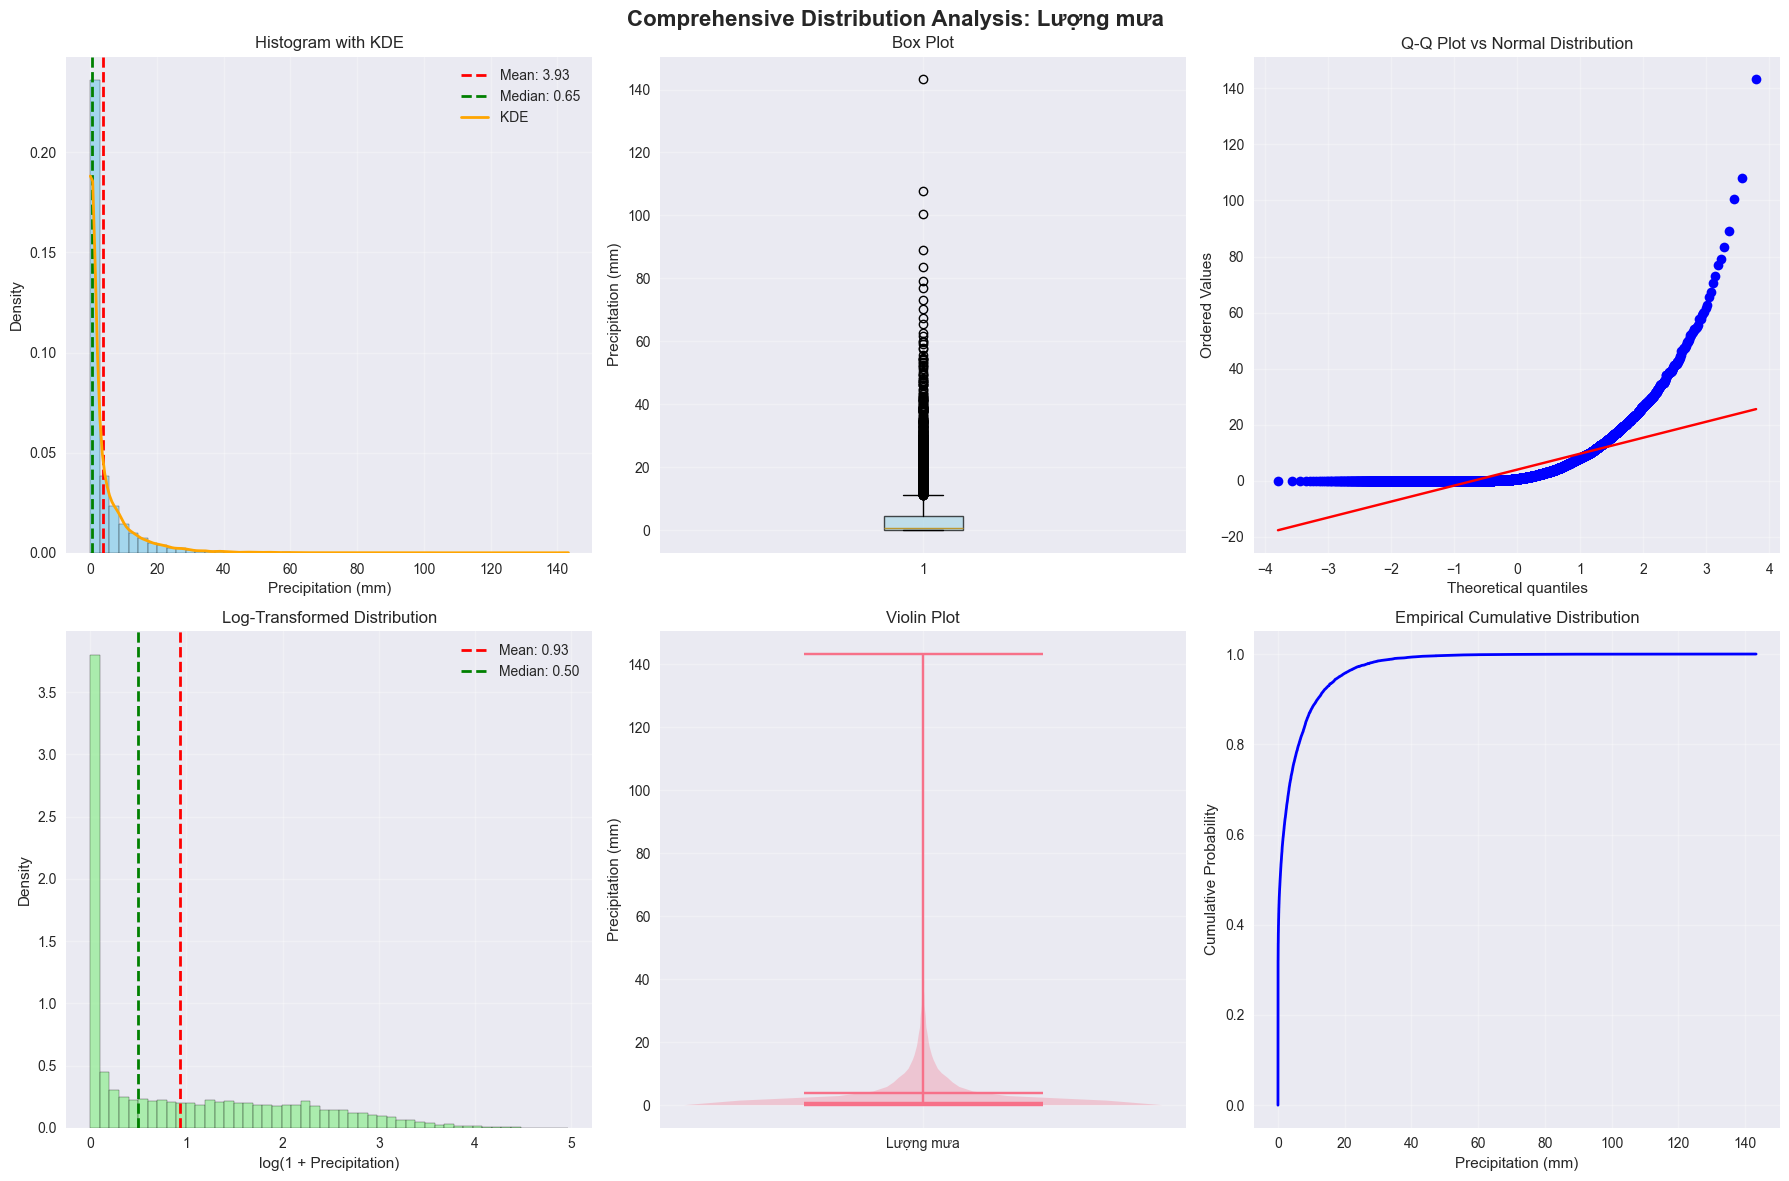


📊 Creating distribution overview for all features...


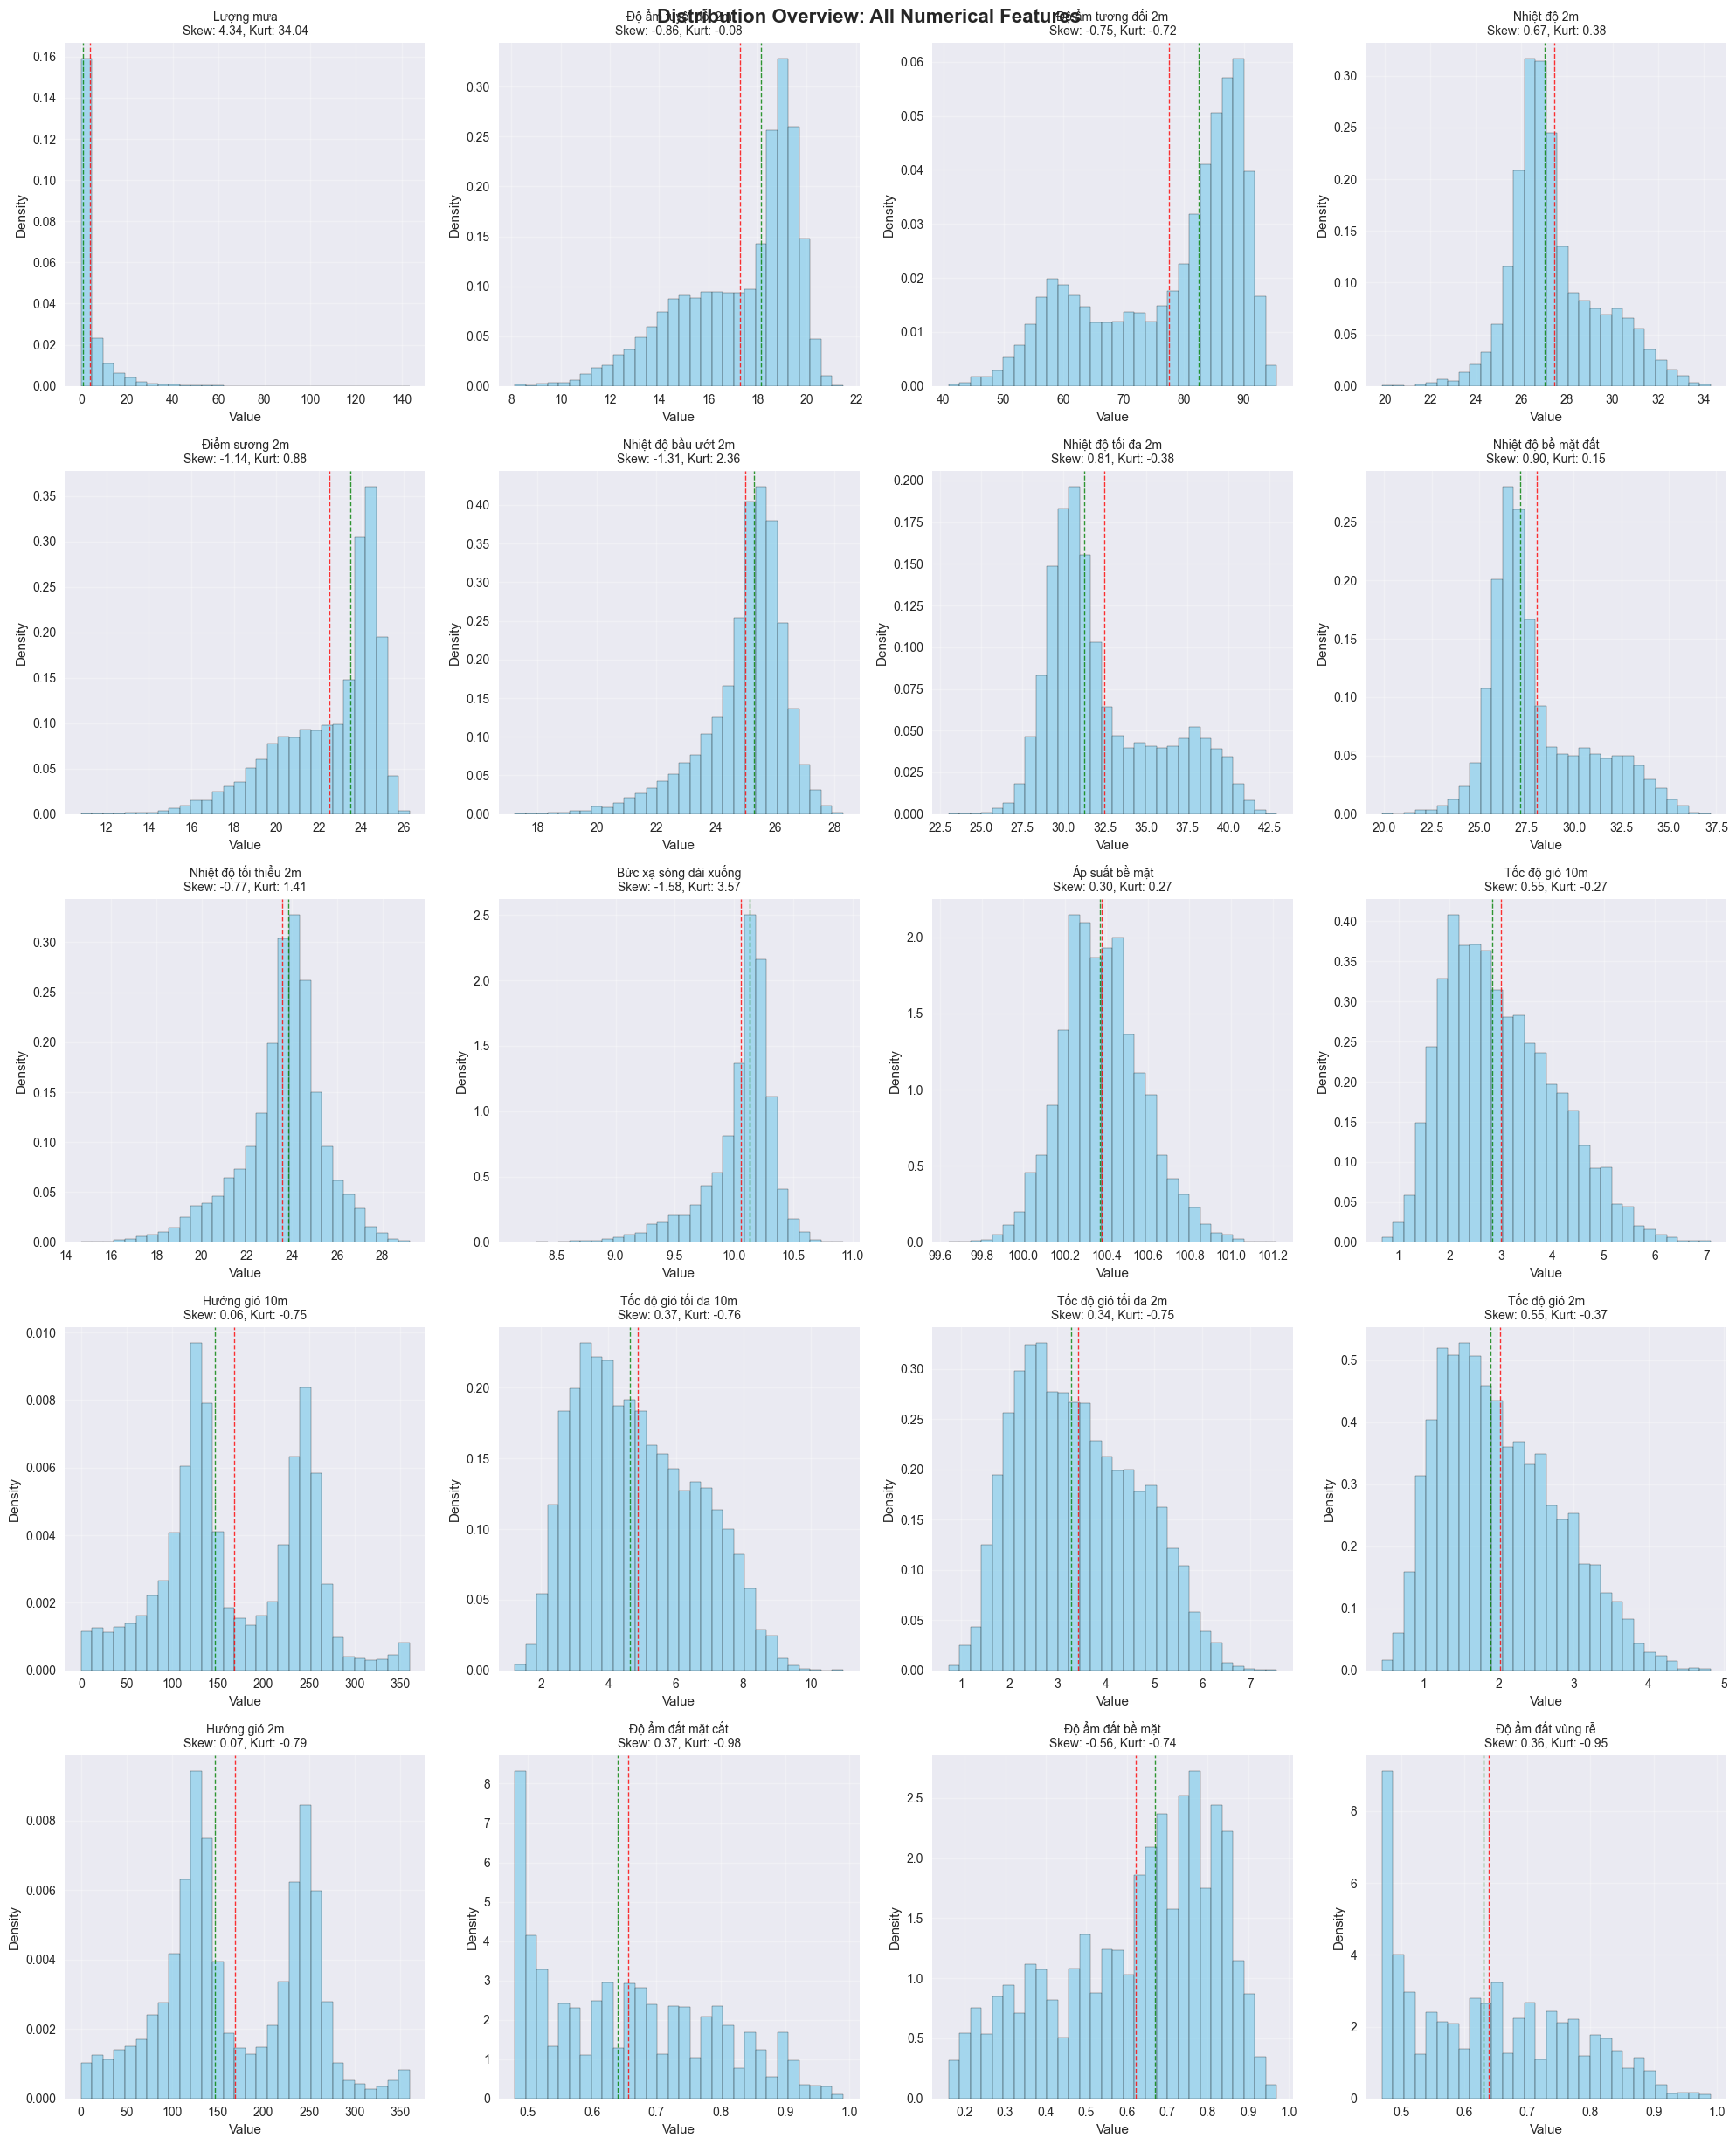


📐 Creating skewness and kurtosis comparison...


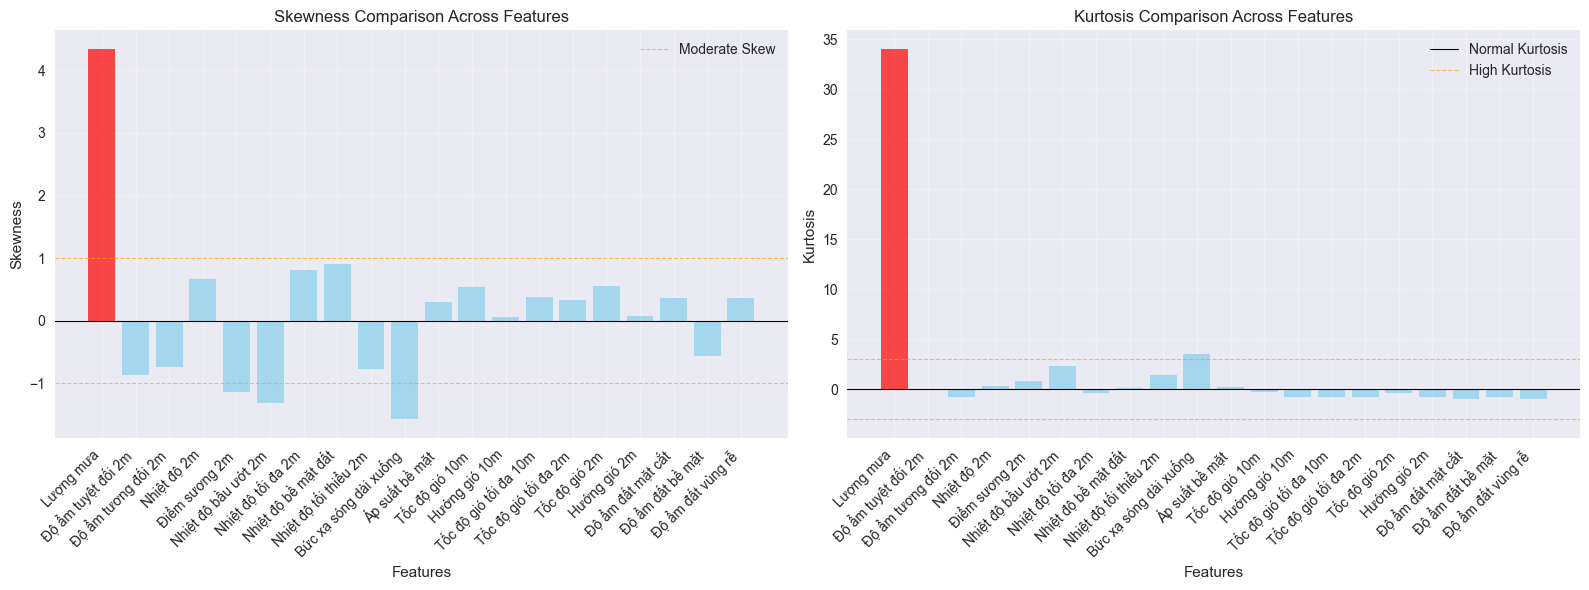


🔍 KEY INSIGHTS:

🎯 Target Variable (Lượng mưa):
   - Highly right-skewed (skew=4.34)
   - Mean > Median (3.93 > 0.65)
   - High variability (CV = 194.6%)
   - No rain days: 25.7%
   - Light-moderate rain: 44.2%
   - Heavy rain events: 6.4%

📊 Distribution Characteristics:
   - Normally distributed features: 0/20
   - Most features are non-normal (typical for weather data)

📐 Skewness Patterns:
   - Highly skewed features: 4/20
   - Features requiring transformation: ['Lượng mưa', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Bức xạ sóng dài xuống']

🔬 Non-parametric Test Results:
   - Features with significant rain/no-rain differences: 19 (['Độ ẩm tuyệt đối 2m', 'Độ ẩm tương đối 2m', 'Nhiệt độ 2m', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Nhiệt độ tối đa 2m', 'Nhiệt độ bề mặt đất', 'Nhiệt độ tối thiểu 2m', 'Bức xạ sóng dài xuống', 'Áp suất bề mặt', 'Tốc độ gió 10m', 'Hướng gió 10m', 'Tốc độ gió tối đa 10m', 'Tốc độ gió tối đa 2m', 'Tốc độ gió 2m', 'Hướng gió 2m', 'Độ ẩm đất mặt cắt', 'Độ ẩ

In [4]:
# -*- coding: utf-8 -*-
"""
Distribution Analysis Module for Weather Time Series Data
Purpose: Comprehensive distribution analysis for precipitation prediction EDA
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, jarque_bera, skewtest, kurtosistest
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class DistributionAnalyzer:
    """
    Comprehensive Distribution Analysis for Weather Data
    """

    def __init__(self, df, target_col='Lượng mưa'):
        """
        Initialize Distribution Analyzer

        Args:
            df: DataFrame to analyze
            target_col: Target variable column name
        """
        self.df = df.copy()
        self.target_col = target_col
        self.numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Remove coordinate columns from main analysis
        coord_cols = ['Vĩ độ', 'Kinh độ']
        self.analysis_cols = [col for col in self.numerical_cols if col not in coord_cols]

        print("📊 DISTRIBUTION ANALYSIS INITIALIZED")
        print("="*60)
        print(f"   - Total Features: {len(self.numerical_cols)}")
        print(f"   - Analysis Features: {len(self.analysis_cols)}")
        print(f"   - Target Variable: {self.target_col}")
        print(f"   - Sample Size: {len(self.df):,}")

    def descriptive_statistics_summary(self):
        """
        1. Tính toán và hiển thị thống kê mô tả chi tiết cho tất cả features
        """
        print("\n" + "="*80)
        print("📈 1. DESCRIPTIVE STATISTICS SUMMARY")
        print("="*80)

        # Calculate comprehensive descriptive statistics
        desc_stats = []

        for col in self.analysis_cols:
            data = self.df[col].dropna()

            if len(data) == 0:
                continue

            # Basic statistics
            mean_val = data.mean()
            median_val = data.median()

            # Mode calculation (most frequent value)
            mode_result = data.mode()
            mode_val = mode_result.iloc[0] if len(mode_result) > 0 else np.nan

            # Shape statistics
            skewness = data.skew()
            kurt = data.kurtosis()

            # Variability statistics
            std_val = data.std()
            var_val = data.var()
            cv = (std_val / mean_val) * 100 if mean_val != 0 else np.inf

            # Range statistics
            range_val = data.max() - data.min()
            iqr = data.quantile(0.75) - data.quantile(0.25)

            # Percentiles
            p5 = data.quantile(0.05)
            p95 = data.quantile(0.95)

            stats_dict = {
                'Feature': col,
                'Count': len(data),
                'Mean': mean_val,
                'Median': median_val,
                'Mode': mode_val,
                'Std': std_val,
                'Variance': var_val,
                'CV(%)': cv,
                'Min': data.min(),
                'P5': p5,
                'Q1': data.quantile(0.25),
                'Q3': data.quantile(0.75),
                'P95': p95,
                'Max': data.max(),
                'Range': range_val,
                'IQR': iqr,
                'Skewness': skewness,
                'Kurtosis': kurt
            }

            desc_stats.append(stats_dict)

        # Create comprehensive DataFrame
        desc_df = pd.DataFrame(desc_stats)

        # Display main statistics
        print("📊 Comprehensive Descriptive Statistics:")
        print("="*120)

        # Basic stats
        basic_cols = ['Feature', 'Count', 'Mean', 'Median', 'Mode', 'Std', 'Min', 'Max']
        print("\n🔢 Basic Statistics:")
        print(desc_df[basic_cols].round(4).to_string(index=False))

        # Shape stats
        shape_cols = ['Feature', 'Skewness', 'Kurtosis', 'CV(%)', 'Range', 'IQR']
        print("\n📐 Shape & Variability Statistics:")
        print(desc_df[shape_cols].round(4).to_string(index=False))

        # Percentile stats
        percentile_cols = ['Feature', 'P5', 'Q1', 'Median', 'Q3', 'P95']
        print("\n📊 Percentile Statistics:")
        print(desc_df[percentile_cols].round(4).to_string(index=False))

        return desc_df

    def target_variable_deep_analysis(self):
        """
        2. Phân tích sâu biến mục tiêu (Lượng mưa)
        """
        print("\n" + "="*80)
        print(f"🎯 2. TARGET VARIABLE DEEP ANALYSIS: {self.target_col}")
        print("="*80)

        target_data = self.df[self.target_col].dropna()

        # Basic descriptive statistics
        print("📈 Basic Descriptive Statistics:")
        print(f"   - Count: {len(target_data):,}")
        print(f"   - Mean: {target_data.mean():.4f} mm")
        print(f"   - Median: {target_data.median():.4f} mm")
        print(f"   - Mode: {target_data.mode().iloc[0]:.4f} mm")
        print(f"   - Standard Deviation: {target_data.std():.4f} mm")
        print(f"   - Variance: {target_data.var():.4f}")
        print(f"   - Coefficient of Variation: {(target_data.std()/target_data.mean())*100:.2f}%")

        # Range and percentiles
        print(f"\n📊 Range and Percentiles:")
        print(f"   - Minimum: {target_data.min():.4f} mm")
        print(f"   - 5th Percentile: {target_data.quantile(0.05):.4f} mm")
        print(f"   - 25th Percentile (Q1): {target_data.quantile(0.25):.4f} mm")
        print(f"   - 50th Percentile (Median): {target_data.quantile(0.50):.4f} mm")
        print(f"   - 75th Percentile (Q3): {target_data.quantile(0.75):.4f} mm")
        print(f"   - 95th Percentile: {target_data.quantile(0.95):.4f} mm")
        print(f"   - Maximum: {target_data.max():.4f} mm")
        print(f"   - Range: {target_data.max() - target_data.min():.4f} mm")
        print(f"   - IQR: {target_data.quantile(0.75) - target_data.quantile(0.25):.4f} mm")

        # Shape statistics
        skewness = target_data.skew()
        kurt = target_data.kurtosis()

        print(f"\n📐 Shape Statistics:")
        print(f"   - Skewness: {skewness:.4f}")
        if skewness > 1:
            skew_interpretation = "Highly right-skewed (lệch phải mạnh)"
        elif skewness > 0.5:
            skew_interpretation = "Moderately right-skewed (lệch phải vừa)"
        elif skewness > -0.5:
            skew_interpretation = "Approximately symmetric (gần đối xứng)"
        elif skewness > -1:
            skew_interpretation = "Moderately left-skewed (lệch trái vừa)"
        else:
            skew_interpretation = "Highly left-skewed (lệch trái mạnh)"

        print(f"     → Interpretation: {skew_interpretation}")

        print(f"   - Kurtosis: {kurt:.4f}")
        if kurt > 3:
            kurt_interpretation = "Leptokurtic (nhọn hơn normal)"
        elif kurt < -3:
            kurt_interpretation = "Platykurtic (tù hơn normal)"
        else:
            kurt_interpretation = "Mesokurtic (gần normal)"
        print(f"     → Interpretation: {kurt_interpretation}")

        # Vietnamese Meteorological Standards Classification (24-hour basis)
        print(f"\n🌧️ Vietnamese Meteorological Standards Classification (24h):")
        print("   Based on Vietnamese National Weather Service Standards")

        # Apply Vietnamese standards for 24-hour precipitation
        no_rain = (target_data == 0).sum()
        trace_rain = ((target_data > 0) & (target_data <= 0.6)).sum()
        light_rain = ((target_data > 0.6) & (target_data <= 6.0)).sum()
        moderate_rain = ((target_data > 6.0) & (target_data <= 16.0)).sum()
        heavy_rain = ((target_data > 16.0) & (target_data <= 50.0)).sum()
        very_heavy_rain = ((target_data > 50.0) & (target_data <= 100.0)).sum()
        extremely_heavy_rain = (target_data > 100.0).sum()

        total_days = len(target_data)

        print(f"   - Không mưa (No Rain): {no_rain:,} days ({no_rain/total_days*100:.2f}%)")
        print(f"   - Mưa lượng không đáng kể (0-0.6mm): {trace_rain:,} days ({trace_rain/total_days*100:.2f}%)")
        print(f"   - Mưa nhỏ (0.6-6.0mm): {light_rain:,} days ({light_rain/total_days*100:.2f}%)")
        print(f"   - Mưa (6.0-16.0mm): {moderate_rain:,} days ({moderate_rain/total_days*100:.2f}%)")
        print(f"   - Mưa vừa (16.0-50.0mm): {heavy_rain:,} days ({heavy_rain/total_days*100:.2f}%)")
        print(f"   - Mưa to (50.0-100.0mm): {very_heavy_rain:,} days ({very_heavy_rain/total_days*100:.2f}%)")
        print(f"   - Mưa rất to (>100.0mm): {extremely_heavy_rain:,} days ({extremely_heavy_rain/total_days*100:.2f}%)")


        return {
            'basic_stats': {
                'count': len(target_data),
                'mean': target_data.mean(),
                'median': target_data.median(),
                'mode': target_data.mode().iloc[0],
                'std': target_data.std(),
                'skewness': skewness,
                'kurtosis': kurt
            },
            'intensity_distribution': {
                'no_rain': no_rain,
                'trace_rain': trace_rain,
                'light_rain': light_rain,
                'moderate_rain': moderate_rain,
                'heavy_rain': heavy_rain,
                'very_heavy_rain': very_heavy_rain,
                'extremely_heavy_rain': extremely_heavy_rain
            }
        }

    def distribution_shape_tests(self):
        """
        3. Kiểm tra thống kê về hình dạng phân phối
        """
        print("\n" + "="*80)
        print("🔬 3. STATISTICAL DISTRIBUTION SHAPE TESTS")
        print("="*80)

        test_results = []

        for col in self.analysis_cols:
            data = self.df[col].dropna()

            if len(data) < 8:  # Minimum sample size for tests
                continue

            # Sample data if too large for some tests
            sample_size = min(5000, len(data))
            sample_data = data.sample(sample_size) if len(data) > sample_size else data

            try:
                # Normality tests
                shapiro_stat, shapiro_p = stats.shapiro(sample_data)

                # D'Agostino's normality test
                dagostino_stat, dagostino_p = normaltest(sample_data)

                # Jarque-Bera test
                jb_stat, jb_p = jarque_bera(sample_data)

                # Skewness test
                skew_stat, skew_p = skewtest(data)

                # Kurtosis test
                kurt_stat, kurt_p = kurtosistest(data)

                # Anderson-Darling test for normality
                ad_stat, ad_critical, ad_sig = stats.anderson(sample_data, dist='norm')

                test_result = {
                    'Feature': col,
                    'Sample_Size': len(sample_data),
                    'Shapiro_Stat': shapiro_stat,
                    'Shapiro_P': shapiro_p,
                    'Shapiro_Normal': 'Yes' if shapiro_p > 0.05 else 'No',
                    'DAgostino_Stat': dagostino_stat,
                    'DAgostino_P': dagostino_p,
                    'DAgostino_Normal': 'Yes' if dagostino_p > 0.05 else 'No',
                    'JB_Stat': jb_stat,
                    'JB_P': jb_p,
                    'JB_Normal': 'Yes' if jb_p > 0.05 else 'No',
                    'Skew_Stat': skew_stat,
                    'Skew_P': skew_p,
                    'Skew_Normal': 'Yes' if skew_p > 0.05 else 'No',
                    'Kurt_Stat': kurt_stat,
                    'Kurt_P': kurt_p,
                    'Kurt_Normal': 'Yes' if kurt_p > 0.05 else 'No',
                    'AD_Stat': ad_stat,
                    'AD_Critical_5%': ad_critical[2],  # 5% significance level
                    'AD_Normal': 'Yes' if ad_stat < ad_critical[2] else 'No'
                }

                test_results.append(test_result)

            except Exception as e:
                print(f"   ⚠️ Error testing {col}: {e}")
                continue

        test_df = pd.DataFrame(test_results)

        if len(test_df) > 0:
            print("📊 Normality Test Results Summary:")
            print("="*100)

            # Main results table
            display_cols = ['Feature', 'Sample_Size', 'Shapiro_Normal', 'DAgostino_Normal',
                           'JB_Normal', 'Skew_Normal', 'Kurt_Normal', 'AD_Normal']
            print(test_df[display_cols].to_string(index=False))

            # Detailed results for target variable
            if self.target_col in test_df['Feature'].values:
                target_row = test_df[test_df['Feature'] == self.target_col].iloc[0]
                print(f"\n🎯 Detailed Results for {self.target_col}:")
                print(f"   - Shapiro-Wilk: statistic={target_row['Shapiro_Stat']:.6f}, p-value={target_row['Shapiro_P']:.2e}")
                print(f"   - D'Agostino: statistic={target_row['DAgostino_Stat']:.6f}, p-value={target_row['DAgostino_P']:.2e}")
                print(f"   - Jarque-Bera: statistic={target_row['JB_Stat']:.6f}, p-value={target_row['JB_P']:.2e}")
                print(f"   - Skewness test: statistic={target_row['Skew_Stat']:.6f}, p-value={target_row['Skew_P']:.2e}")
                print(f"   - Kurtosis test: statistic={target_row['Kurt_Stat']:.6f}, p-value={target_row['Kurt_P']:.2e}")
                print(f"   - Anderson-Darling: statistic={target_row['AD_Stat']:.6f}, critical_5%={target_row['AD_Critical_5%']:.6f}")

            # Summary statistics
            normal_features = test_df[
                (test_df['Shapiro_Normal'] == 'Yes') &
                (test_df['DAgostino_Normal'] == 'Yes') &
                (test_df['JB_Normal'] == 'Yes')
            ]['Feature'].tolist()

            print(f"\n📈 Summary:")
            print(f"   - Features possibly normal: {len(normal_features)} / {len(test_df)}")
            if normal_features:
                print(f"   - Normal features: {normal_features}")
            else:
                print(f"   - No features follow normal distribution")


        non_param_results = []
        target_data = self.df[self.target_col].dropna()

        for col in self.analysis_cols:
            if col == self.target_col:
                continue

            feature_data = self.df[col].dropna()
            aligned_indices = feature_data.index.intersection(target_data.index)
            if len(aligned_indices) < 20:
                continue

            aligned_feature = feature_data.loc[aligned_indices]
            aligned_target = target_data.loc[aligned_indices]

            test_result = {'Feature': col}

            try:
                # Mann-Whitney U Test (Rain vs No Rain)
                no_rain_feature = aligned_feature[aligned_target == 0]
                rain_feature = aligned_feature[aligned_target > 0]

                if len(no_rain_feature) > 5 and len(rain_feature) > 5:
                    mw_stat, mw_p = stats.mannwhitneyu(no_rain_feature, rain_feature, alternative='two-sided')
                    test_result['MW_Statistic'] = mw_stat
                    test_result['MW_P_Value'] = mw_p
                    test_result['MW_Significant'] = 'Yes' if mw_p < 0.05 else 'No'
                else:
                    test_result['MW_Statistic'] = np.nan
                    test_result['MW_P_Value'] = np.nan
                    test_result['MW_Significant'] = 'N/A'

                # Kruskal-Wallis Test
                no_rain_group = aligned_feature[aligned_target == 0]
                light_rain_group = aligned_feature[(aligned_target > 0) & (aligned_target <= 2.5)]
                moderate_rain_group = aligned_feature[(aligned_target > 2.5) & (aligned_target <= 7.5)]
                heavy_rain_group = aligned_feature[aligned_target > 7.5]

                groups_with_data = [g for g in [no_rain_group, light_rain_group, moderate_rain_group, heavy_rain_group] if len(g) > 3]

                if len(groups_with_data) >= 3:
                    kw_stat, kw_p = stats.kruskal(*groups_with_data)
                    test_result['KW_Statistic'] = kw_stat
                    test_result['KW_P_Value'] = kw_p
                    test_result['KW_Significant'] = 'Yes' if kw_p < 0.05 else 'No'
                else:
                    test_result['KW_Statistic'] = np.nan
                    test_result['KW_P_Value'] = np.nan
                    test_result['KW_Significant'] = 'N/A'

                # Spearman Rank Correlation
                spearman_corr, spearman_p = stats.spearmanr(aligned_feature, aligned_target)
                test_result['Spearman_Corr'] = spearman_corr
                test_result['Spearman_P_Value'] = spearman_p
                test_result['Spearman_Significant'] = 'Yes' if spearman_p < 0.05 else 'No'

            except Exception as e:
                print(f"   ⚠️ Error in non-parametric tests for {col}: {e}")
                continue

            non_param_results.append(test_result)

        # Display non-parametric results
        non_param_df = pd.DataFrame(non_param_results) if non_param_results else pd.DataFrame()

        if not non_param_df.empty:
            print("\n📊 Non-parametric Test Results:")
            print("="*120)

            # Mann-Whitney U Test results
            mw_cols = ['Feature', 'MW_Statistic', 'MW_P_Value', 'MW_Significant']
            print("\n🔍 Mann-Whitney U Test (Rain vs No Rain):")
            mw_results = non_param_df[mw_cols].dropna(subset=['MW_Statistic'])
            if not mw_results.empty:
                print(mw_results.round(6).to_string(index=False))

            # Kruskal-Wallis Test results
            kw_cols = ['Feature', 'KW_Statistic', 'KW_P_Value', 'KW_Significant']
            print("\n🔍 Kruskal-Wallis Test (Multiple Rainfall Groups):")
            kw_results = non_param_df[kw_cols].dropna(subset=['KW_Statistic'])
            if not kw_results.empty:
                print(kw_results.round(6).to_string(index=False))

            # Spearman Correlation results
            spear_cols = ['Feature', 'Spearman_Corr', 'Spearman_P_Value', 'Spearman_Significant']
            print("\n🔍 Spearman Rank Correlation with Rainfall:")
            spear_results = non_param_df[spear_cols].dropna(subset=['Spearman_Corr'])
            if not spear_results.empty:
                print(spear_results.round(6).to_string(index=False))

        return {'normality_tests': test_df, 'non_parametric_tests': non_param_df}

    def visualize_distributions(self):
        """
        4. Tạo visualization cho phân phối các features
        """
        print("\n" + "="*80)
        print("📊 4. DISTRIBUTION VISUALIZATIONS")
        print("="*80)

        # 4.1 Target Variable Comprehensive Visualization
        print("🎯 Creating comprehensive target variable visualization...")

        target_data = self.df[self.target_col].dropna()

        # Create comprehensive subplot for target variable
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Comprehensive Distribution Analysis: {self.target_col}', fontsize=16, fontweight='bold')

        # Histogram with KDE
        axes[0,0].hist(target_data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(target_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {target_data.mean():.2f}')
        axes[0,0].axvline(target_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {target_data.median():.2f}')
        # Add KDE
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(target_data)
        x_range = np.linspace(target_data.min(), target_data.max(), 200)
        axes[0,0].plot(x_range, kde(x_range), 'orange', linewidth=2, label='KDE')
        axes[0,0].set_title('Histogram with KDE')
        axes[0,0].set_xlabel('Precipitation (mm)')
        axes[0,0].set_ylabel('Density')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Box plot
        axes[0,1].boxplot(target_data, vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[0,1].set_title('Box Plot')
        axes[0,1].set_ylabel('Precipitation (mm)')
        axes[0,1].grid(True, alpha=0.3)

        # Q-Q plot against normal distribution
        stats.probplot(target_data, dist="norm", plot=axes[0,2])
        axes[0,2].set_title('Q-Q Plot vs Normal Distribution')
        axes[0,2].grid(True, alpha=0.3)

        # Log-scale histogram (for better visualization of skewed data)
        log_data = np.log1p(target_data)  # log(1+x) to handle zeros
        axes[1,0].hist(log_data, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1,0].axvline(log_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {log_data.mean():.2f}')
        axes[1,0].axvline(log_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {log_data.median():.2f}')
        axes[1,0].set_title('Log-Transformed Distribution')
        axes[1,0].set_xlabel('log(1 + Precipitation)')
        axes[1,0].set_ylabel('Density')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Violin plot
        axes[1,1].violinplot([target_data], positions=[1], showmeans=True, showmedians=True)
        axes[1,1].set_title('Violin Plot')
        axes[1,1].set_ylabel('Precipitation (mm)')
        axes[1,1].set_xticks([1])
        axes[1,1].set_xticklabels([self.target_col])
        axes[1,1].grid(True, alpha=0.3)

        # Empirical CDF
        sorted_data = np.sort(target_data)
        y_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        axes[1,2].plot(sorted_data, y_vals, 'b-', linewidth=2)
        axes[1,2].set_title('Empirical Cumulative Distribution')
        axes[1,2].set_xlabel('Precipitation (mm)')
        axes[1,2].set_ylabel('Cumulative Probability')
        axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 4.2 All Features Distribution Overview
        print("\n📊 Creating distribution overview for all features...")

        # Calculate number of plots needed
        n_features = len(self.analysis_cols)
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        fig.suptitle('Distribution Overview: All Numerical Features', fontsize=16, fontweight='bold')

        # Flatten axes array for easier indexing
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()

        for i, col in enumerate(self.analysis_cols):
            data = self.df[col].dropna()

            if len(data) > 0:
                # Create histogram with KDE
                axes[i].hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

                # Add statistics
                axes[i].axvline(data.mean(), color='red', linestyle='--', linewidth=1, alpha=0.8)
                axes[i].axvline(data.median(), color='green', linestyle='--', linewidth=1, alpha=0.8)

                axes[i].set_title(f'{col}\nSkew: {data.skew():.2f}, Kurt: {data.kurtosis():.2f}', fontsize=10)
                axes[i].set_xlabel('Value')
                axes[i].set_ylabel('Density')
                axes[i].grid(True, alpha=0.3)

        # Hide empty subplots
        for i in range(len(self.analysis_cols), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        # 4.3 Skewness and Kurtosis Comparison
        print("\n📐 Creating skewness and kurtosis comparison...")

        skew_kurt_data = []
        for col in self.analysis_cols:
            data = self.df[col].dropna()
            if len(data) > 0:
                skew_kurt_data.append({
                    'Feature': col,
                    'Skewness': data.skew(),
                    'Kurtosis': data.kurtosis(),
                    'Is_Target': col == self.target_col
                })

        skew_kurt_df = pd.DataFrame(skew_kurt_data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Skewness plot
        colors = ['red' if is_target else 'skyblue' for is_target in skew_kurt_df['Is_Target']]
        bars1 = ax1.bar(range(len(skew_kurt_df)), skew_kurt_df['Skewness'], color=colors, alpha=0.7)
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax1.axhline(y=1, color='orange', linestyle='--', linewidth=0.8, alpha=0.7, label='Moderate Skew')
        ax1.axhline(y=-1, color='orange', linestyle='--', linewidth=0.8, alpha=0.7)
        ax1.set_title('Skewness Comparison Across Features')
        ax1.set_xlabel('Features')
        ax1.set_ylabel('Skewness')
        ax1.set_xticks(range(len(skew_kurt_df)))
        ax1.set_xticklabels(skew_kurt_df['Feature'], rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Kurtosis plot
        bars2 = ax2.bar(range(len(skew_kurt_df)), skew_kurt_df['Kurtosis'], color=colors, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8, label='Normal Kurtosis')
        ax2.axhline(y=3, color='orange', linestyle='--', linewidth=0.8, alpha=0.7, label='High Kurtosis')
        ax2.axhline(y=-3, color='orange', linestyle='--', linewidth=0.8, alpha=0.7)
        ax2.set_title('Kurtosis Comparison Across Features')
        ax2.set_xlabel('Features')
        ax2.set_ylabel('Kurtosis')
        ax2.set_xticks(range(len(skew_kurt_df)))
        ax2.set_xticklabels(skew_kurt_df['Feature'], rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        return skew_kurt_df

    def generate_distribution_report(self):
        """
        5. Tạo báo cáo tổng hợp về phân phối
        """
        print("\n" + "="*80)
        print("📋 5. DISTRIBUTION ANALYSIS SUMMARY REPORT")
        print("="*80)

        # Run all analyses
        desc_stats = self.descriptive_statistics_summary()
        target_analysis = self.target_variable_deep_analysis()
        distribution_tests = self.distribution_shape_tests()
        skew_kurt_comparison = self.visualize_distributions()

        # Extract results
        normality_tests = distribution_tests['normality_tests']
        non_parametric_tests = distribution_tests['non_parametric_tests']

        # Summary insights
        print(f"\n🔍 KEY INSIGHTS:")

        # Target variable insights
        target_stats = target_analysis['basic_stats']
        print(f"\n🎯 Target Variable ({self.target_col}):")
        print(f"   - Highly right-skewed (skew={target_stats['skewness']:.2f})")
        print(f"   - Mean > Median ({target_stats['mean']:.2f} > {target_stats['median']:.2f})")
        print(f"   - High variability (CV = {(target_stats['std']/target_stats['mean'])*100:.1f}%)")

        intensity_dist = target_analysis['intensity_distribution']
        total_obs = sum(intensity_dist.values())
        print(f"   - No rain days: {intensity_dist['no_rain']/total_obs*100:.1f}%")
        print(f"   - Light-moderate rain: {(intensity_dist['light_rain']+intensity_dist['moderate_rain'])/total_obs*100:.1f}%")
        print(f"   - Heavy rain events: {(intensity_dist['heavy_rain']+intensity_dist['very_heavy_rain'])/total_obs*100:.1f}%")

        # Distribution characteristics
        if len(normality_tests) > 0:
            normal_count = sum([
                1 for _, row in normality_tests.iterrows()
                if row['Shapiro_Normal'] == 'Yes' and row['JB_Normal'] == 'Yes'
            ])
            print(f"\n📊 Distribution Characteristics:")
            print(f"   - Normally distributed features: {normal_count}/{len(normality_tests)}")
            print(f"   - Most features are non-normal (typical for weather data)")

        # Skewness patterns
        if len(skew_kurt_comparison) > 0:
            high_skew = skew_kurt_comparison[abs(skew_kurt_comparison['Skewness']) > 1]
            print(f"\n📐 Skewness Patterns:")
            print(f"   - Highly skewed features: {len(high_skew)}/{len(skew_kurt_comparison)}")
            print(f"   - Features requiring transformation: {high_skew['Feature'].tolist()}")

        # Non-parametric test insights
        if not non_parametric_tests.empty:
            significant_mw = non_parametric_tests[non_parametric_tests['MW_Significant'] == 'Yes']['Feature'].tolist()
            significant_kw = non_parametric_tests[non_parametric_tests['KW_Significant'] == 'Yes']['Feature'].tolist()
            significant_spear = non_parametric_tests[non_parametric_tests['Spearman_Significant'] == 'Yes']['Feature'].tolist()

            print(f"\n🔬 Non-parametric Test Results:")
            print(f"   - Features with significant rain/no-rain differences: {len(significant_mw)} ({significant_mw})")
            print(f"   - Features with significant group differences: {len(significant_kw)} ({significant_kw})")
            print(f"   - Features with significant rank correlation: {len(significant_spear)} ({significant_spear})")

        return {
            'descriptive_stats': desc_stats,
            'target_analysis': target_analysis,
            'normality_tests': normality_tests,
            'non_parametric_tests': non_parametric_tests,
            'skew_kurt_comparison': skew_kurt_comparison,
            'summary_insights': {
                'target_skewness': target_stats['skewness'],
                'zero_rain_percentage': intensity_dist['no_rain']/total_obs*100,
                'normal_features_count': normal_count if len(normality_tests) > 0 else 0,
                'high_skew_features': high_skew['Feature'].tolist() if len(skew_kurt_comparison) > 0 else []
            }
        }

# =============================================================================
# USAGE FUNCTION
# =============================================================================

def analyze_distributions(df, target_col='Lượng mưa'):
    """
    Chạy phân tích phân phối toàn diện

    Args:
        df: DataFrame cần phân tích
        target_col: Tên cột biến mục tiêu

    Returns:
        dict: Báo cáo chi tiết về phân phối
    """

    print("🚀 STARTING COMPREHENSIVE DISTRIBUTION ANALYSIS")
    print("="*80)

    # Initialize analyzer
    analyzer = DistributionAnalyzer(df, target_col)

    # Generate comprehensive report
    distribution_report = analyzer.generate_distribution_report()

    print("\n✅ DISTRIBUTION ANALYSIS COMPLETED")
    print("="*80)

    return distribution_report

# =============================================================================
# RUN ANALYSIS ON YOUR DATA
# =============================================================================

# Chạy phân tích phân phối cho DataFrame df_all
distribution_results = analyze_distributions(df_all, target_col='Lượng mưa')

# Hiển thị key insights
print(f"\n🔑 KEY FINDINGS:")
insights = distribution_results['summary_insights']
print(f"   - Target skewness: {insights['target_skewness']:.2f}")
print(f"   - Zero rain percentage: {insights['zero_rain_percentage']:.1f}%")
print(f"   - Normal features: {insights['normal_features_count']}")
print(f"   - High skew features: {len(insights['high_skew_features'])}")

# Time-Series Analysis

In [5]:
# =============================================================================
# BASE ANALYZER CLASS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10



class BaseAnalyzer:
    """
    Base class cho tất cả analysis components
    """
    def __init__(self, df, target_col='Lượng mưa', date_col='Ngày'):
        """Initialize base analyzer with common data preparation"""
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        self._prepare_data()

    def _prepare_data(self):
        """Common data preparation for all analyzers"""
        # Ensure datetime format
        if not pd.api.types.is_datetime64_any_dtype(self.df[self.date_col]):
            self.df[self.date_col] = pd.to_datetime(self.df[self.date_col], errors='coerce')

        # Get numerical columns (excluding coordinates)
        self.numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        coord_cols = ['Vĩ độ', 'Kinh độ']
        self.analysis_cols = [col for col in self.numerical_cols if col not in coord_cols]

        # Sort by date
        self.df = self.df.sort_values(self.date_col).reset_index(drop=True)

        # Add time features
        self.df['Month'] = self.df[self.date_col].dt.month
        self.df['Year'] = self.df[self.date_col].dt.year
        self.df['DayOfYear'] = self.df[self.date_col].dt.dayofyear
        self.df['DayOfWeek'] = self.df[self.date_col].dt.dayofweek
        self.df['Season'] = self.df['Month'].map({12:1, 1:1, 2:1, 3:2, 4:2, 5:2,
                                                 6:3, 7:3, 8:3, 9:4, 10:4, 11:4})

    def analyze(self):
        """Abstract method - must implement in subclasses"""
        raise NotImplementedError("Subclasses must implement analyze() method")


# =============================================================================
# MAIN ORCHESTRATOR CLASS
# =============================================================================

class WeatherEDAAnalyzer:
    """Updated main orchestrator with new TemporalStructureAnalyzer"""

    def __init__(self, df, target_col='Lượng mưa', date_col='Ngày'):
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col

        print("🚀 WEATHER EDA ANALYZER INITIALIZED")
        print("="*70)
        print(f"   📊 Dataset Shape: {self.df.shape}")
        print(f"   🎯 Target Variable: {self.target_col}")

    def run_temporal_structure_analysis(self):
        """Run comprehensive temporal structure analysis"""
        self.temporal_structure = TemporalStructureAnalyzer(self.df, self.target_col, self.date_col)
        return self.temporal_structure.analyze()

    # Keep other existing methods...
    def run_extreme_events_analysis(self):
        self.extreme_events = ExtremeEventsAnalyzer(self.df, self.target_col, self.date_col)
        return self.extreme_events.analyze()

    def run_stationarity_autocorr_analysis(self, mstl_results=None):
        """Run combined stationarity and autocorrelation analysis"""
        self.stationarity_autocorr = StationarityAutocorrelationAnalyzer(
            self.df, self.target_col, self.date_col, mstl_results
        )
        return self.stationarity_autocorr.analyze()

## Temporal Structure & Seasonality

In [6]:
# =============================================================================
# ENHANCED COMPONENT: TEMPORAL STRUCTURE ANALYZER
# Combines: Time Series Decomposition + Frequency Analysis + Advanced Analysis
# =============================================================================

class TemporalStructureAnalyzer(BaseAnalyzer):
    """
    Enhanced Component: Comprehensive Temporal Structure Analysis
    Combines temporal patterns, frequency domain, and advanced decomposition
    """

    # Update main analyze method to include wavelet analysis
    def analyze(self):
        """Main orchestration function - runs complete temporal analysis workflow"""
        print("\n" + "="*70)
        print("🕐 ENHANCED COMPONENT: TEMPORAL STRUCTURE ANALYSIS")
        print("="*70)

        # Steps 1-4 (existing code...)
        visual_results = self._visual_seasonal_pattern_analysis()
        frequency_results = self._frequency_domain_analysis()
        mstl_results = self._mstl_decomposition(frequency_results.get('dominant_periods', [7, 30, 365]))

        trend_analysis = {}
        seasonal_analysis = {}
        residual_analysis = {}
        wavelet_analysis = {}

        if mstl_results['success']:
            trend_analysis = self._trend_cyclical_analysis(mstl_results)
            seasonal_analysis = self._seasonal_components_analysis(mstl_results)
            residual_analysis = self._residual_analysis(mstl_results)

            # Step 5: NEW - Wavelet analysis
            wavelet_analysis = self._wavelet_analysis(mstl_results)

        # Combine all results
        results = {
            'visual_patterns': visual_results,
            'frequency_analysis': frequency_results,
            'mstl_decomposition': mstl_results,
            'trend_analysis': trend_analysis,
            'seasonal_analysis': seasonal_analysis,
            'residual_analysis': residual_analysis,
            'wavelet_analysis': wavelet_analysis,
            'component_name': 'TemporalStructureAnalyzer'
        }

        print(f"\n✅ TEMPORAL STRUCTURE ANALYSIS COMPLETED")
        return results

    def _visual_seasonal_pattern_analysis(self):
        """
        Step 1: Visual seasonal pattern analysis (from TimeSeriesAnalyzer)
        """
        print("🔍 Step 1: Visual Seasonal Pattern Analysis")
        print("-" * 50)

        # Monthly statistics
        monthly_stats = self.df.groupby('Month')[self.target_col].agg(['mean', 'std', 'median', 'count']).round(4)

        # Plot seasonal patterns
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Visual Seasonal Patterns Analysis', fontsize=16, fontweight='bold')

        # Monthly box plot
        sns.boxplot(data=self.df, x='Month', y=self.target_col, ax=axes[0,0])
        axes[0,0].set_title('Monthly Distribution')
        axes[0,0].set_xlabel('Month')
        axes[0,0].set_ylabel('Precipitation (mm)')
        axes[0,0].grid(True, alpha=0.3)

        # Monthly average
        monthly_mean = self.df.groupby('Month')[self.target_col].mean()
        axes[0,1].bar(monthly_mean.index, monthly_mean.values, color='skyblue', alpha=0.7)
        axes[0,1].set_title('Average Monthly Precipitation')
        axes[0,1].set_xlabel('Month')
        axes[0,1].set_ylabel('Average Precipitation (mm)')
        axes[0,1].grid(True, alpha=0.3)

        # Daily pattern within year
        daily_pattern = self.df.groupby('DayOfYear')[self.target_col].mean()
        axes[1,0].plot(daily_pattern.index, daily_pattern.values, 'b-', linewidth=1, alpha=0.7)
        axes[1,0].set_title('Daily Pattern Throughout Year')
        axes[1,0].set_xlabel('Day of Year')
        axes[1,0].set_ylabel('Average Precipitation (mm)')
        axes[1,0].grid(True, alpha=0.3)

        # Yearly trend
        yearly_stats = self.df.groupby('Year')[self.target_col].mean()
        axes[1,1].plot(yearly_stats.index, yearly_stats.values, 'ro-', linewidth=2, markersize=6)
        axes[1,1].set_title('Yearly Trend')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Average Precipitation (mm)')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Identify seasons
        wet_months = monthly_mean[monthly_mean > monthly_mean.quantile(0.75)].index.tolist()
        dry_months = monthly_mean[monthly_mean < monthly_mean.quantile(0.25)].index.tolist()

        print(f"   🌧️ Wet Season (months): {wet_months}")
        print(f"   ☀️ Dry Season (months): {dry_months}")

        return {
            'monthly_stats': monthly_stats,
            'monthly_mean': monthly_mean,
            'daily_pattern': daily_pattern,
            'yearly_stats': yearly_stats,
            'wet_months': wet_months,
            'dry_months': dry_months
        }

    def _frequency_domain_analysis(self):
        """
        Step 2: Frequency domain analysis to detect periods (from FrequencyAnalyzer)
        """
        print(f"\n🔊 Step 2: Frequency Domain Analysis for Period Detection")
        print("-" * 50)

        # Prepare time series data
        ts_data = self.df.set_index(self.date_col).sort_index()
        target_ts = ts_data[self.target_col].dropna()

        if len(target_ts) < 365:
            print("   ⚠️ Insufficient data for frequency analysis")
            return {'success': False, 'dominant_periods': [7, 30, 365]}

        # Remove trend for better frequency analysis
        detrended = target_ts - target_ts.rolling(window=30, center=True).mean()
        detrended = detrended.dropna()

        # Perform FFT
        fft_values = fft(detrended.values)
        frequencies = fftfreq(len(detrended), d=1)

        # Get positive frequencies
        positive_freq_idx = frequencies > 0
        positive_frequencies = frequencies[positive_freq_idx]
        positive_fft_magnitude = np.abs(fft_values[positive_freq_idx])
        periods = 1 / positive_frequencies

        # Find dominant periods
        peak_indices = np.argsort(positive_fft_magnitude)[-10:]
        dominant_periods = periods[peak_indices]

        # Filter reasonable periods (7 days to 2 years)
        reasonable_periods = dominant_periods[(dominant_periods >= 7) & (dominant_periods <= 730)]

        print(f"   📊 Detected {len(reasonable_periods)} dominant periods for MSTL:")

        for period in reasonable_periods[::-1]:
            print(f"      - {period:.1f} days")

        dominant_periods_int = sorted(list(set(np.round(reasonable_periods).astype(int))))

        return {
            'dominant_periods': dominant_periods_int,
            'all_periods': periods,
            'magnitudes': positive_fft_magnitude,
            'success': True
        }

    def _mstl_decomposition(self, periods):
        """
        Step 3: Enhanced MSTL decomposition with detected periods
        """
        print(f"\n📊 Step 3: MSTL Decomposition with Detected Periods")
        print("-" * 50)

        try:
            from statsmodels.tsa.seasonal import MSTL

            # Prepare time series
            ts_data = self.df.set_index(self.date_col).sort_index()
            target_ts = ts_data[self.target_col].dropna()

            # Apply log transformation for better decomposition
            log_ts = np.log1p(target_ts)
            print(f"   🔄 Applied log1p transformation")

            # Run MSTL decomposition
            mstl = MSTL(log_ts, periods=periods)
            mstl_result = mstl.fit()

            print(f"   ✅ MSTL decomposition completed successfully")

            # Store results
            return {
                'mstl_obj': mstl_result,
                'log_ts': log_ts,
                'original_ts': target_ts,
                'periods': periods,
                'trend': mstl_result.trend,
                'seasonal': mstl_result.seasonal,
                'resid': mstl_result.resid,
                'success': True
            }

        except Exception as e:
            print(f"   ⚠️ MSTL decomposition failed: {e}")
            return {
                'success': False,
                'error': str(e)
            }

    def _trend_cyclical_analysis(self, mstl_results):
        """
        Step 4a: NEW - Trend and cyclical component analysis
        """
        print(f"\n📈 Step 4a: Trend & Cyclical Analysis")
        print("-" * 50)

        trend = mstl_results['trend']
        original_ts = mstl_results['original_ts']

        # Trend visualization and analysis
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle('Trend & Cyclical Component Analysis', fontsize=16, fontweight='bold')

        # Trend component
        axes[0].plot(trend.index, trend.values, 'g-', linewidth=2, label='Trend')
        axes[0].set_title('Long-term Trend Component')
        axes[0].set_ylabel('Log Trend')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Original vs trend
        axes[1].plot(original_ts.index, original_ts.values, 'b-', alpha=0.7, label='Original')
        trend_original_scale = np.expm1(trend)  # Convert back from log scale
        axes[1].plot(trend.index, trend_original_scale.values, 'g-', linewidth=2, label='Trend (original scale)')
        axes[1].set_title('Original Data vs Extracted Trend')
        axes[1].set_ylabel('Precipitation (mm)')
        axes[1].set_xlabel('Date')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Quantitative trend analysis
        trend_clean = trend.dropna()
        if len(trend_clean) > 2:
            # Calculate trend slope (simple linear regression)
            x_numeric = np.arange(len(trend_clean))
            slope, intercept = np.polyfit(x_numeric, trend_clean.values, 1)

            trend_direction = "Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Stable"
            print(f"   📊 Trend Analysis:")
            print(f"      - Direction: {trend_direction}")
            print(f"      - Slope: {slope:.6f} log-units per day")
            print(f"      - Annual change: {slope * 365:.3f} log-units per year")

        # Cyclical patterns (detrended analysis)
        detrended = original_ts - trend_original_scale
        detrended_clean = detrended.dropna()

        if len(detrended_clean) > 100:
            print(f"   🔄 Cyclical patterns (after detrending):")
            print(f"      - Detrended data range: {detrended_clean.min():.2f} to {detrended_clean.max():.2f} mm")
            print(f"      - Variability: {detrended_clean.std():.2f} mm (std)")

        return {
            'trend_component': trend,
            'trend_direction': trend_direction if 'trend_direction' in locals() else 'Unknown',
            'trend_slope': slope if 'slope' in locals() else None,
            'detrended_data': detrended_clean if 'detrended_clean' in locals() else None
        }

    def _seasonal_components_analysis(self, mstl_results):
        """
        Step 4b: NEW - Individual seasonal components analysis (COMPLETELY FIXED)
        """
        print(f"\n🌀 Step 4b: Seasonal Components Analysis")
        print("-" * 50)

        mstl_obj = mstl_results['mstl_obj']
        periods = mstl_results['periods']
        # MSTL provides multiple seasonal components
        seasonal_components = {}

        try:
            # Extract individual seasonal components
            for i, period in enumerate(periods):
                component_name = f"seasonal_{period}d"
                # Access individual seasonal components from MSTL
                if hasattr(mstl_obj, 'seasonal_dict'):
                    seasonal_components[component_name] = mstl_obj.seasonal_dict[period]
                else:
                    # If not available, show combined seasonal
                    if i == 0:
                        seasonal_components['seasonal_combined'] = mstl_obj.seasonal

            # Visualization
            n_components = len(seasonal_components)
            if n_components > 0:
                fig, axes = plt.subplots(n_components, 1, figsize=(15, 4*n_components))
                if n_components == 1:
                    axes = [axes]

                fig.suptitle('Individual Seasonal Components', fontsize=16, fontweight='bold')

                for i, (comp_name, comp_data) in enumerate(seasonal_components.items()):
                    axes[i].plot(comp_data.index, comp_data.values, 'r-', linewidth=1.5)
                    axes[i].set_title(f'{comp_name.replace("_", " ").title()}')
                    axes[i].set_ylabel('Log Seasonal Effect')
                    axes[i].grid(True, alpha=0.3)

                    # COMPLETELY FIXED: Safe scalar extraction
                    try:
                        # Method 1: Use numpy/pandas operations and convert safely
                        comp_values = comp_data.values  # Get numpy array
                        comp_max = np.max(comp_values)
                        comp_min = np.min(comp_values)
                        comp_std = np.std(comp_values)

                        # Ensure scalar conversion
                        comp_range_val = float(comp_max - comp_min)
                        comp_std_val = float(comp_std)

                        axes[i].text(0.02, 0.95, f'Range: {comp_range_val:.4f}\nStd: {comp_std_val:.4f}',
                                  transform=axes[i].transAxes,
                                  bbox=dict(boxstyle="round", facecolor='wheat'),
                                  verticalalignment='top')
                    except Exception as text_error:
                        # Fallback: Simple component label without statistics
                        axes[i].text(0.02, 0.95, f'Component: {comp_name}',
                                  transform=axes[i].transAxes,
                                  bbox=dict(boxstyle="round", facecolor='lightgray'),
                                  verticalalignment='top')
                        print(f"      ⚠️ Text annotation fallback for {comp_name}")

                axes[-1].set_xlabel('Date')
                plt.tight_layout()
                plt.show()

            print(f"   📊 Seasonal Components Summary:")
            for comp_name, comp_data in seasonal_components.items():
                try:
                    # COMPLETELY FIXED: Safe scalar extraction for summary
                    comp_values = comp_data.values  # Get numpy array
                    strength_val = float(np.std(comp_values))  # Use numpy std directly
                    print(f"      - {comp_name}: strength = {strength_val:.4f}")
                except Exception as print_error:
                    # Fallback: Basic info without strength calculation
                    print(f"      - {comp_name}: component available (strength calculation skipped)")

        except Exception as e:
            print(f"   ⚠️ Error in seasonal component analysis: {e}")
            # Fallback to combined seasonal component
            try:
                seasonal_components = {'seasonal_combined': mstl_obj.seasonal}
                print(f"   📝 Using combined seasonal component as fallback")
            except:
                seasonal_components = {}

        return {
            'seasonal_components': seasonal_components,
            'periods_analyzed': periods,
            'components_count': len(seasonal_components)
        }

    def _residual_analysis(self, mstl_results):
        """
        Step 4c: NEW & IMPORTANT - Residual diagnostic analysis
        """
        print(f"\n🔍 Step 4c: Residual Diagnostic Analysis")
        print("-" * 50)

        residuals = mstl_results['resid'].dropna()

        # Residual statistics
        print(f"   📊 Residual Statistics:")
        print(f"      - Mean: {residuals.mean():.6f}")
        print(f"      - Std: {residuals.std():.6f}")
        print(f"      - Skewness: {residuals.skew():.6f}")
        print(f"      - Kurtosis: {residuals.kurtosis():.6f}")

        # Residual diagnostic plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Residual Diagnostic Analysis', fontsize=16, fontweight='bold')

        # Time series plot of residuals
        axes[0,0].plot(residuals.index, residuals.values, 'purple', alpha=0.7, linewidth=1)
        axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        axes[0,0].set_title('Residuals Over Time')
        axes[0,0].set_ylabel('Residual')
        axes[0,0].grid(True, alpha=0.3)

        # Residual histogram
        axes[0,1].hist(residuals.values, bins=50, alpha=0.7, color='purple', density=True)
        axes[0,1].set_title('Residual Distribution')
        axes[0,1].set_xlabel('Residual Value')
        axes[0,1].set_ylabel('Density')
        axes[0,1].grid(True, alpha=0.3)

        # ACF of residuals
        try:
            from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
            plot_acf(residuals, ax=axes[1,0], lags=40, alpha=0.05)
            axes[1,0].set_title('ACF of Residuals')
        except:
            axes[1,0].set_title('ACF Plot Not Available')

        # Q-Q plot
        try:
            from scipy.stats import probplot
            probplot(residuals.values, dist="norm", plot=axes[1,1])
            axes[1,1].set_title('Q-Q Plot (Normal)')
        except:
            axes[1,1].set_title('Q-Q Plot Not Available')

        plt.tight_layout()
        plt.show()

        # Ljung-Box test for autocorrelation in residuals
        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            ljung_box_result = acorr_ljungbox(residuals, lags=10, return_df=True)
            significant_lags = ljung_box_result[ljung_box_result['lb_pvalue'] < 0.05]

            print(f"   🧪 Ljung-Box Test Results:")
            if len(significant_lags) > 0:
                print(f"      ⚠️ Significant autocorrelation detected at {len(significant_lags)} lags")
                print(f"      - First significant lag: {significant_lags.index[0]}")
            else:
                print(f"      ✅ No significant autocorrelation in residuals")

        except Exception as e:
            print(f"   ⚠️ Ljung-Box test failed: {e}")
            significant_lags = None

        return {
            'residuals': residuals,
            'residual_stats': {
                'mean': residuals.mean(),
                'std': residuals.std(),
                'skewness': residuals.skew(),
                'kurtosis': residuals.kurtosis()
            },
            'ljung_box_test': significant_lags,
            'autocorr_clean': len(significant_lags) == 0 if significant_lags is not None else None
        }

    def _wavelet_analysis(self, mstl_results=None):
        """
        Step 5: Enhanced Wavelet Analysis using PyWavelets
        """
        print(f"\n🌊 Step 5: Wavelet Analysis (PyWavelets)")
        print("-" * 50)

        try:
            import pywt

            # Prepare time series data
            ts_data = self.df.set_index(self.date_col).sort_index()
            target_ts = ts_data[self.target_col].dropna()

            # Trong hàm _wavelet_analysis

            analysis_duration_years = 3
            analysis_duration_days = 365 * analysis_duration_years

            if len(target_ts) > analysis_duration_days:
                target_ts = target_ts.tail(analysis_duration_days)
                print(f"   📊 Using last {analysis_duration_years} years ({analysis_duration_days} days) for analysis")

            data = target_ts.values
            dates = target_ts.index

            print(f"   🔄 Running Continuous Wavelet Transform with PyWavelets...")

            # Define scales for periods 3-120 days
            scales = np.arange(3, 121, 2)  # Simplified scale range

            # Perform CWT using Morlet wavelet
            coefficients, frequencies = pywt.cwt(data, scales, 'morl')

            # Convert frequencies to periods
            periods = 1 / frequencies

            # Calculate power
            power = np.abs(coefficients) ** 2

            print(f"   ✅ PyWavelets analysis completed")

            # Visualization
            self._plot_pywt_results(data, dates, periods, power)

            # Analysis insights
            insights = self._extract_pywt_insights(periods, power, dates)

            return {
                'implemented': True,
                'library': 'PyWavelets',
                'coefficients': coefficients,
                'power': power,
                'periods': periods,
                'scales': scales,
                'insights': insights,
                'wavelet_type': 'Morlet'
            }

        except ImportError:
            print(f"   ⚠️ PyWavelets not available, falling back to scipy.signal")
            return self._wavelet_analysis_fallback()
        except Exception as e:
            print(f"   ⚠️ PyWavelets analysis failed: {e}")
            return {'implemented': False, 'error': str(e)}

    def _plot_pywt_results(self, data, dates, periods, power):
        """Plot PyWavelets results (simplified)"""
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle('PyWavelets Analysis', fontsize=16, fontweight='bold')

        # 1. Original time series
        axes[0].plot(dates, data, 'b-', linewidth=1.5)
        axes[0].set_title('Original Time Series')
        axes[0].set_ylabel('Precipitation (mm)')
        axes[0].grid(True, alpha=0.3)

        # 2. Wavelet power spectrum
        dates_num = np.arange(len(dates))
        T, P = np.meshgrid(dates_num, periods)

        log_power = np.log10(power + 1e-12)
        im = axes[1].contourf(T, P, log_power, levels=30, cmap='jet')
        axes[1].set_title('Wavelet Power Spectrum')
        axes[1].set_ylabel('Period (days)')
        axes[1].set_xlabel('Time Index')

        plt.colorbar(im, ax=axes[1])
        plt.tight_layout()
        plt.show()

    def _extract_pywt_insights(self, periods, power, dates):
        """Extract insights from PyWavelets analysis"""
        # Global power spectrum
        global_power = np.mean(power, axis=1)

        # Find dominant periods
        peak_indices = np.argsort(global_power)[-5:]  # Top 5
        dominant_periods = []

        for idx in peak_indices:
            if idx < len(periods):
                period = periods[idx]
                power_val = global_power[idx]
                dominant_periods.append({
                    'period': period,
                    'power': power_val
                })

        print(f"   📊 PyWavelets Insights:")
        print(f"      - Dominant periods: {len(dominant_periods)}")
        for i, p in enumerate(dominant_periods[-3:], 1):  # Top 3
            print(f"        {i}. {p['period']:.1f} days")

        return {'dominant_periods': dominant_periods}

    def _wavelet_analysis_fallback(self):
        """Fallback to scipy.signal if pywt not available"""
        print(f"   🔄 Using scipy.signal fallback...")

        try:
            from scipy.signal import cwt, morlet2

            # Simplified fallback implementation
            ts_data = self.df.set_index(self.date_col).sort_index()
            target_ts = ts_data[self.target_col].dropna().tail(365)  # Last year only

            data = target_ts.values
            scales = np.logspace(1, 2, 20)  # Simplified scales

            coefficients = cwt(data, morlet2, scales)
            power = np.abs(coefficients) ** 2

            print(f"   ✅ Scipy fallback completed")

            return {
                'implemented': True,
                'library': 'scipy.signal (fallback)',
                'power': power,
                'scales': scales,
                'simplified': True
            }

        except Exception as e:
            print(f"   ❌ Fallback also failed: {e}")
            return {'implemented': False, 'error': 'Both pywt and scipy failed'}

🚀 WEATHER EDA ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa

🕐 ENHANCED COMPONENT: TEMPORAL STRUCTURE ANALYSIS
🔍 Step 1: Visual Seasonal Pattern Analysis
--------------------------------------------------


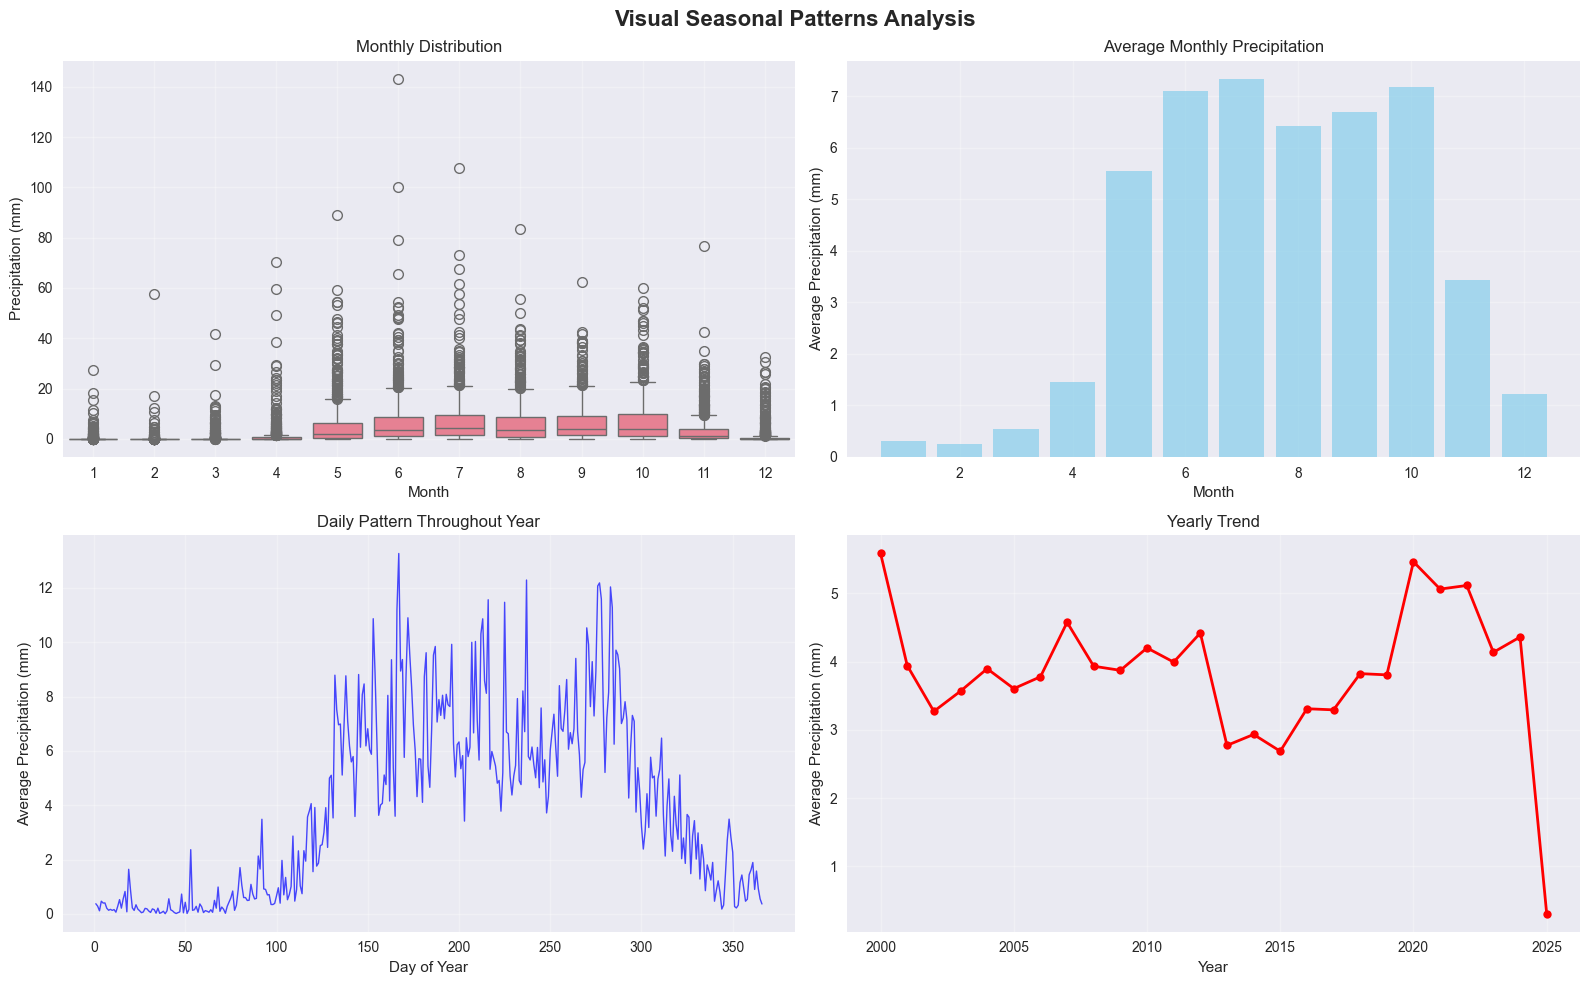

   🌧️ Wet Season (months): [6, 7, 10]
   ☀️ Dry Season (months): [1, 2, 3]

🔊 Step 2: Frequency Domain Analysis for Period Detection
--------------------------------------------------
   📊 Detected 10 dominant periods for MSTL:
      - 28.9 days
      - 20.2 days
      - 20.5 days
      - 26.7 days
      - 19.5 days
      - 24.4 days
      - 19.1 days
      - 15.6 days
      - 15.8 days
      - 24.5 days

📊 Step 3: MSTL Decomposition with Detected Periods
--------------------------------------------------
   🔄 Applied log1p transformation
   ✅ MSTL decomposition completed successfully

📈 Step 4a: Trend & Cyclical Analysis
--------------------------------------------------


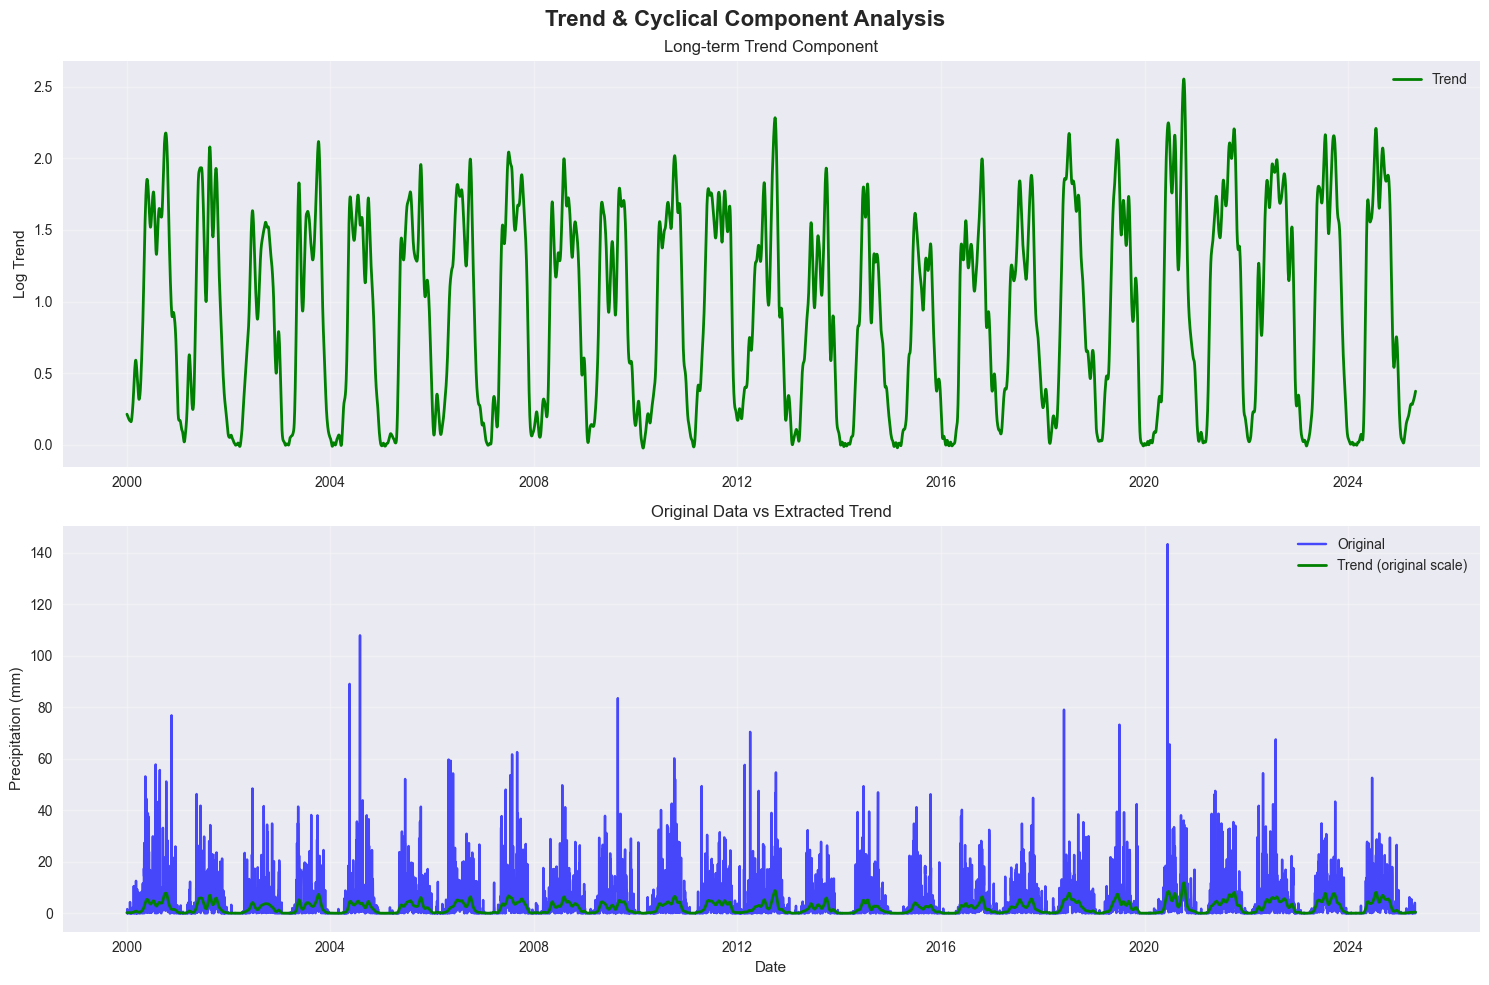

   📊 Trend Analysis:
      - Direction: Increasing
      - Slope: 0.000011 log-units per day
      - Annual change: 0.004 log-units per year
   🔄 Cyclical patterns (after detrending):
      - Detrended data range: -8.05 to 135.10 mm
      - Variability: 6.91 mm (std)

🌀 Step 4b: Seasonal Components Analysis
--------------------------------------------------


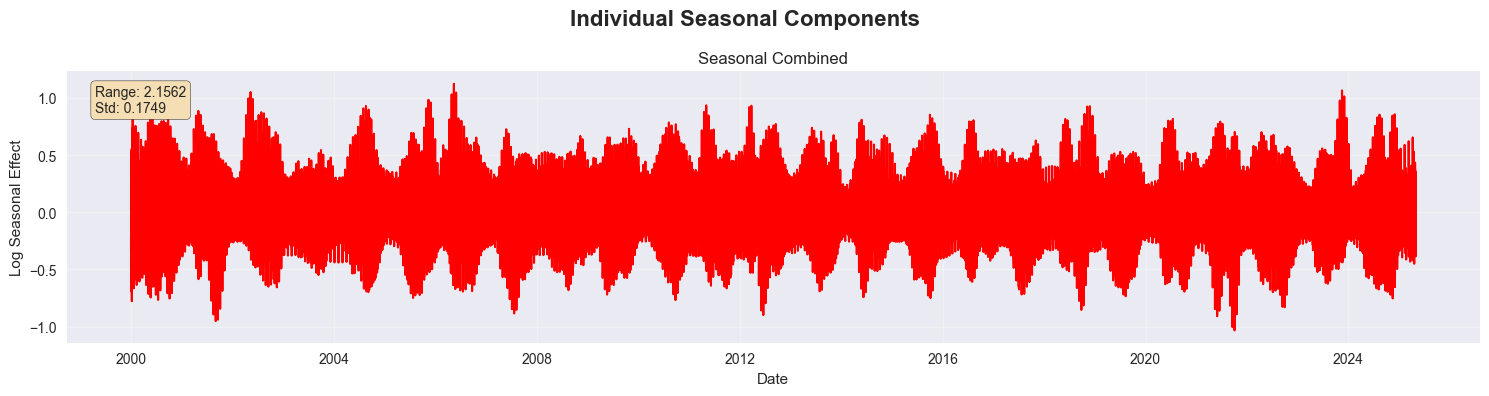

   📊 Seasonal Components Summary:
      - seasonal_combined: strength = 0.1749

🔍 Step 4c: Residual Diagnostic Analysis
--------------------------------------------------
   📊 Residual Statistics:
      - Mean: -0.000031
      - Std: 0.455610
      - Skewness: 0.296682
      - Kurtosis: 0.416888


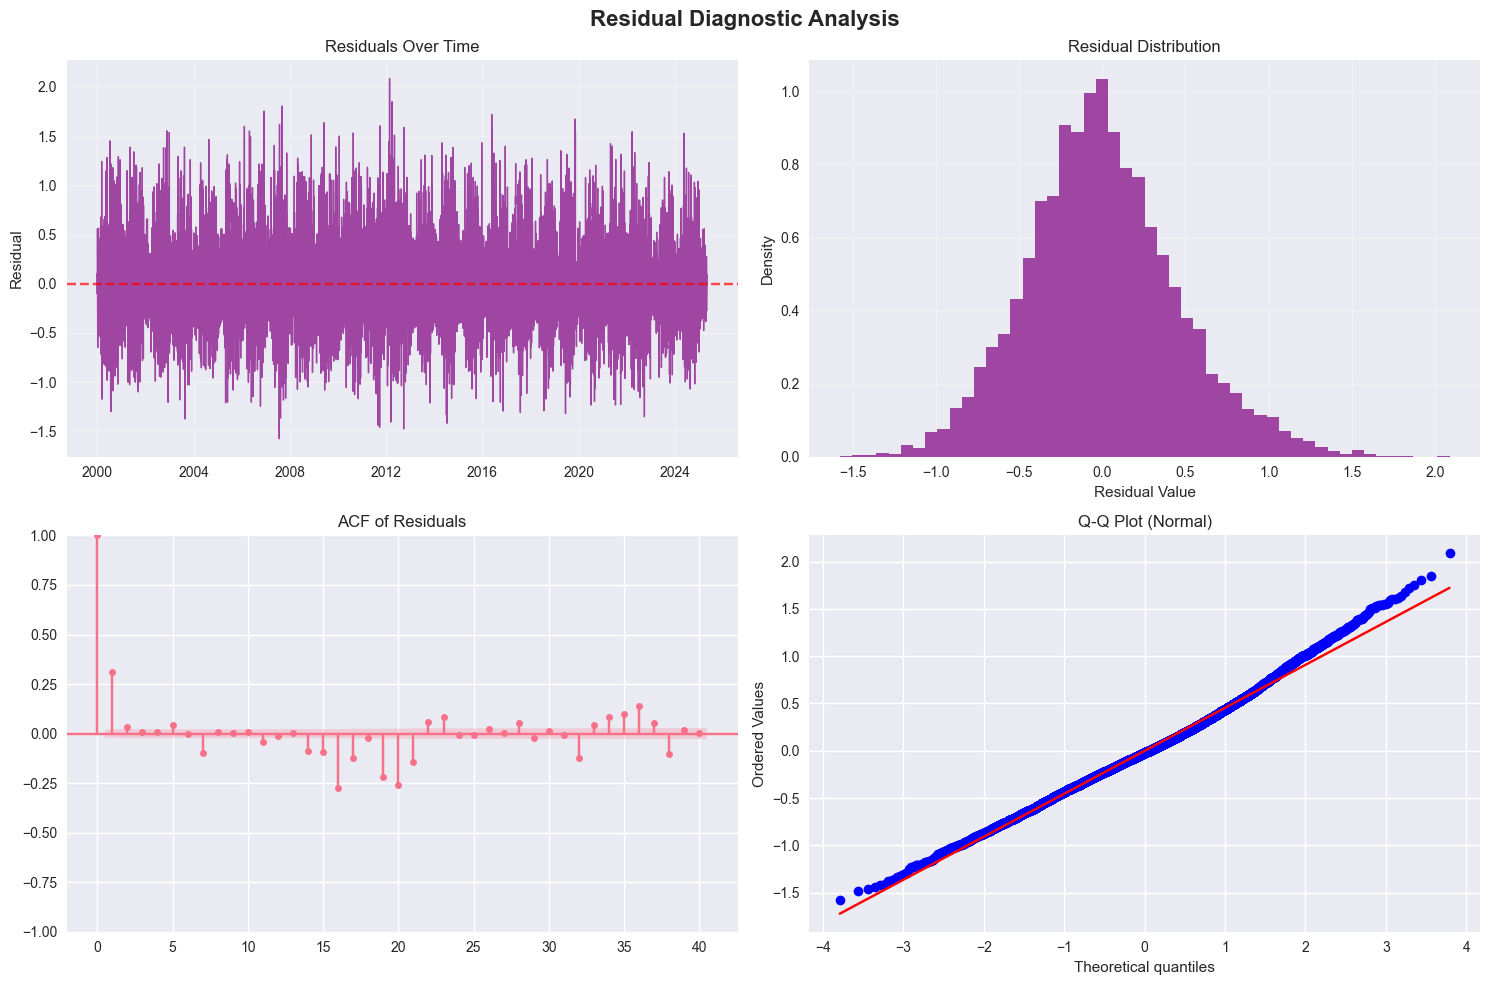

   🧪 Ljung-Box Test Results:
      ⚠️ Significant autocorrelation detected at 10 lags
      - First significant lag: 1

🌊 Step 5: Wavelet Analysis (PyWavelets)
--------------------------------------------------
   📊 Using last 3 years (1095 days) for analysis
   🔄 Running Continuous Wavelet Transform with PyWavelets...
   ✅ PyWavelets analysis completed


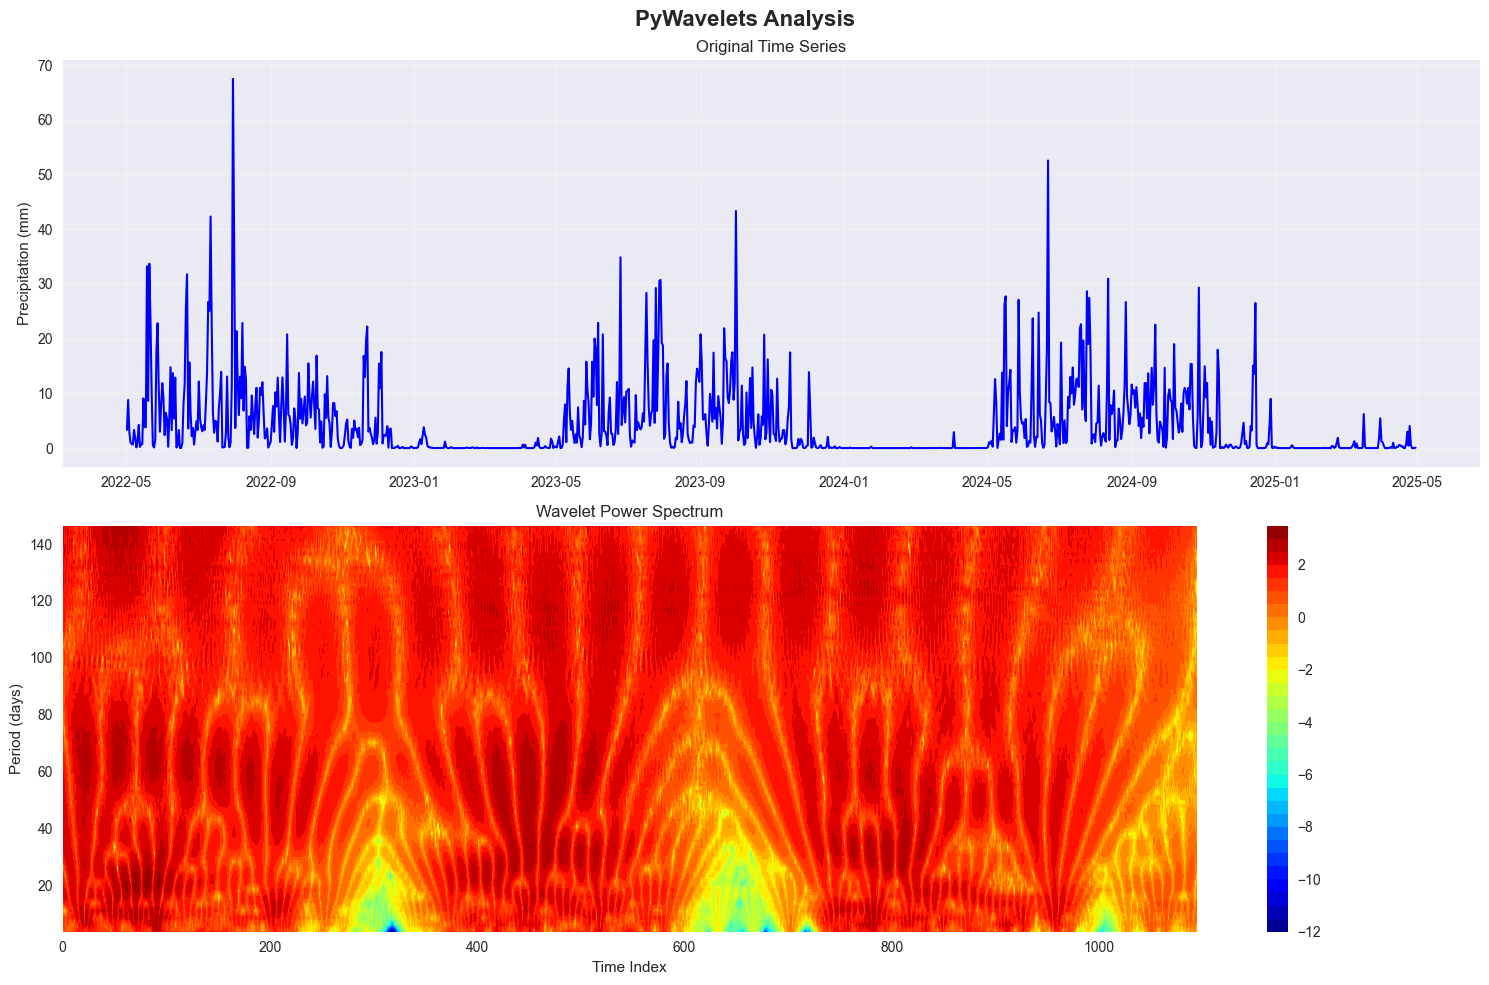

   📊 PyWavelets Insights:
      - Dominant periods: 5
        1. 62.8 days
        2. 57.8 days
        3. 60.3 days

✅ TEMPORAL STRUCTURE ANALYSIS COMPLETED
✅ Enhanced Temporal Structure Analysis completed:
   - Visual patterns: ✅
   - Frequency analysis: ✅
   - MSTL decomposition: ✅
   - Trend analysis: ✅
   - Seasonal analysis: ✅
   - Residual diagnostics: ✅
   - Wavelet Analysis using PyWavelets: ✅


In [7]:
# Initialize the enhanced analyzer
analyzer = WeatherEDAAnalyzer(df_all, target_col='Lượng mưa', date_col='Ngày')

# Run comprehensive temporal structure analysis
temporal_results = analyzer.run_temporal_structure_analysis()

# Access results
if temporal_results['mstl_decomposition']['success']:
    print("✅ Enhanced Temporal Structure Analysis completed:")
    print(f"   - Visual patterns: ✅")
    print(f"   - Frequency analysis: ✅")
    print(f"   - MSTL decomposition: ✅")
    print(f"   - Trend analysis: ✅")
    print(f"   - Seasonal analysis: ✅")
    print(f"   - Residual diagnostics: ✅")
    print(f"   - Wavelet Analysis using PyWavelets: ✅")

### refactor

In [ ]:
# =============================================================================
# REFACTORED TEMPORAL STRUCTURE ANALYZER - MODULAR ANALYSIS & VISUALIZATION
# =============================================================================

from typing import Dict, List, Tuple, Any, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
from scipy.stats import probplot
import warnings
warnings.filterwarnings('ignore')

class TemporalStructureAnalyzer(BaseAnalyzer):
    """
    Refactored: Separated Analysis and Visualization for Flexible Experimentation
    4 Main Analysis-Visualization Pairs:
    1. Seasonal Patterns (groupby-based)
    2. Frequency Analysis (FFT-based) 
    3. MSTL Decomposition
    4. Component Diagnostics (Trend/Seasonal/Residual)
    """
    
    def __init__(self, df: pd.DataFrame, target_col: str = 'Lượng mưa', date_col: str = 'Ngày'):
        """Initialize with type hints and validation"""
        super().__init__(df, target_col, date_col)
        self._validate_data()
    
    def _validate_data(self) -> None:
        """Validate data for temporal analysis"""
        if len(self.df) < 365:
            raise ValueError("Insufficient data for temporal analysis (need >= 365 days)")
        
        if self.target_col not in self.df.columns:
            raise ValueError(f"Target column '{self.target_col}' not found")

    # =============================================================================
    # PAIR 1: SEASONAL PATTERNS ANALYSIS & VISUALIZATION
    # =============================================================================
    
    def analyze_seasonal_patterns(self, 
                                 time_units: List[str] = ['Month', 'DayOfYear', 'Year'],
                                 agg_functions: List[str] = ['mean', 'std', 'median', 'count'],
                                 quantile_threshold: float = 0.75) -> Dict[str, Any]:
        """
        PURE ANALYSIS: Seasonal pattern analysis with configurable parameters
        
        Args:
            time_units: Time aggregation units ['Month', 'DayOfYear', 'Year']
            agg_functions: Aggregation functions ['mean', 'std', 'median', 'count']
            quantile_threshold: Threshold for wet/dry season definition (0.6-0.9)
            
        Returns:
            Dict containing all seasonal analysis results
        """
        print(f"🔍 Analyzing Seasonal Patterns")
        print(f"   - Time units: {time_units}")
        print(f"   - Aggregations: {agg_functions}")
        print(f"   - Quantile threshold: {quantile_threshold}")
        
        results = {}
        
        # Monthly analysis
        if 'Month' in time_units:
            monthly_stats = self.df.groupby('Month')[self.target_col].agg(agg_functions).round(4)
            monthly_mean = self.df.groupby('Month')[self.target_col].mean()
            
            # Season identification with configurable threshold
            wet_months = monthly_mean[monthly_mean > monthly_mean.quantile(quantile_threshold)].index.tolist()
            dry_months = monthly_mean[monthly_mean < monthly_mean.quantile(1 - quantile_threshold)].index.tolist()
            
            results['monthly'] = {
                'stats': monthly_stats,
                'mean': monthly_mean,
                'wet_months': wet_months,
                'dry_months': dry_months,
                'threshold_used': quantile_threshold
            }
        
        # Daily pattern within year
        if 'DayOfYear' in time_units:
            daily_pattern = self.df.groupby('DayOfYear')[self.target_col].agg(agg_functions)
            results['daily_pattern'] = daily_pattern
        
        # Yearly analysis
        if 'Year' in time_units:
            yearly_stats = self.df.groupby('Year')[self.target_col].agg(agg_functions)
            results['yearly'] = yearly_stats
        
        print(f"   ✅ Seasonal analysis completed")
        return results
    
    def plot_seasonal_patterns(self, 
                              seasonal_results: Dict[str, Any],
                              figsize: Tuple[int, int] = (16, 10),
                              color_scheme: str = 'default',
                              show_grid: bool = True,
                              suptitle: str = 'Seasonal Patterns Analysis') -> None:
        """
        PURE VISUALIZATION: Plot seasonal patterns with configurable parameters
        
        Args:
            seasonal_results: Results from analyze_seasonal_patterns()
            figsize: Figure size tuple
            color_scheme: 'default', 'viridis', 'plasma', etc.
            show_grid: Whether to show grid
            suptitle: Main title for the plot
        """
        # Color scheme selection
        colors = {
            'default': ['skyblue', 'lightgreen', 'coral', 'lightpink'],
            'viridis': plt.cm.viridis([0.2, 0.4, 0.6, 0.8]),
            'plasma': plt.cm.plasma([0.2, 0.4, 0.6, 0.8])
        }
        plot_colors = colors.get(color_scheme, colors['default'])
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(suptitle, fontsize=16, fontweight='bold')
        
        # Monthly boxplot
        if 'monthly' in seasonal_results:
            sns.boxplot(data=self.df, x='Month', y=self.target_col, ax=axes[0,0])
            axes[0,0].set_title('Monthly Distribution')
            axes[0,0].set_xlabel('Month')
            axes[0,0].set_ylabel('Precipitation (mm)')
            if show_grid:
                axes[0,0].grid(True, alpha=0.3)
        
        # Monthly average
        if 'monthly' in seasonal_results:
            monthly_mean = seasonal_results['monthly']['mean']
            axes[0,1].bar(monthly_mean.index, monthly_mean.values, 
                         color=plot_colors[0], alpha=0.7)
            axes[0,1].set_title('Average Monthly Precipitation')
            axes[0,1].set_xlabel('Month')
            axes[0,1].set_ylabel('Average Precipitation (mm)')
            if show_grid:
                axes[0,1].grid(True, alpha=0.3)
        
        # Daily pattern within year
        if 'daily_pattern' in seasonal_results:
            daily_pattern = seasonal_results['daily_pattern']['mean']
            axes[1,0].plot(daily_pattern.index, daily_pattern.values, 
                          color=plot_colors[1], linewidth=1.5, alpha=0.8)
            axes[1,0].set_title('Daily Pattern Throughout Year')
            axes[1,0].set_xlabel('Day of Year')
            axes[1,0].set_ylabel('Average Precipitation (mm)')
            if show_grid:
                axes[1,0].grid(True, alpha=0.3)
        
        # Yearly trend
        if 'yearly' in seasonal_results:
            yearly_mean = seasonal_results['yearly']['mean']
            axes[1,1].plot(yearly_mean.index, yearly_mean.values, 
                          'o-', color=plot_colors[2], linewidth=2, markersize=6)
            axes[1,1].set_title('Yearly Trend')
            axes[1,1].set_xlabel('Year')
            axes[1,1].set_ylabel('Average Precipitation (mm)')
            if show_grid:
                axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print insights
        if 'monthly' in seasonal_results:
            wet_months = seasonal_results['monthly']['wet_months']
            dry_months = seasonal_results['monthly']['dry_months']
            threshold = seasonal_results['monthly']['threshold_used']
            print(f"🌧️ Wet Season (>{threshold*100:.0f}th percentile): {wet_months}")
            print(f"☀️ Dry Season (<{(1-threshold)*100:.0f}th percentile): {dry_months}")

    # =============================================================================
    # PAIR 2: FREQUENCY ANALYSIS (FFT) & VISUALIZATION
    # =============================================================================
    
    def analyze_fft(self, 
                   detrend_window: int = 30,
                   top_n: int = 10,
                   period_range: Tuple[int, int] = (7, 730),
                   method: str = 'fft') -> Dict[str, Any]:
        """
        PURE ANALYSIS: FFT-based frequency analysis with configurable parameters
        
        Args:
            detrend_window: Window size for trend removal
            top_n: Number of top periods to find
            period_range: Valid period range (min_days, max_days)
            method: 'fft' or 'welch' for PSD estimation
            
        Returns:
            Dict containing FFT analysis results
        """
        print(f"🔊 FFT Frequency Analysis")
        print(f"   - Detrend window: {detrend_window}")
        print(f"   - Top periods: {top_n}")
        print(f"   - Period range: {period_range}")
        
        # Prepare time series
        ts_data = self.df.set_index(self.date_col).sort_index()
        target_ts = ts_data[self.target_col].dropna()
        
        if len(target_ts) < period_range[1]:
            print(f"   ⚠️ Insufficient data for frequency analysis")
            return {'success': False, 'error': 'Insufficient data'}
        
        # Detrend with configurable window
        detrended = target_ts - target_ts.rolling(window=detrend_window, center=True).mean()
        detrended = detrended.dropna()
        
        # Perform FFT
        fft_values = fft(detrended.values)
        frequencies = fftfreq(len(detrended), d=1)
        
        # Get positive frequencies
        positive_freq_idx = frequencies > 0
        positive_frequencies = frequencies[positive_freq_idx]
        positive_fft_magnitude = np.abs(fft_values[positive_freq_idx])
        periods = 1 / positive_frequencies
        
        # Find dominant periods with configurable range
        peak_indices = np.argsort(positive_fft_magnitude)[-top_n:]
        dominant_periods = periods[peak_indices]
        
        # Filter by period range
        valid_periods = dominant_periods[
            (dominant_periods >= period_range[0]) & 
            (dominant_periods <= period_range[1])
        ]
        
        # Sort and convert to integers
        dominant_periods_int = sorted(list(set(np.round(valid_periods).astype(int))))
        
        print(f"   📊 Found {len(dominant_periods_int)} dominant periods:")
        for period in dominant_periods_int[:5]:  # Show top 5
            print(f"      - {period} days")
        
        return {
            'success': True,
            'dominant_periods': dominant_periods_int,
            'all_periods': periods,
            'magnitudes': positive_fft_magnitude,
            'frequencies': positive_frequencies,
            'detrended_series': detrended,
            'parameters': {
                'detrend_window': detrend_window,
                'top_n': top_n,
                'period_range': period_range
            }
        }
    
    def plot_spectrum(self, 
                     fft_results: Dict[str, Any],
                     figsize: Tuple[int, int] = (15, 8),
                     show_dominant: bool = True,
                     max_period: int = 365,
                     log_scale: bool = True) -> None:
        """
        PURE VISUALIZATION: Plot frequency spectrum with configurable parameters
        
        Args:
            fft_results: Results from analyze_fft()
            figsize: Figure size
            show_dominant: Whether to highlight dominant periods
            max_period: Maximum period to show
            log_scale: Whether to use log scale for power
        """
        if not fft_results['success']:
            print("❌ Cannot plot spectrum: FFT analysis failed")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle('Frequency Domain Analysis', fontsize=16, fontweight='bold')
        
        periods = fft_results['all_periods']
        magnitudes = fft_results['magnitudes']
        dominant_periods = fft_results['dominant_periods']
        
        # Filter by max_period
        valid_idx = periods <= max_period
        periods_plot = periods[valid_idx]
        magnitudes_plot = magnitudes[valid_idx]
        
        # Power Spectral Density
        power = magnitudes_plot ** 2
        if log_scale:
            power = np.log10(power + 1e-12)
            ylabel = 'Log Power Spectral Density'
        else:
            ylabel = 'Power Spectral Density'
        
        axes[0].plot(periods_plot, power, 'b-', alpha=0.7, linewidth=1)
        axes[0].set_xlabel('Period (days)')
        axes[0].set_ylabel(ylabel)
        axes[0].set_title('Power Spectral Density')
        axes[0].grid(True, alpha=0.3)
        
        # Highlight dominant periods
        if show_dominant:
            for period in dominant_periods[:5]:  # Top 5
                if period <= max_period:
                    period_idx = np.argmin(np.abs(periods_plot - period))
                    axes[0].axvline(x=period, color='red', linestyle='--', alpha=0.7)
                    axes[0].text(period, power[period_idx], f'{period}d', 
                               rotation=90, verticalalignment='bottom')
        
        # Dominant periods bar chart
        top_5_periods = dominant_periods[:5]
        top_5_power = []
        for period in top_5_periods:
            if period <= max_period:
                period_idx = np.argmin(np.abs(periods_plot - period))
                top_5_power.append(power[period_idx])
            else:
                top_5_power.append(0)
        
        axes[1].bar(range(len(top_5_periods)), top_5_power, alpha=0.7)
        axes[1].set_xlabel('Rank')
        axes[1].set_ylabel(ylabel)
        axes[1].set_title('Top Dominant Periods')
        axes[1].set_xticks(range(len(top_5_periods)))
        axes[1].set_xticklabels([f'{p}d' for p in top_5_periods])
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    # =============================================================================
    # PAIR 3: MSTL DECOMPOSITION & VISUALIZATION
    # =============================================================================
    
    def decompose_mstl(self, 
                      periods: List[int],
                      transform: str = 'log1p',
                      seasonal_deg: int = 1,
                      trend_deg: int = 1) -> Dict[str, Any]:
        """
        PURE ANALYSIS: MSTL decomposition with configurable parameters
        
        Args:
            periods: List of seasonal periods for decomposition
            transform: 'log1p', 'log', 'none'
            seasonal_deg: Degree of seasonal smoother
            trend_deg: Degree of trend smoother
            
        Returns:
            Dict containing MSTL decomposition results
        """
        print(f"📊 MSTL Decomposition")
        print(f"   - Periods: {periods}")
        print(f"   - Transform: {transform}")
        
        try:
            from statsmodels.tsa.seasonal import MSTL
            
            # Prepare time series
            ts_data = self.df.set_index(self.date_col).sort_index()
            target_ts = ts_data[self.target_col].dropna()
            
            # Apply transformation
            if transform == 'log1p':
                transformed_ts = np.log1p(target_ts)
            elif transform == 'log':
                transformed_ts = np.log(target_ts + 1e-8)
            else:
                transformed_ts = target_ts
            
            print(f"   🔄 Applied {transform} transformation")
            
            # Run MSTL decomposition
            mstl = MSTL(transformed_ts, 
                       periods=periods,
                       seasonal_deg=seasonal_deg,
                       trend_deg=trend_deg)
            mstl_result = mstl.fit()
            
            print(f"   ✅ MSTL decomposition completed")
            
            return {
                'success': True,
                'mstl_obj': mstl_result,
                'original_ts': target_ts,
                'transformed_ts': transformed_ts,
                'periods': periods,
                'trend': mstl_result.trend,
                'seasonal': mstl_result.seasonal,
                'resid': mstl_result.resid,
                'transform': transform,
                'parameters': {
                    'seasonal_deg': seasonal_deg,
                    'trend_deg': trend_deg
                }
            }
            
        except Exception as e:
            print(f"   ⚠️ MSTL decomposition failed: {e}")
            return {
                'success': False,
                'error': str(e),
                'periods': periods
            }
    
    def plot_decomposition(self, 
                          mstl_results: Dict[str, Any],
                          figsize: Tuple[int, int] = (15, 12),
                          show_components: List[str] = ['trend', 'seasonal', 'resid'],
                          original_scale: bool = True) -> None:
        """
        PURE VISUALIZATION: Plot MSTL decomposition with configurable parameters
        
        Args:
            mstl_results: Results from decompose_mstl()
            figsize: Figure size
            show_components: Components to show ['trend', 'seasonal', 'resid']
            original_scale: Whether to convert back to original scale
        """
        if not mstl_results['success']:
            print("❌ Cannot plot decomposition: MSTL failed")
            return
        
        mstl_obj = mstl_results['mstl_obj']
        transform = mstl_results['transform']
        
        # Determine number of subplots
        n_plots = 1 + len(show_components)  # Original + components
        
        fig, axes = plt.subplots(n_plots, 1, figsize=figsize)
        if n_plots == 1:
            axes = [axes]
        
        fig.suptitle('MSTL Decomposition Results', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        
        # Original series
        if original_scale and transform in ['log1p', 'log']:
            if transform == 'log1p':
                original_data = np.expm1(mstl_results['transformed_ts'])
            else:
                original_data = np.exp(mstl_results['transformed_ts'])
            axes[plot_idx].plot(original_data.index, original_data.values, 'b-', linewidth=1)
            axes[plot_idx].set_title('Original Data (Original Scale)')
            axes[plot_idx].set_ylabel('Precipitation (mm)')
        else:
            axes[plot_idx].plot(mstl_results['transformed_ts'].index, 
                               mstl_results['transformed_ts'].values, 'b-', linewidth=1)
            axes[plot_idx].set_title(f'Original Data ({transform} scale)')
            axes[plot_idx].set_ylabel(f'{transform} Precipitation')
        
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Trend component
        if 'trend' in show_components:
            trend = mstl_results['trend']
            axes[plot_idx].plot(trend.index, trend.values, 'g-', linewidth=2)
            axes[plot_idx].set_title('Trend Component')
            axes[plot_idx].set_ylabel(f'{transform} Trend')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
        
        # Seasonal component
        if 'seasonal' in show_components:
            seasonal = mstl_results['seasonal']
            axes[plot_idx].plot(seasonal.index, seasonal.values, 'r-', linewidth=1)
            axes[plot_idx].set_title('Combined Seasonal Component')
            axes[plot_idx].set_ylabel(f'{transform} Seasonal')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
        
        # Residual component
        if 'resid' in show_components:
            resid = mstl_results['resid']
            axes[plot_idx].plot(resid.index, resid.values, 'purple', linewidth=1, alpha=0.7)
            axes[plot_idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[plot_idx].set_title('Residual Component')
            axes[plot_idx].set_ylabel(f'{transform} Residual')
            axes[plot_idx].grid(True, alpha=0.3)
            plot_idx += 1
        
        axes[-1].set_xlabel('Date')
        plt.tight_layout()
        plt.show()

    # =============================================================================
    # PAIR 4: COMPONENT DIAGNOSTICS & VISUALIZATION (TREND, SEASONAL, RESIDUAL)
    # =============================================================================
    
    def analyze_trend(self, 
                     trend_series: pd.Series,
                     slope_method: str = 'polyfit',
                     min_data_points: int = 100) -> Dict[str, Any]:
        """
        PURE ANALYSIS: Trend component analysis
        
        Args:
            trend_series: Trend component from MSTL
            slope_method: 'polyfit', 'linear_regression', 'theil_sen'
            min_data_points: Minimum points for analysis
            
        Returns:
            Dict containing trend analysis results
        """
        print(f"📈 Trend Analysis - Method: {slope_method}")
        
        trend_clean = trend_series.dropna()
        
        if len(trend_clean) < min_data_points:
            return {
                'success': False,
                'error': f'Insufficient data points ({len(trend_clean)} < {min_data_points})'
            }
        
        # Calculate trend slope based on method
        x_numeric = np.arange(len(trend_clean))
        
        if slope_method == 'polyfit':
            slope, intercept = np.polyfit(x_numeric, trend_clean.values, 1)
        elif slope_method == 'linear_regression':
            from sklearn.linear_model import LinearRegression
            lr = LinearRegression()
            lr.fit(x_numeric.reshape(-1, 1), trend_clean.values)
            slope = lr.coef_[0]
            intercept = lr.intercept_
        elif slope_method == 'theil_sen':
            from sklearn.linear_model import TheilSenRegressor
            ts_reg = TheilSenRegressor()
            ts_reg.fit(x_numeric.reshape(-1, 1), trend_clean.values)
            slope = ts_reg.coef_[0]
            intercept = ts_reg.intercept_
        else:
            raise ValueError(f"Unknown slope method: {slope_method}")
        
        # Determine trend direction
        if abs(slope) < 1e-6:
            trend_direction = "Stable"
        elif slope > 0:
            trend_direction = "Increasing"
        else:
            trend_direction = "Decreasing"
        
        # Calculate trend statistics
        trend_stats = {
            'slope': slope,
            'intercept': intercept,
            'direction': trend_direction,
            'annual_change': slope * 365,
            'method_used': slope_method,
            'data_points': len(trend_clean),
            'trend_range': (trend_clean.min(), trend_clean.max()),
            'trend_std': trend_clean.std()
        }
        
        print(f"   - Direction: {trend_direction}")
        print(f"   - Slope: {slope:.6f} units/day")
        print(f"   - Annual change: {slope * 365:.3f} units/year")
        
        return {
            'success': True,
            'trend_component': trend_clean,
            'trend_stats': trend_stats
        }
    
    def diagnose_residuals(self, 
                          residual_series: pd.Series,
                          ljung_box_lags: int = 10,
                          normality_tests: bool = True) -> Dict[str, Any]:
        """
        PURE ANALYSIS: Residual diagnostic analysis
        
        Args:
            residual_series: Residual component from MSTL
            ljung_box_lags: Number of lags for Ljung-Box test
            normality_tests: Whether to perform normality tests
            
        Returns:
            Dict containing residual diagnostic results
        """
        print(f"🔍 Residual Diagnostics")
        print(f"   - Ljung-Box lags: {ljung_box_lags}")
        
        residuals = residual_series.dropna()
        
        if len(residuals) < 50:
            return {
                'success': False,
                'error': f'Insufficient residual data ({len(residuals)} < 50)'
            }
        
        # Basic residual statistics
        residual_stats = {
            'count': len(residuals),
            'mean': residuals.mean(),
            'std': residuals.std(),
            'skewness': residuals.skew(),
            'kurtosis': residuals.kurtosis(),
            'min': residuals.min(),
            'max': residuals.max()
        }
        
        # Ljung-Box test for autocorrelation
        ljung_box_results = None
        autocorr_clean = None
        
        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox
            ljung_box_result = acorr_ljungbox(residuals, lags=ljung_box_lags, return_df=True)
            significant_lags = ljung_box_result[ljung_box_result['lb_pvalue'] < 0.05]
            
            ljung_box_results = {
                'test_results': ljung_box_result,
                'significant_lags': len(significant_lags),
                'first_significant_lag': significant_lags.index[0] if len(significant_lags) > 0 else None
            }
            
            autocorr_clean = len(significant_lags) == 0
            
        except Exception as e:
            print(f"   ⚠️ Ljung-Box test failed: {e}")
            ljung_box_results = {'error': str(e)}
        
        # Normality tests
        normality_results = {}
        if normality_tests:
            try:
                from scipy.stats import shapiro, jarque_bera
                
                # Shapiro-Wilk test (for smaller samples)
                if len(residuals) <= 5000:
                    shapiro_stat, shapiro_p = shapiro(residuals.values)
                    normality_results['shapiro'] = {
                        'statistic': shapiro_stat,
                        'p_value': shapiro_p,
                        'is_normal': shapiro_p > 0.05
                    }
                
                # Jarque-Bera test
                jb_stat, jb_p = jarque_bera(residuals.values)
                normality_results['jarque_bera'] = {
                    'statistic': jb_stat,
                    'p_value': jb_p,
                    'is_normal': jb_p > 0.05
                }
                
            except Exception as e:
                normality_results['error'] = str(e)
        
        print(f"   - Mean: {residual_stats['mean']:.6f}")
        print(f"   - Std: {residual_stats['std']:.6f}")
        if ljung_box_results and 'significant_lags' in ljung_box_results:
            if autocorr_clean:
                print(f"   ✅ No significant autocorrelation")
            else:
                print(f"   ⚠️ Autocorrelation detected at {ljung_box_results['significant_lags']} lags")
        
        return {
            'success': True,
            'residuals': residuals,
            'residual_stats': residual_stats,
            'ljung_box_results': ljung_box_results,
            'normality_results': normality_results,
            'autocorr_clean': autocorr_clean
        }
    
    def plot_residual_diagnostics(self, 
                                 residual_results: Dict[str, Any],
                                 figsize: Tuple[int, int] = (15, 10),
                                 acf_lags: int = 40,
                                 hist_bins: int = 50,
                                 layout: str = '2x2') -> None:
        """
        PURE VISUALIZATION: Plot residual diagnostics with configurable parameters
        
        Args:
            residual_results: Results from diagnose_residuals()
            figsize: Figure size
            acf_lags: Number of lags for ACF plot
            hist_bins: Number of bins for histogram
            layout: '2x2', '3x2', '1x4'
        """
        if not residual_results['success']:
            print("❌ Cannot plot diagnostics: Residual analysis failed")
            return
        
        residuals = residual_results['residuals']
        
        # Determine subplot layout
        if layout == '2x2':
            nrows, ncols = 2, 2
        elif layout == '3x2':
            nrows, ncols = 3, 2
        elif layout == '1x4':
            nrows, ncols = 1, 4
        else:
            nrows, ncols = 2, 2
        
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        fig.suptitle('Residual Diagnostic Analysis', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        
        # Time series plot
        axes[plot_idx].plot(residuals.index, residuals.values, 'purple', alpha=0.7, linewidth=1)
        axes[plot_idx].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        axes[plot_idx].set_title('Residuals Over Time')
        axes[plot_idx].set_ylabel('Residual')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # Histogram
        axes[plot_idx].hist(residuals.values, bins=hist_bins, alpha=0.7, 
                           color='purple', density=True, edgecolor='black')
        axes[plot_idx].set_title('Residual Distribution')
        axes[plot_idx].set_xlabel('Residual Value')
        axes[plot_idx].set_ylabel('Density')
        axes[plot_idx].grid(True, alpha=0.3)
        plot_idx += 1
        
        # ACF plot
        try:
            from statsmodels.graphics.tsaplots import plot_acf
            plot_acf(residuals, ax=axes[plot_idx], lags=acf_lags, alpha=0.05)
            axes[plot_idx].set_title(f'ACF of Residuals (lags={acf_lags})')
        except Exception as e:
            axes[plot_idx].set_title('ACF Plot Not Available')
            axes[plot_idx].text(0.5, 0.5, f'Error: {str(e)}', 
                               transform=axes[plot_idx].transAxes, ha='center')
        plot_idx += 1
        
        # Q-Q plot
        try:
            probplot(residuals.values, dist="norm", plot=axes[plot_idx])
            axes[plot_idx].set_title('Q-Q Plot (Normal)')
        except Exception as e:
            axes[plot_idx].set_title('Q-Q Plot Not Available')
            axes[plot_idx].text(0.5, 0.5, f'Error: {str(e)}', 
                               transform=axes[plot_idx].transAxes, ha='center')
        plot_idx += 1
        
        # Additional plots for extended layout
        if layout == '3x2' and plot_idx < len(axes):
            # PACF plot
            try:
                from statsmodels.graphics.tsaplots import plot_pacf
                plot_pacf(residuals, ax=axes[plot_idx], lags=acf_lags//2, alpha=0.05)
                axes[plot_idx].set_title('PACF of Residuals')
            except:
                axes[plot_idx].set_title('PACF Plot Not Available')
            plot_idx += 1
            
            # Box plot
            if plot_idx < len(axes):
                axes[plot_idx].boxplot(residuals.values)
                axes[plot_idx].set_title('Residual Box Plot')
                axes[plot_idx].set_ylabel('Residual Value')
        
        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Print diagnostic summary
        stats = residual_results['residual_stats']
        print(f"\n📊 Residual Summary:")
        print(f"   - Count: {stats['count']:,}")
        print(f"   - Mean: {stats['mean']:.6f}")
        print(f"   - Std: {stats['std']:.6f}")
        print(f"   - Skewness: {stats['skewness']:.4f}")
        print(f"   - Kurtosis: {stats['kurtosis']:.4f}")
        
        if 'normality_results' in residual_results:
            norm_results = residual_results['normality_results']
            if 'jarque_bera' in norm_results:
                jb = norm_results['jarque_bera']
                print(f"   - Jarque-Bera normality: {'✅ Normal' if jb['is_normal'] else '❌ Non-normal'} (p={jb['p_value']:.4f})")

    # =============================================================================
    # MAIN ORCHESTRATION METHODS
    # =============================================================================
    
    def analyze(self) -> Dict[str, Any]:
        """
        Main analysis method - calls individual analysis functions with default parameters
        
        Returns:
            Dict containing all analysis results
        """
        print("\n" + "="*70)
        print("🕐 ENHANCED TEMPORAL STRUCTURE ANALYSIS (REFACTORED)")
        print("="*70)
        
        # Step 1: Seasonal patterns analysis
        seasonal_results = self.analyze_seasonal_patterns()
        
        # Step 2: FFT frequency analysis
        fft_results = self.analyze_fft()
        
        # Step 3: MSTL decomposition
        periods = fft_results.get('dominant_periods', [7, 30, 365])[:3]  # Use top 3
        mstl_results = self.decompose_mstl(periods)
        
        # Step 4: Component diagnostics
        trend_results = {}
        residual_results = {}
        
        if mstl_results['success']:
            trend_results = self.analyze_trend(mstl_results['trend'])
            residual_results = self.diagnose_residuals(mstl_results['resid'])
        
        # Combine all results
        results = {
            'seasonal_patterns': seasonal_results,
            'frequency_analysis': fft_results,
            'mstl_decomposition': mstl_results,
            'trend_analysis': trend_results,
            'residual_analysis': residual_results,
            'component_name': 'TemporalStructureAnalyzer_Refactored'
        }
        
        print(f"\n✅ ENHANCED TEMPORAL ANALYSIS COMPLETED")
        return results
    
    def visualize_all(self, 
                     results: Dict[str, Any],
                     components: List[str] = None,
                     **viz_params) -> None:
        """
        Visualize all components with configurable parameters
        
        Args:
            results: Results from analyze()
            components: Components to visualize ['seasonal', 'spectrum', 'decomposition', 'residual']
            **viz_params: Additional visualization parameters
        """
        if components is None:
            components = ['seasonal', 'spectrum', 'decomposition', 'residual']
        
        if 'seasonal' in components:
            print("\n🌱 Visualizing Seasonal Patterns...")
            self.plot_seasonal_patterns(results['seasonal_patterns'], **viz_params)
        
        if 'spectrum' in components and results['frequency_analysis']['success']:
            print("\n📊 Visualizing Frequency Spectrum...")
            self.plot_spectrum(results['frequency_analysis'], **viz_params)
        
        if 'decomposition' in components and results['mstl_decomposition']['success']:
            print("\n📈 Visualizing MSTL Decomposition...")
            self.plot_decomposition(results['mstl_decomposition'], **viz_params)
        
        if 'residual' in components and results['residual_analysis'].get('success'):
            print("\n🔍 Visualizing Residual Diagnostics...")
            self.plot_residual_diagnostics(results['residual_analysis'], **viz_params)

In [ ]:
# =============================================================================
# CELL 1: ANALYSIS WITH DIFFERENT PARAMETERS
# =============================================================================

# Initialize analyzer
analyzer = TemporalStructureAnalyzer(df_all, target_col='Lượng mưa', date_col='Ngày')

# Experiment 1: Different seasonal thresholds
seasonal_results_75 = analyzer.analyze_seasonal_patterns(quantile_threshold=0.75)
seasonal_results_85 = analyzer.analyze_seasonal_patterns(quantile_threshold=0.85)

# Experiment 2: Different FFT parameters  
fft_results_7day = analyzer.analyze_fft(detrend_window=7, top_n=15)
fft_results_60day = analyzer.analyze_fft(detrend_window=60, top_n=15)

# Experiment 3: Different MSTL setups
mstl_auto = analyzer.decompose_mstl(fft_results_7day['dominant_periods'][:3])
mstl_manual = analyzer.decompose_mstl([7, 30, 365])

In [ ]:
# =============================================================================
# CELL 2: VISUALIZATION COMPARISONS
# =============================================================================

# Compare seasonal analysis with different thresholds
analyzer.plot_seasonal_patterns(seasonal_results_75, 
                                suptitle='Seasonal Patterns (75th percentile threshold)')

analyzer.plot_seasonal_patterns(seasonal_results_85, 
                                color_scheme='viridis',
                                suptitle='Seasonal Patterns (85th percentile threshold)')

# Compare FFT results
analyzer.plot_spectrum(fft_results_7day, show_dominant=True, max_period=200)
analyzer.plot_spectrum(fft_results_60day, show_dominant=True, max_period=200)

In [ ]:
# =============================================================================
# CELL 3: RESIDUAL DIAGNOSTICS WITH DIFFERENT LAYOUTS
# =============================================================================

# Different residual diagnostic approaches
residual_results = analyzer.diagnose_residuals(mstl_auto['resid'], ljung_box_lags=15)

# Standard 2x2 layout
analyzer.plot_residual_diagnostics(residual_results, layout='2x2', acf_lags=40)

# Extended 3x2 layout with more diagnostics
analyzer.plot_residual_diagnostics(residual_results, layout='3x2', acf_lags=60, hist_bins=30)

## Stationarity & Autocorrelation

In [8]:
# =============================================================================
# COMPONENT 3: STATIONARITY & AUTOCORRELATION DIAGNOSTICS (COMBINED)
# =============================================================================

class StationarityAutocorrelationAnalyzer(BaseAnalyzer):
    """
    Phần 3: Chẩn đoán Tính dừng và Tự tương quan
    Kết hợp StationarityAnalyzer + AutocorrelationAnalyzer
    """

    def __init__(self, df, target_col='Lượng mưa', date_col='Ngày', mstl_results=None):
        """Initialize with optional MSTL results from Part 2"""
        super().__init__(df, target_col, date_col)
        self.mstl_results = mstl_results

    def analyze(self):
        """
        Main workflow: Stationarity → Autocorrelation → Diagnostics
        """
        print("\n" + "="*80)
        print("🔍 PHẦN 3: STATIONARITY & AUTOCORRELATION DIAGNOSTICS")
        print("="*80)
        print("🎯 Mục tiêu: Chẩn đoán tính dừng và cấu trúc tự tương quan")

        # Prepare time series data
        ts_data = self.df.set_index(self.date_col).sort_index()
        target_ts = ts_data[self.target_col].dropna()

        if len(target_ts) < 50:
            print("   ⚠️ Insufficient data for comprehensive diagnostics")
            return {'success': False, 'error': 'Insufficient data'}

        # Step 1: Stationarity Diagnostics
        stationarity_results = self._stationarity_diagnostics(target_ts)

        # Step 2: Autocorrelation Analysis
        autocorr_results = self._autocorrelation_analysis(target_ts)

        # Step 3: Residual Diagnostics (if MSTL results available)
        residual_results = self._residual_diagnostics() if self.mstl_results else None

        # Step 4: Comprehensive Synthesis
        synthesis = self._comprehensive_synthesis(stationarity_results, autocorr_results, residual_results)

        # Combine all results
        results = {
            'stationarity': stationarity_results,
            'autocorrelation': autocorr_results,
            'residual_diagnostics': residual_results,
            'synthesis': synthesis,
            'component_name': 'StationarityAutocorrelationAnalyzer'
        }

        return results

    def _stationarity_diagnostics(self, target_ts):
        """Bước 1: Chẩn đoán Tính dừng"""
        print(f"\n🔍 BƯỚC 1: CHẨN ĐOÁN TÍNH DỪNG")
        print("="*60)

        # ADF Test
        adf_results = self._perform_adf_test(target_ts)

        # KPSS Test
        kpss_results = self._perform_kpss_test(target_ts)

        # Combined Assessment
        assessment = self._stationarity_assessment(adf_results, kpss_results)

        # Visual Analysis
        self._visual_stationarity_analysis(target_ts)

        return {
            'adf_test': adf_results,
            'kpss_test': kpss_results,
            'assessment': assessment,
            'success': True
        }

    def _autocorrelation_analysis(self, target_ts):
        """Bước 2: Phân tích Tự tương quan"""
        print(f"\n🔄 BƯỚC 2: PHÂN TÍCH TỰ TƯƠNG QUAN")
        print("="*60)

        # ACF Analysis on original series
        acf_results = self._perform_acf_analysis(target_ts, "Original Series")

        # PACF Analysis on original series
        pacf_results = self._perform_pacf_analysis(target_ts, "Original Series")

        # SARIMA Suggestions
        sarima_suggestions = self._generate_sarima_suggestions(acf_results, pacf_results)

        # Visualization
        self._autocorrelation_visualization(target_ts, "Original Series")

        return {
            'acf_results': acf_results,
            'pacf_results': pacf_results,
            'sarima_suggestions': sarima_suggestions,
            'success': True
        }

    def _residual_diagnostics(self):
        """Bước 2b: Chẩn đoán Residual từ MSTL"""
        if not self.mstl_results or 'residual' not in self.mstl_results:
            print(f"\n⚠️ MSTL results not available for residual diagnostics")
            return {'success': False, 'error': 'No MSTL results'}

        print(f"\n🧪 BƯỚC 2B: CHẨN ĐOÁN RESIDUAL MSTL")
        print("="*60)

        residual = self.mstl_results['residual'].dropna()

        if len(residual) < 50:
            return {'success': False, 'error': 'Insufficient residual data'}

        # ACF/PACF of residuals
        residual_acf = self._perform_acf_analysis(residual, "MSTL Residual")
        residual_pacf = self._perform_pacf_analysis(residual, "MSTL Residual")

        # Ljung-Box Test for residual randomness
        ljung_box_results = self._ljung_box_test(residual)

        # Residual visualization
        self._residual_visualization(residual)

        return {
            'residual_acf': residual_acf,
            'residual_pacf': residual_pacf,
            'ljung_box': ljung_box_results,
            'quality_assessment': self._assess_mstl_quality(residual_acf, ljung_box_results),
            'success': True
        }

    def _comprehensive_synthesis(self, stationarity_results, autocorr_results, residual_results):
        """Bước 4: Tổng hợp & Kết luận"""
        print(f"\n📋 BƯỚC 4: TỔNG HỢP & KẾT LUẬN")
        print("="*60)

        # Extract key findings
        is_stationary = stationarity_results['assessment']['tests_agree']
        stationarity_type = stationarity_results['assessment']['stationarity_type']
        significant_lags = autocorr_results['acf_results']['significant_lags'][:5]
        seasonal_lags = [lag for lag, _ in significant_lags if lag in [7, 14, 30, 365]]

        # Generate synthesis report
        synthesis_report = {
            'stationarity_conclusion': stationarity_type,
            'differencing_needed': not is_stationary,
            'significant_lags': [lag for lag, _ in significant_lags],
            'seasonal_lags_detected': seasonal_lags,
            'model_recommendations': []
        }

        # Model recommendations
        if is_stationary:
            synthesis_report['model_recommendations'].append("ARMA models suitable")
        else:
            synthesis_report['model_recommendations'].append("ARIMA models recommended (d=1)")

        if seasonal_lags:
            synthesis_report['model_recommendations'].append("SARIMA models for seasonal patterns")

        # MSTL Quality Assessment
        if residual_results and residual_results['success']:
            mstl_quality = residual_results['quality_assessment']
            synthesis_report['mstl_decomposition_quality'] = mstl_quality

            if mstl_quality['overall_quality'] == 'Good':
                synthesis_report['model_recommendations'].append("MSTL decomposition captured most patterns")
            else:
                synthesis_report['model_recommendations'].append("Additional AR/MA terms may be needed")

        # Print synthesis
        print(f"   📊 PHÁT HIỆN CHÍNH:")
        print(f"      🔹 Tính dừng: {stationarity_type}")
        print(f"      🔹 Cần sai phân: {'Có' if synthesis_report['differencing_needed'] else 'Không'}")
        print(f"      🔹 Lags quan trọng: {synthesis_report['significant_lags'][:5]}")
        print(f"      🔹 Lags mùa vụ: {seasonal_lags}")

        print(f"\n   💡 KHUYẾN NGHỊ MÔ HÌNH:")
        for rec in synthesis_report['model_recommendations']:
            print(f"      • {rec}")

        return synthesis_report

    # Helper methods from original components
    def _perform_adf_test(self, ts):
        """ADF Test implementation"""
        try:
            from statsmodels.tsa.stattools import adfuller
            result = adfuller(ts, regression='ct', autolag='AIC')

            print(f"   📊 ADF Test:")
            print(f"      - Statistic: {result[0]:.6f}")
            print(f"      - P-value: {result[1]:.6f}")
            print(f"      - Result: {'✅ Stationary' if result[1] < 0.05 else '❌ Non-stationary'}")

            return {
                'statistic': result[0],
                'pvalue': result[1],
                'critical_values': result[4],
                'is_stationary': result[1] < 0.05,
                'success': True
            }
        except Exception as e:
            return {'success': False, 'error': str(e)}

    def _perform_kpss_test(self, ts):
        """KPSS Test implementation"""
        try:
            from statsmodels.tsa.stattools import kpss
            result = kpss(ts, regression='ct')

            print(f"   📊 KPSS Test:")
            print(f"      - Statistic: {result[0]:.6f}")
            print(f"      - P-value: {result[1]:.6f}")
            print(f"      - Result: {'✅ Stationary' if result[1] > 0.05 else '❌ Non-stationary'}")

            return {
                'statistic': result[0],
                'pvalue': result[1],
                'critical_values': result[3],
                'is_stationary': result[1] > 0.05,
                'success': True
            }
        except Exception as e:
            return {'success': False, 'error': str(e)}

    def _stationarity_assessment(self, adf, kpss):
        """Combined stationarity assessment"""
        adf_stat = adf.get('is_stationary', False)
        kpss_stat = kpss.get('is_stationary', False)

        if adf_stat and kpss_stat:
            conclusion = "✅ STATIONARY"
            stationarity_type = "Stationary"
        elif adf_stat and not kpss_stat:
            conclusion = "🟡 DIFFERENCE STATIONARY"
            stationarity_type = "Difference Stationary"
        elif not adf_stat and kpss_stat:
            conclusion = "🟡 TREND STATIONARY"
            stationarity_type = "Trend Stationary"
        else:
            conclusion = "❌ NON-STATIONARY"
            stationarity_type = "Non-stationary"

        print(f"   🎯 Kết luận: {conclusion}")

        return {
            'conclusion': conclusion,
            'stationarity_type': stationarity_type,
            'tests_agree': adf_stat == kpss_stat,
            'adf_agrees': adf_stat,
            'kpss_agrees': kpss_stat
        }

    def _perform_acf_analysis(self, ts, label):
        """ACF Analysis implementation"""
        try:
            max_lags = min(100, len(ts) // 4)
            acf_values, acf_confint = acf(ts, nlags=max_lags, alpha=0.05, fft=True)

            # Find significant lags
            significant_lags = []
            for lag in range(1, len(acf_values)):
                if abs(acf_values[lag]) > abs(acf_confint[lag, 1] - acf_values[lag]):
                    significant_lags.append((lag, acf_values[lag]))

            print(f"   📈 ACF ({label}) - Significant lags: {len(significant_lags)}")

            return {
                'acf_values': acf_values,
                'significant_lags': significant_lags,
                'max_lags': max_lags,
                'success': True
            }
        except Exception as e:
            return {'success': False, 'error': str(e)}

    def _perform_pacf_analysis(self, ts, label):
        """PACF Analysis implementation"""
        try:
            max_lags = min(100, len(ts) // 4)
            pacf_values, pacf_confint = pacf(ts, nlags=max_lags, alpha=0.05)

            # Find significant lags
            significant_lags = []
            for lag in range(1, len(pacf_values)):
                if abs(pacf_values[lag]) > abs(pacf_confint[lag, 1] - pacf_values[lag]):
                    significant_lags.append((lag, pacf_values[lag]))

            print(f"   📈 PACF ({label}) - Significant lags: {len(significant_lags)}")

            return {
                'pacf_values': pacf_values,
                'significant_lags': significant_lags,
                'max_lags': max_lags,
                'success': True
            }
        except Exception as e:
            return {'success': False, 'error': str(e)}

    def _generate_sarima_suggestions(self, acf_results, pacf_results):
        """Generate SARIMA parameter suggestions"""
        if not (acf_results['success'] and pacf_results['success']):
            return {'success': False}

        # Extract significant lags
        pacf_lags = [lag for lag, _ in pacf_results['significant_lags'][:5]]
        acf_lags = [lag for lag, _ in acf_results['significant_lags'][:5]]

        # Simple heuristics for SARIMA orders
        p = min(3, len(pacf_lags)) if pacf_lags else 1
        q = min(3, len(acf_lags)) if acf_lags else 1

        # Seasonal parameters (check for seasonal lags)
        seasonal_lags = [lag for lag in pacf_lags + acf_lags if lag in [7, 14, 30, 365]]
        P = 1 if seasonal_lags else 0
        Q = 1 if seasonal_lags else 0
        s = max(seasonal_lags) if seasonal_lags else 0

        suggestions = {
            'nonseasonal_ar': p,
            'nonseasonal_ma': q,
            'seasonal_ar': P,
            'seasonal_ma': Q,
            'seasonal_period': s,
            'suggested_models': [
                f'SARIMA({p},1,{q})x({P},1,{Q},{s})' if s > 0 else f'ARIMA({p},1,{q})',
                f'SARIMA({p},0,{q})x({P},0,{Q},{s})' if s > 0 else f'ARIMA({p},0,{q})'
            ],
            'success': True
        }

        print(f"   🎯 SARIMA Suggestions: {suggestions['suggested_models']}")
        return suggestions

    def _ljung_box_test(self, residual):
        """Ljung-Box test for residual randomness"""
        try:
            from statsmodels.stats.diagnostic import acorr_ljungbox

            lbvalue = acorr_ljungbox(residual, lags=min(20, len(residual)//4), return_df=True)
            pvalue_min = lbvalue['lb_pvalue'].min()

            print(f"   🧪 Ljung-Box Test:")
            print(f"      - Min p-value: {pvalue_min:.6f}")
            print(f"      - Result: {'✅ Random residuals' if pvalue_min > 0.05 else '⚠️ Some structure remains'}")

            return {
                'ljung_box_results': lbvalue,
                'min_pvalue': float(pvalue_min),
                'is_random': pvalue_min > 0.05,
                'success': True
            }
        except Exception as e:
            return {'success': False, 'error': str(e)}

    def _assess_mstl_quality(self, residual_acf, ljung_box):
        """Assess MSTL decomposition quality"""
        if not (residual_acf['success'] and ljung_box['success']):
            return {'overall_quality': 'Unknown', 'reasons': ['Analysis failed']}

        significant_residual_lags = len(residual_acf['significant_lags'])
        is_random = ljung_box['is_random']

        if is_random and significant_residual_lags < 5:
            quality = 'Good'
            reasons = ['Residuals appear random', 'Few significant autocorrelations']
        elif is_random or significant_residual_lags < 10:
            quality = 'Moderate'
            reasons = ['Some structure may remain', 'Consider additional AR/MA terms']
        else:
            quality = 'Poor'
            reasons = ['Significant structure in residuals', 'MSTL may be insufficient']

        print(f"   📊 MSTL Quality: {quality}")
        for reason in reasons:
            print(f"      • {reason}")

        return {
            'overall_quality': quality,
            'reasons': reasons,
            'significant_lags_count': significant_residual_lags,
            'residuals_random': is_random
        }

    def _visual_stationarity_analysis(self, target_ts):
        """Visual stationarity analysis"""
        window = min(365, len(target_ts) // 4)
        rolling_mean = target_ts.rolling(window=window).mean()
        rolling_std = target_ts.rolling(window=window).std()

        fig, axes = plt.subplots(2, 2, figsize=(16, 8))
        fig.suptitle('Stationarity Visual Diagnostics', fontsize=14, fontweight='bold')

        # Original + Rolling Mean
        axes[0,0].plot(target_ts.index, target_ts.values, 'b-', alpha=0.6, label='Original')
        axes[0,0].plot(rolling_mean.index, rolling_mean.values, 'r-', linewidth=2, label=f'Rolling Mean ({window}d)')
        axes[0,0].set_title('Time Series with Rolling Mean')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Rolling Std
        axes[0,1].plot(rolling_std.index, rolling_std.values, 'g-', linewidth=2)
        axes[0,1].set_title(f'Rolling Standard Deviation ({window}d)')
        axes[0,1].grid(True, alpha=0.3)

        # First Difference
        first_diff = target_ts.diff().dropna()
        axes[1,0].plot(first_diff.index, first_diff.values, 'purple', alpha=0.7)
        axes[1,0].set_title('First Difference')
        axes[1,0].grid(True, alpha=0.3)

        # Distribution Comparison
        axes[1,1].hist(target_ts.values, bins=30, alpha=0.7, label='Original', density=True)
        axes[1,1].hist(first_diff.values, bins=30, alpha=0.7, label='First Difference', density=True)
        axes[1,1].set_title('Distribution Comparison')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def _autocorrelation_visualization(self, ts, label):
        """ACF/PACF visualization"""
        max_lags = min(40, len(ts) // 4)

        fig, axes = plt.subplots(2, 2, figsize=(16, 8))
        fig.suptitle(f'Autocorrelation Analysis - {label}', fontsize=14, fontweight='bold')

        # ACF plot
        try:
            plot_acf(ts, lags=max_lags, ax=axes[0,0], alpha=0.05)
            axes[0,0].set_title(f'ACF - {label}')
            axes[0,0].grid(True, alpha=0.3)
        except:
            axes[0,0].text(0.5, 0.5, 'ACF Plot Error', ha='center', va='center', transform=axes[0,0].transAxes)

        # PACF plot
        try:
            plot_pacf(ts, lags=max_lags, ax=axes[0,1], alpha=0.05)
            axes[0,1].set_title(f'PACF - {label}')
            axes[0,1].grid(True, alpha=0.3)
        except:
            axes[0,1].text(0.5, 0.5, 'PACF Plot Error', ha='center', va='center', transform=axes[0,1].transAxes)

        # First difference ACF
        first_diff = ts.diff().dropna()
        if len(first_diff) > max_lags:
            try:
                plot_acf(first_diff, lags=max_lags, ax=axes[1,0], alpha=0.05)
                axes[1,0].set_title('ACF - First Difference')
                axes[1,0].grid(True, alpha=0.3)
            except:
                axes[1,0].text(0.5, 0.5, 'ACF Diff Error', ha='center', va='center', transform=axes[1,0].transAxes)

        # First difference PACF
        if len(first_diff) > max_lags:
            try:
                plot_pacf(first_diff, lags=max_lags, ax=axes[1,1], alpha=0.05)
                axes[1,1].set_title('PACF - First Difference')
                axes[1,1].grid(True, alpha=0.3)
            except:
                axes[1,1].text(0.5, 0.5, 'PACF Diff Error', ha='center', va='center', transform=axes[1,1].transAxes)

        plt.tight_layout()
        plt.show()

    def _residual_visualization(self, residual):
        """Residual diagnostics visualization"""
        max_lags = min(40, len(residual) // 4)

        fig, axes = plt.subplots(2, 2, figsize=(16, 8))
        fig.suptitle('MSTL Residual Diagnostics', fontsize=14, fontweight='bold')

        # Residual time series
        axes[0,0].plot(residual.index, residual.values, 'b-', alpha=0.7)
        axes[0,0].set_title('MSTL Residuals')
        axes[0,0].grid(True, alpha=0.3)

        # Residual distribution
        axes[0,1].hist(residual.values, bins=30, alpha=0.7, density=True)
        axes[0,1].set_title('Residual Distribution')
        axes[0,1].grid(True, alpha=0.3)

        # Residual ACF
        try:
            plot_acf(residual, lags=max_lags, ax=axes[1,0], alpha=0.05)
            axes[1,0].set_title('Residual ACF')
            axes[1,0].grid(True, alpha=0.3)
        except:
            axes[1,0].text(0.5, 0.5, 'ACF Error', ha='center', va='center', transform=axes[1,0].transAxes)

        # Residual PACF
        try:
            plot_pacf(residual, lags=max_lags, ax=axes[1,1], alpha=0.05)
            axes[1,1].set_title('Residual PACF')
            axes[1,1].grid(True, alpha=0.3)
        except:
            axes[1,1].text(0.5, 0.5, 'PACF Error', ha='center', va='center', transform=axes[1,1].transAxes)

        plt.tight_layout()
        plt.show()


🚀 WEATHER EDA ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa

🔍 PHẦN 3: STATIONARITY & AUTOCORRELATION DIAGNOSTICS
🎯 Mục tiêu: Chẩn đoán tính dừng và cấu trúc tự tương quan

🔍 BƯỚC 1: CHẨN ĐOÁN TÍNH DỪNG
   📊 ADF Test:
      - Statistic: -8.709252
      - P-value: 0.000000
      - Result: ✅ Stationary
   📊 KPSS Test:
      - Statistic: 0.072028
      - P-value: 0.100000
      - Result: ✅ Stationary
   🎯 Kết luận: ✅ STATIONARY


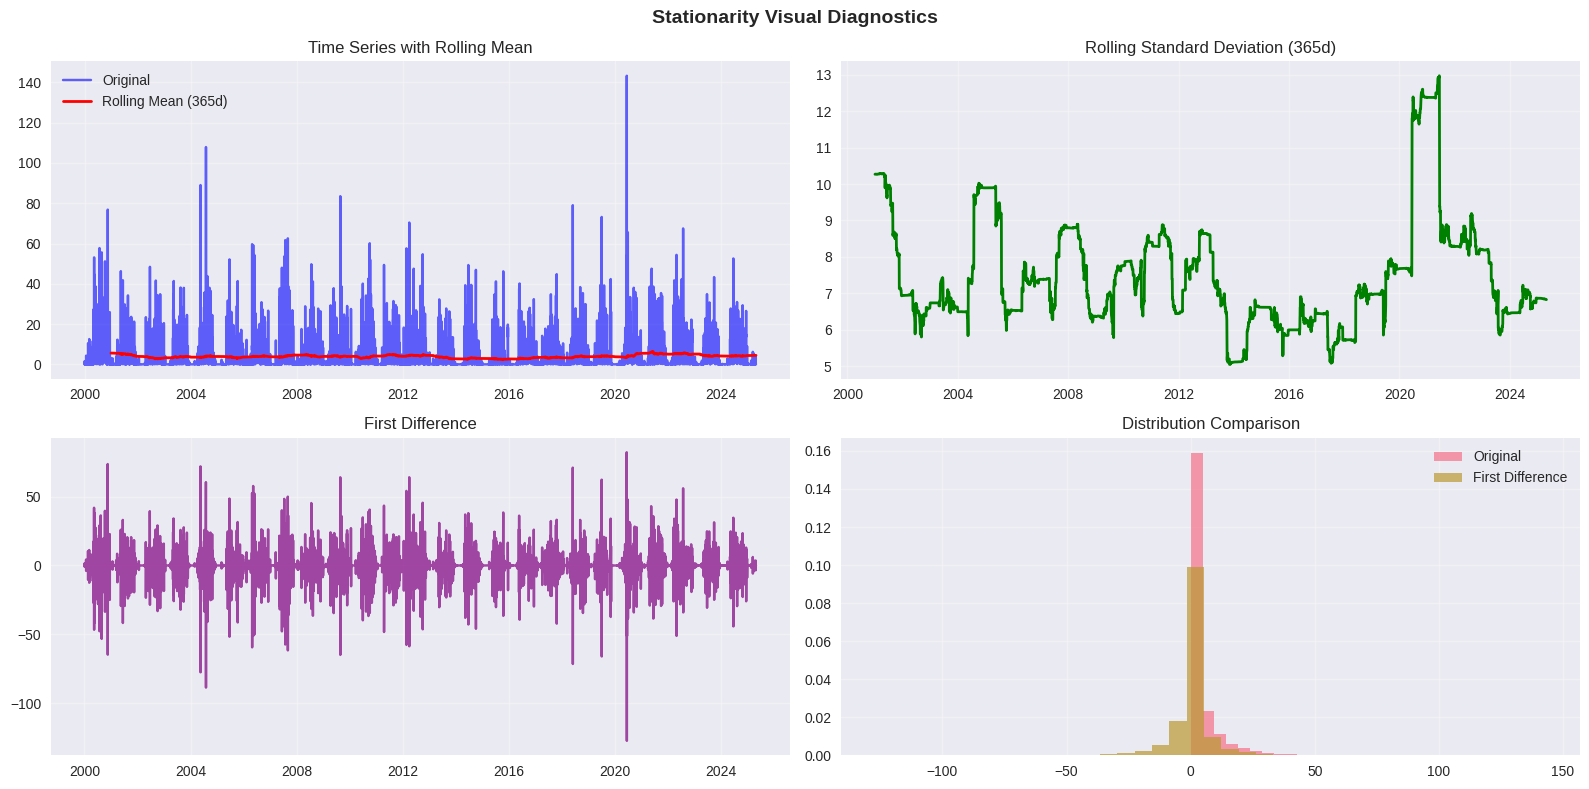


🔄 BƯỚC 2: PHÂN TÍCH TỰ TƯƠNG QUAN
   📈 ACF (Original Series) - Significant lags: 72
   📈 PACF (Original Series) - Significant lags: 30
   🎯 SARIMA Suggestions: ['ARIMA(3,1,3)', 'ARIMA(3,0,3)']


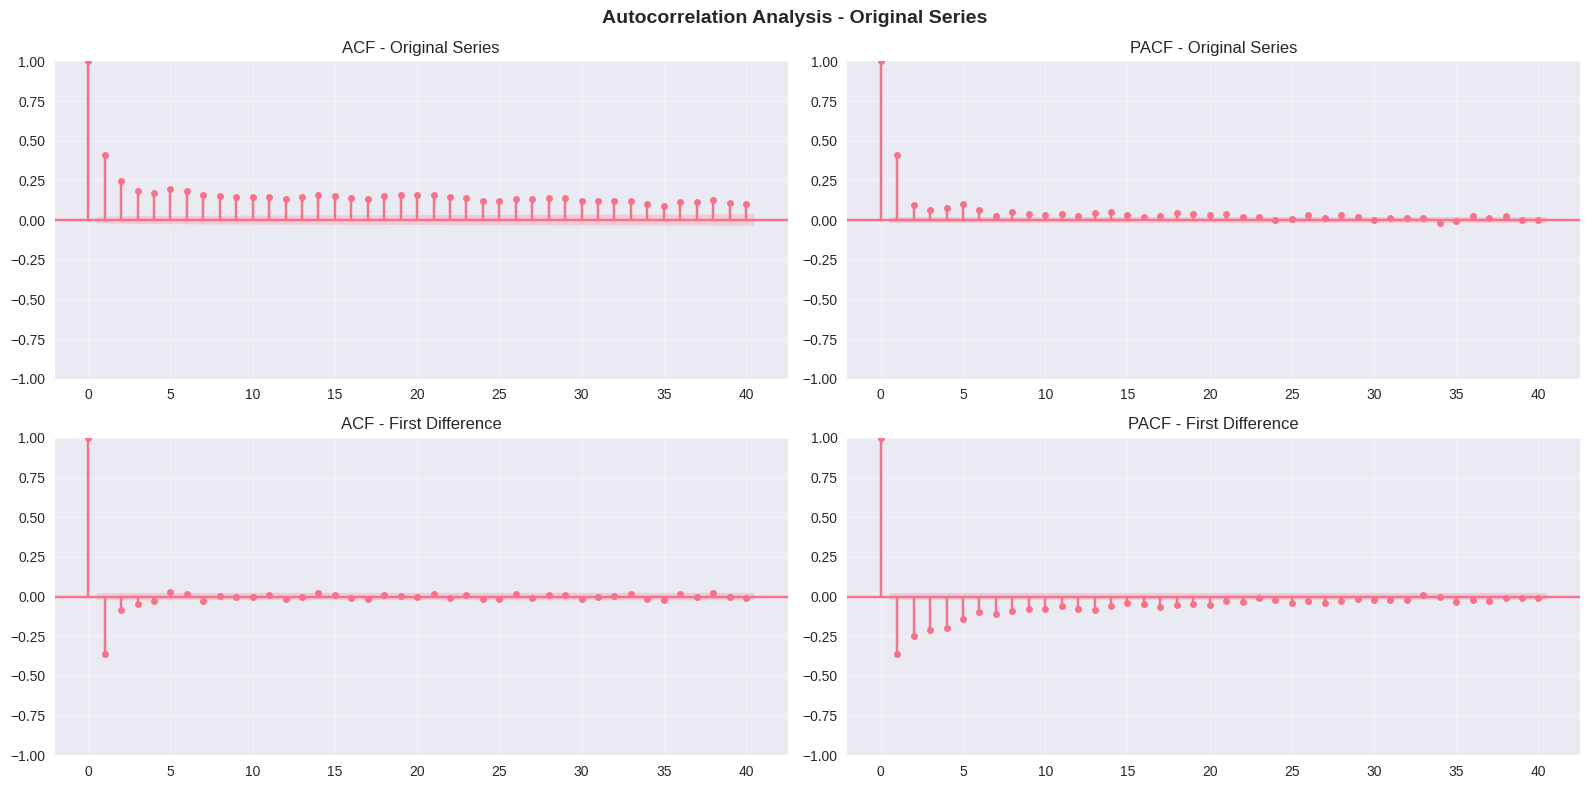


📋 BƯỚC 4: TỔNG HỢP & KẾT LUẬN
   📊 PHÁT HIỆN CHÍNH:
      🔹 Tính dừng: Stationary
      🔹 Cần sai phân: Không
      🔹 Lags quan trọng: [1, 2, 3, 4, 5]
      🔹 Lags mùa vụ: []

   💡 KHUYẾN NGHỊ MÔ HÌNH:
      • ARMA models suitable

🎯 KẾT QUẢ TỔNG HỢP:
   • Tình trạng: Stationary
   • Cần sai phân: False
   • Lags quan trọng: [1, 2, 3, 4, 5]
   • Khuyến nghị: ['ARMA models suitable']


In [ ]:
# Initialize analyzer
analyzer = WeatherEDAAnalyzer(df_all, target_col='Lượng mưa', date_col='Ngày')

# Run Phần 3: Stationarity & Autocorrelation Diagnostics
# (Có thể truyền mstl_results từ Phần 2 nếu có)
diagnostics_results = analyzer.run_stationarity_autocorr_analysis()

# Access comprehensive results
if diagnostics_results.get('synthesis'):
    synthesis = diagnostics_results['synthesis']
    print(f"\n🎯 KẾT QUẢ TỔNG HỢP:")
    print(f"   • Tình trạng: {synthesis['stationarity_conclusion']}")
    print(f"   • Cần sai phân: {synthesis['differencing_needed']}")
    print(f"   • Lags quan trọng: {synthesis['significant_lags'][:5]}")
    print(f"   • Khuyến nghị: {synthesis['model_recommendations']}")

## Extreme Even Analysis

In [ ]:
# =============================================================================
# COMPONENT 2: EXTREME EVENTS ANALYZER
# =============================================================================

class ExtremeEventsAnalyzer(BaseAnalyzer):
    """
    Component 2: Extreme Events Analysis
    """

    def analyze(self):
        """Run comprehensive extreme events analysis"""
        print("\n" + "="*70)
        print("⛈️ COMPONENT 2: EXTREME EVENTS ANALYSIS")
        print("="*70)

        # Run extreme events analysis
        extreme_definition = self._define_extreme_events()
        seasonal_patterns = self._seasonal_extreme_patterns()

        # Combine results
        results = {
            'extreme_definition': extreme_definition,
            'seasonal_patterns': seasonal_patterns,
            'component_name': 'ExtremeEventsAnalyzer'
        }

        return results

    def _define_extreme_events(self):
        """2.1 Define extreme events and thresholds"""
        print("🔍 2.1 Extreme Events Definition")
        print("-" * 50)

        # Define thresholds
        p95 = self.df[self.target_col].quantile(0.95)
        p99 = self.df[self.target_col].quantile(0.99)
        p99_9 = self.df[self.target_col].quantile(0.999)

        print(f"   📊 Extreme Event Thresholds:")
        print(f"      - 95th percentile: {p95:.2f}mm")
        print(f"      - 99th percentile: {p99:.2f}mm")
        print(f"      - 99.9th percentile: {p99_9:.2f}mm")

        # Count extreme events
        extreme_95 = (self.df[self.target_col] > p95).sum()
        extreme_99 = (self.df[self.target_col] > p99).sum()
        extreme_99_9 = (self.df[self.target_col] > p99_9).sum()

        print(f"\n   📈 Extreme Event Counts:")
        print(f"      - > 95th percentile: {extreme_95} events ({extreme_95/len(self.df)*100:.2f}%)")
        print(f"      - > 99th percentile: {extreme_99} events ({extreme_99/len(self.df)*100:.2f}%)")
        print(f"      - > 99.9th percentile: {extreme_99_9} events ({extreme_99_9/len(self.df)*100:.2f}%)")

        return {
            'thresholds': {'p95': p95, 'p99': p99, 'p99_9': p99_9},
            'extreme_counts': {'p95': extreme_95, 'p99': extreme_99, 'p99_9': extreme_99_9}
        }

    def _seasonal_extreme_patterns(self):
        """2.2 Seasonal patterns of extreme events"""
        print(f"\n🌪️ 2.2 Seasonal Patterns of Extreme Events")
        print("-" * 50)

        # Use 95th percentile as extreme threshold
        p95 = self.df[self.target_col].quantile(0.95)
        extreme_by_month = self.df[self.df[self.target_col] > p95].groupby('Month').size()

        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Extreme Events Analysis', fontsize=16, fontweight='bold')

        # Monthly extreme events
        axes[0,0].bar(extreme_by_month.index, extreme_by_month.values, color='red', alpha=0.7)
        axes[0,0].set_title(f'Extreme Events by Month (> {p95:.1f}mm)')
        axes[0,0].set_xlabel('Month')
        axes[0,0].set_ylabel('Number of Events')
        axes[0,0].grid(True, alpha=0.3)

        # Extreme events time series
        extreme_events = self.df[self.df[self.target_col] > p95]
        if len(extreme_events) > 0:
            axes[0,1].scatter(extreme_events[self.date_col], extreme_events[self.target_col],
                            color='red', alpha=0.7, s=30)
            axes[0,1].set_title('Extreme Events Over Time')
            axes[0,1].set_xlabel('Date')
            axes[0,1].set_ylabel('Precipitation (mm)')
            axes[0,1].grid(True, alpha=0.3)

        # Distribution of extreme events
        if len(extreme_events) > 0:
            axes[1,0].hist(extreme_events[self.target_col], bins=20, color='orange', alpha=0.7)
            axes[1,0].set_title('Distribution of Extreme Events')
            axes[1,0].set_xlabel('Precipitation (mm)')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].grid(True, alpha=0.3)

        # Return period analysis
        sorted_values = self.df[self.target_col].sort_values(ascending=False)
        return_periods = len(self.df) / (np.arange(1, len(sorted_values) + 1))
        axes[1,1].loglog(return_periods[:100], sorted_values.iloc[:100], 'bo-', markersize=4)
        axes[1,1].set_title('Return Period Analysis')
        axes[1,1].set_xlabel('Return Period (days)')
        axes[1,1].set_ylabel('Precipitation (mm)')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Peak extreme month
        peak_month = extreme_by_month.idxmax() if len(extreme_by_month) > 0 else None
        if peak_month:
            print(f"   📅 Peak extreme events month: {peak_month}")

        return {
            'extreme_by_month': extreme_by_month,
            'extreme_events_data': extreme_events,
            'peak_month': peak_month,
            'return_periods': return_periods[:100].tolist(),
            'sorted_values': sorted_values.iloc[:100].tolist()
        }


🚀 WEATHER EDA ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa

⛈️ COMPONENT 2: EXTREME EVENTS ANALYSIS
🔍 2.1 Extreme Events Definition
--------------------------------------------------
   📊 Extreme Event Thresholds:
      - 95th percentile: 18.45mm
      - 99th percentile: 34.86mm
      - 99.9th percentile: 67.01mm

   📈 Extreme Event Counts:
      - > 95th percentile: 463 events (5.00%)
      - > 99th percentile: 93 events (1.01%)
      - > 99.9th percentile: 10 events (0.11%)

🌪️ 2.2 Seasonal Patterns of Extreme Events
--------------------------------------------------


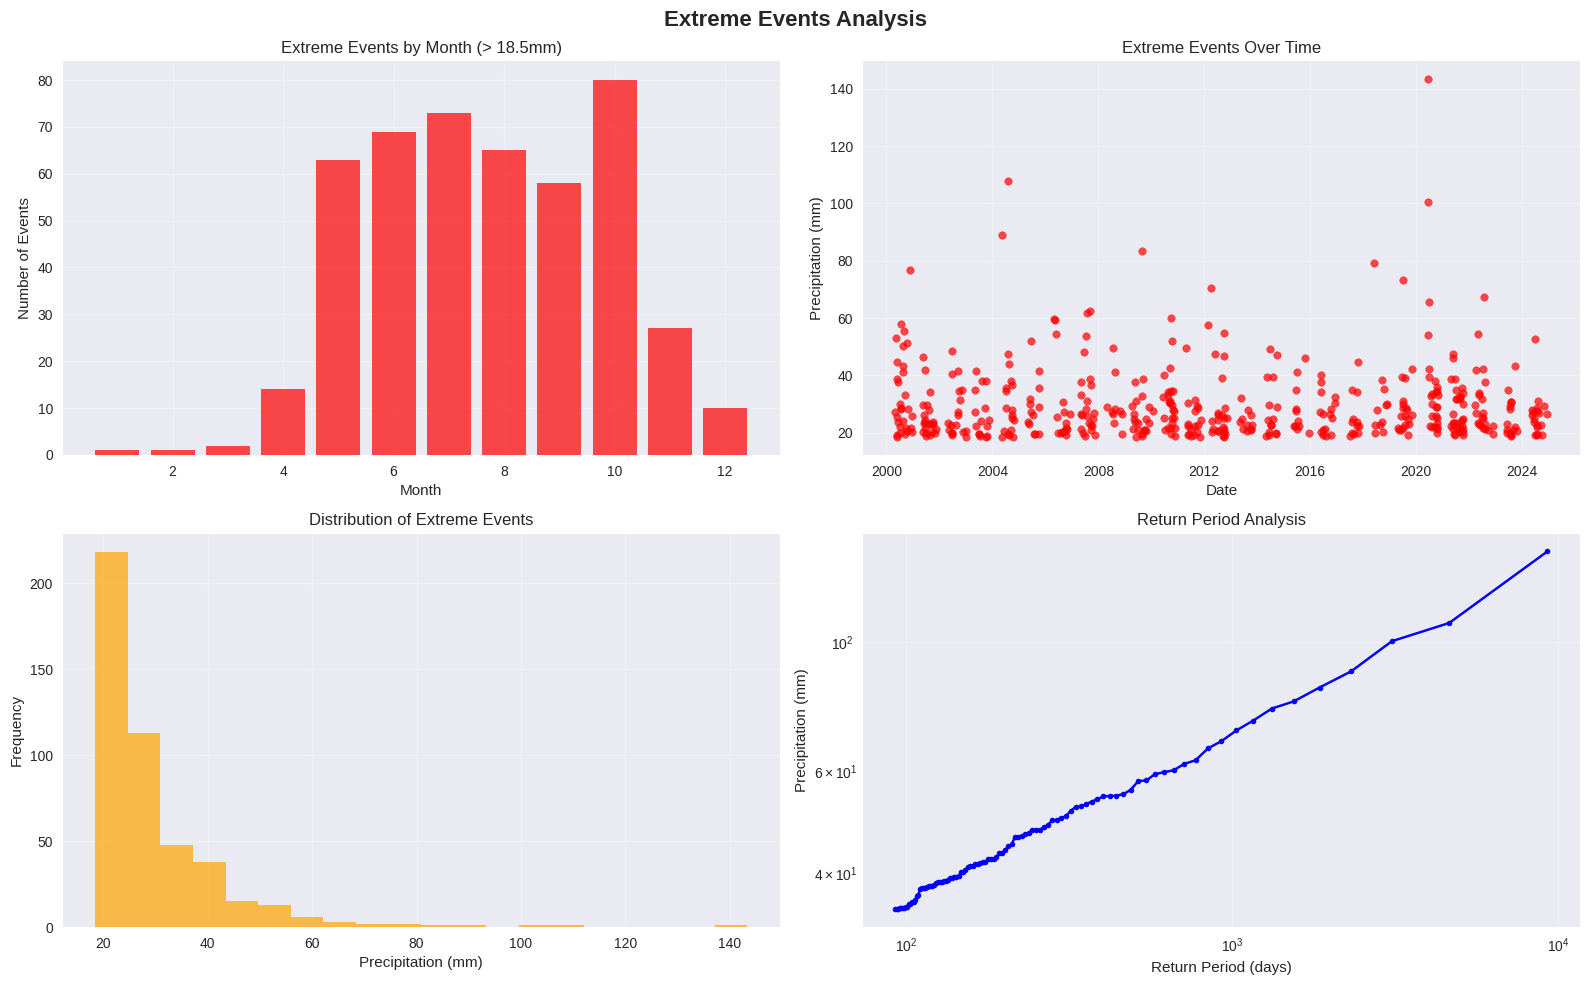

   📅 Peak extreme events month: 10
P95 threshold: 18.45mm
Extreme events (>P95): 463
Peak extreme month: 10


In [ ]:
# Initialize the analyzer
analyzer = WeatherEDAAnalyzer(df_all, target_col='Lượng mưa', date_col='Ngày')

# Run Component 2: Extreme Events Analysis
extreme_results = analyzer.run_extreme_events_analysis()

# Access results
thresholds = extreme_results['extreme_definition']['thresholds']
extreme_counts = extreme_results['extreme_definition']['extreme_counts']
peak_month = extreme_results['seasonal_patterns']['peak_month']

print(f"P95 threshold: {thresholds['p95']:.2f}mm")
print(f"Extreme events (>P95): {extreme_counts['p95']}")
print(f"Peak extreme month: {peak_month}")


# Cross-Correlation & Multicollinearity Analysis

🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS
🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa
   📍 Geographic Scope: Ho Chi Minh City (Single Location)
   🔢 Total Features: 20
   📈 Predictor Features: 19

📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 6 features
   - Humidity: 5 features
   - Wind: 6 features
   - Pressure_Radiation: 2 features
   - Precipitation: 1 features


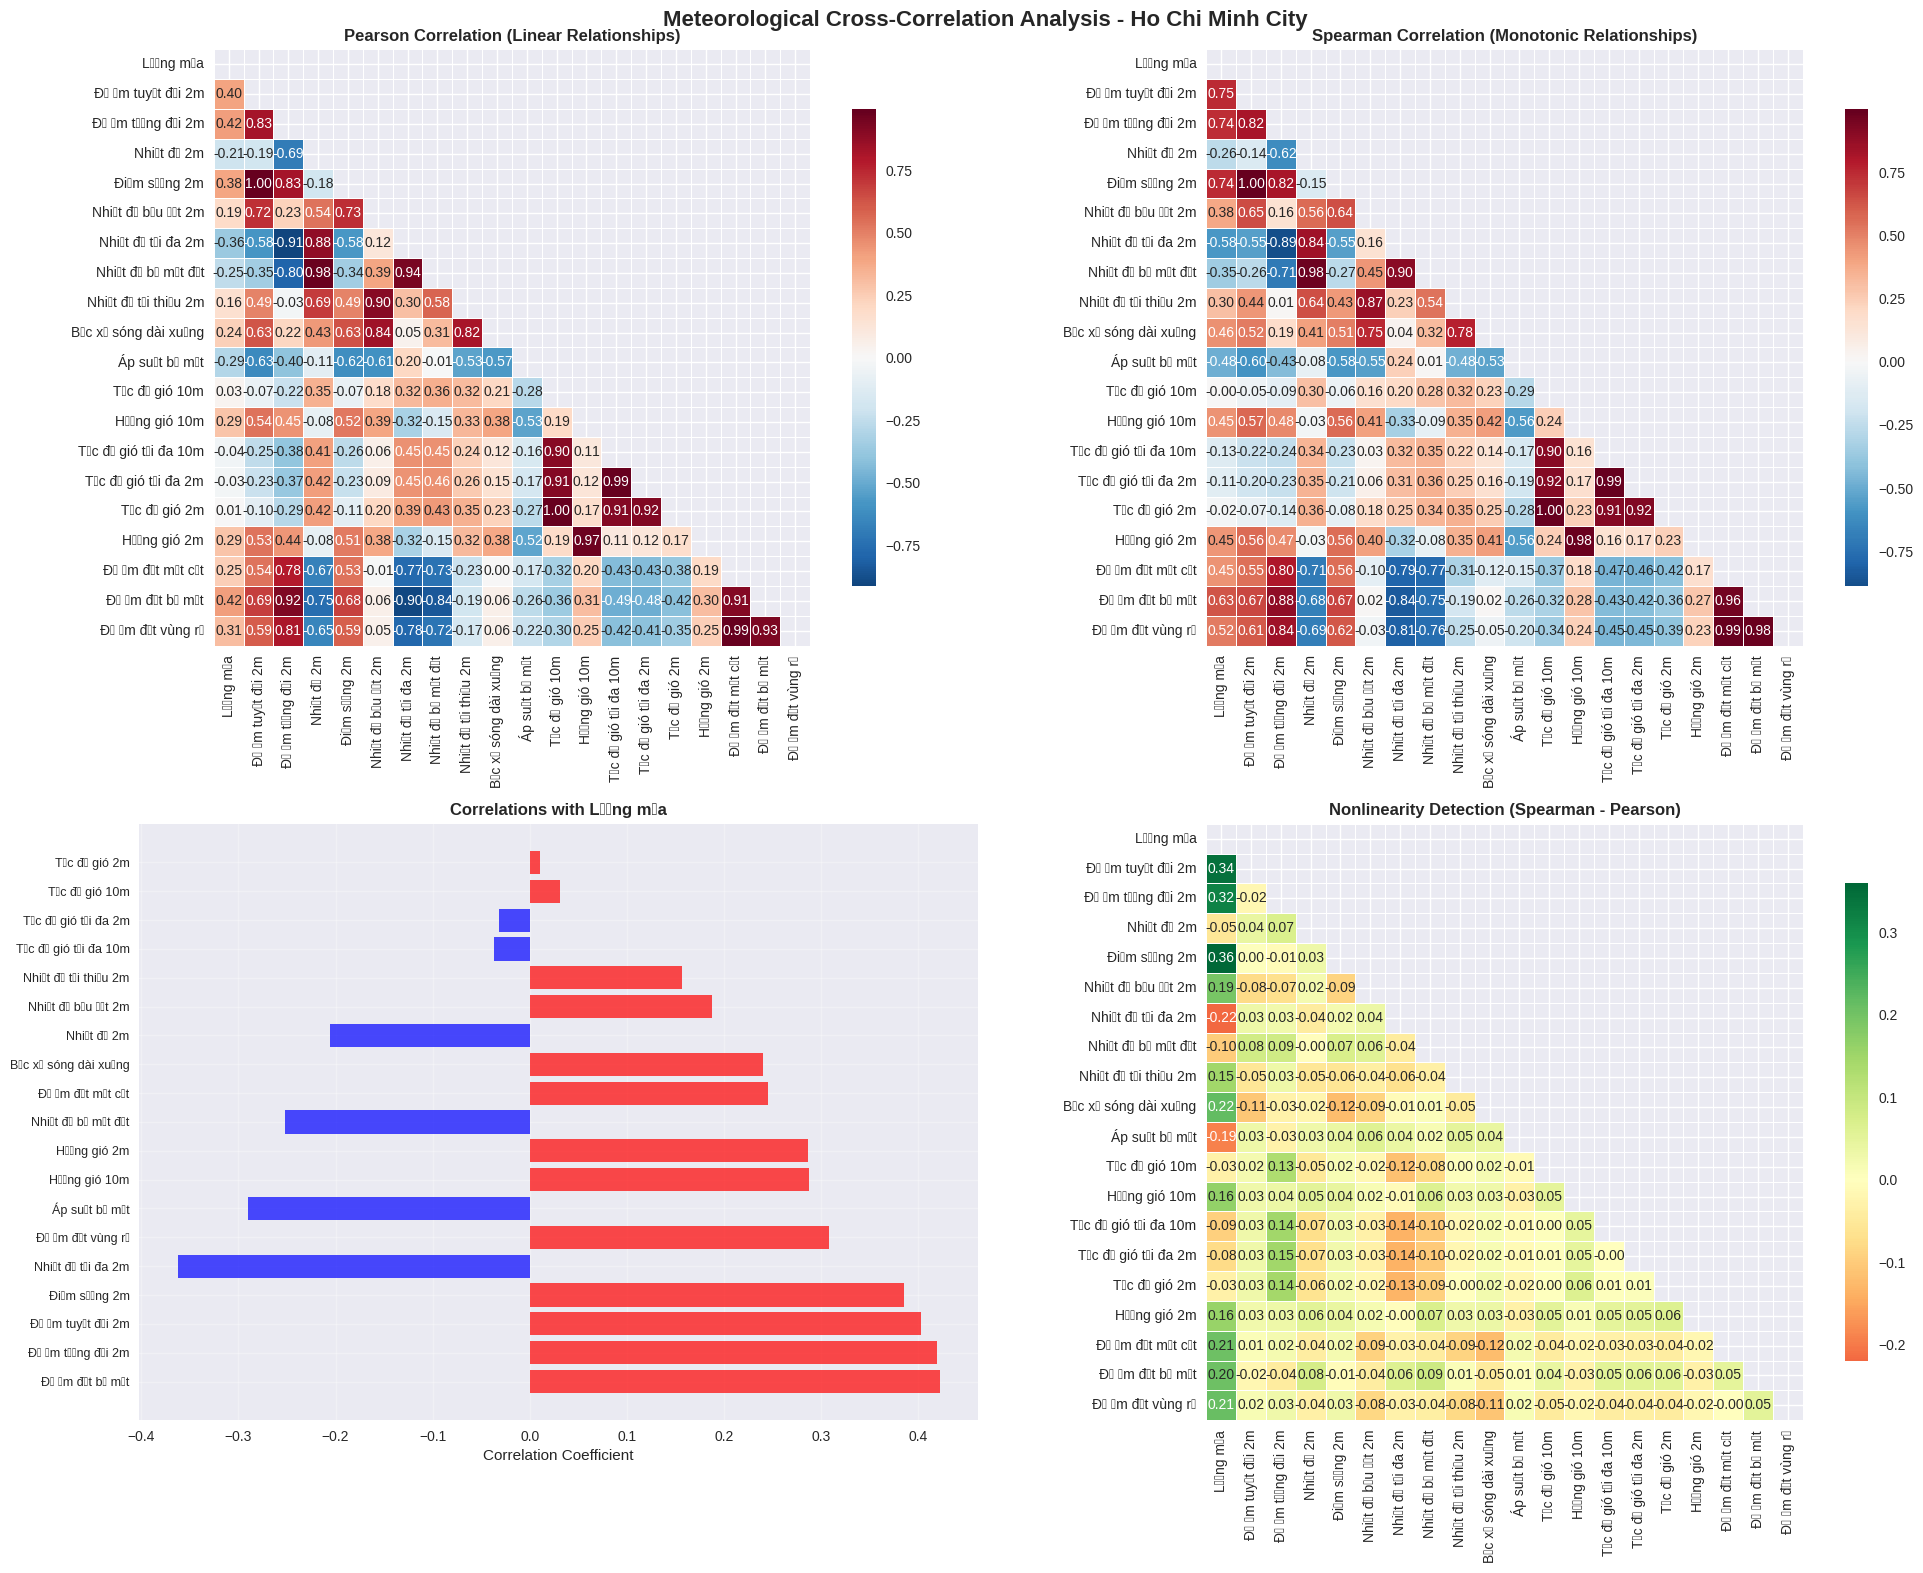


📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS
🌤️ 2.1 Seasonal Correlation Analysis
--------------------------------------------------


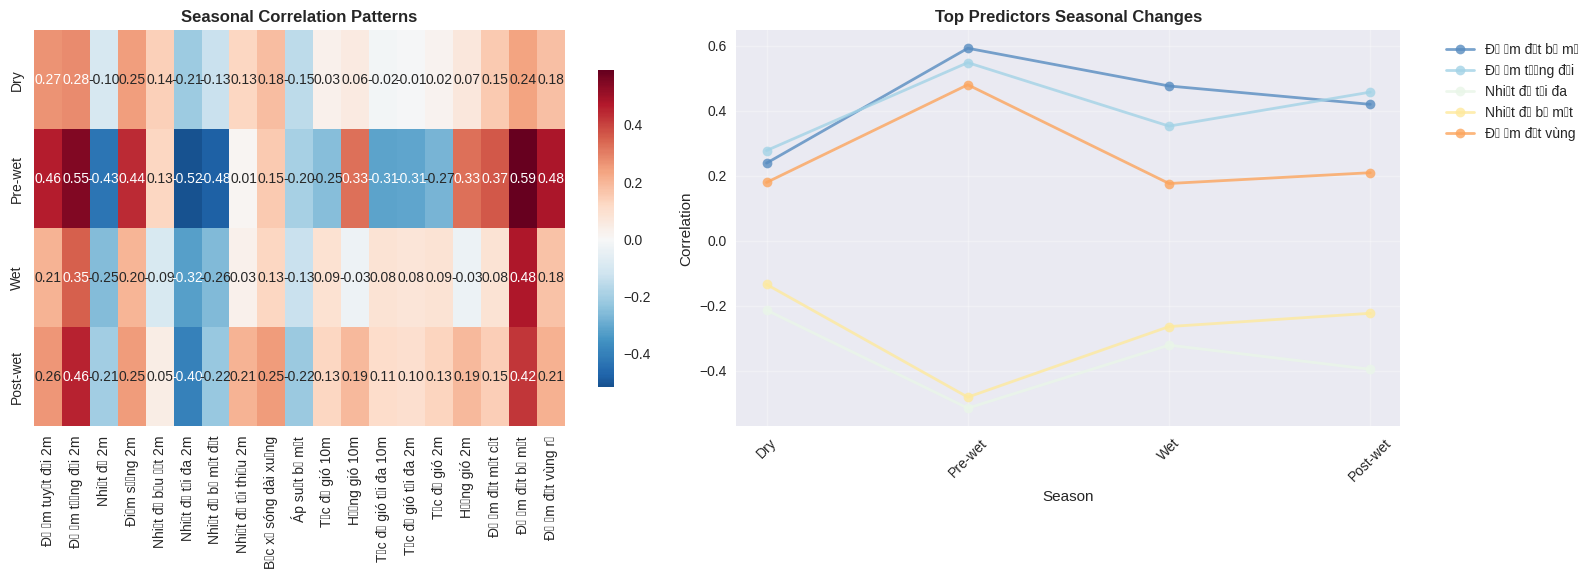


📈 2.2 Rolling Correlation Analysis
--------------------------------------------------

⏰ 2.3 Lagged Correlation Analysis
--------------------------------------------------

🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
            Feature     VIF_Score    Category Risk_Level
Nhiệt độ bầu ướt 2m 154387.023484 Temperature       High
      Điểm sương 2m 113529.370568 Temperature       High
        Nhiệt độ 2m  74977.814798 Temperature       High
      Tốc độ gió 2m    611.690068        Wind       High
     Tốc độ gió 10m    584.487676        Wind       High
 Độ ẩm tuyệt đối 2m    278.682109    Humidity       High
 Độ ẩm tương đối 2m    242.917316    Humidity       High
Nhiệt độ bề mặt đất    207.212794 Temperature       High
  Độ ẩm đất vùng rễ    173.863378    Humidity       High
  Độ ẩm đất mặt cắt    133.061542    Humidity       High

🕸️ 4. FEATURE INTERACTION NETWORK
🕸️ Network: 20 nodes, 127 edges
   Density: 0.668

🔬 6. ADVANCED CORRELATION CLUSTERI

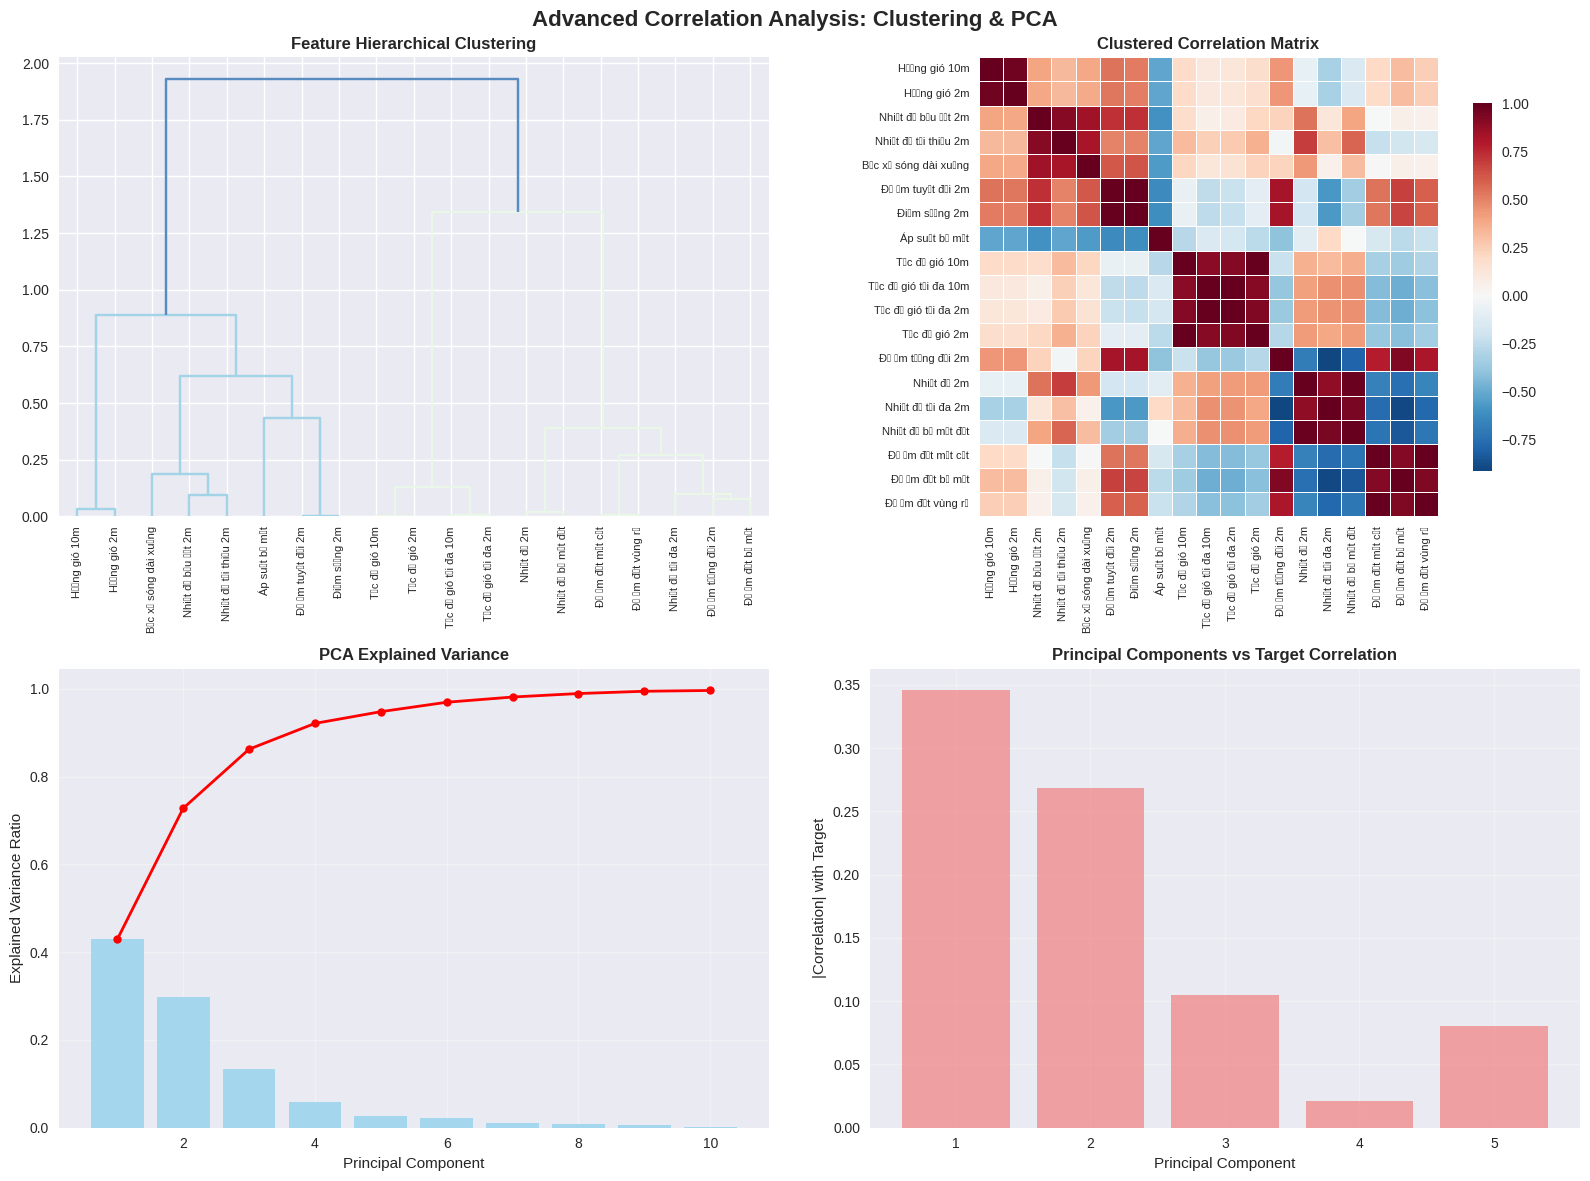


🎯 HO CHI MINH CITY WEATHER CORRELATION EXECUTIVE SUMMARY:
🌧️ PRECIPITATION PREDICTION INSIGHTS:
   - Strong predictors (|r| > 0.3): 6
   - Moderate predictors (0.2 < |r| ≤ 0.3): 7

📈 DYNAMIC CORRELATION INSIGHTS:
   - Độ ẩm đất bề mặt: Variable correlation
   - Độ ẩm tương đối 2m: Variable correlation

⏰ LAGGED CORRELATION INSIGHTS:
   - Độ ẩm đất bề mặt: best at 0 days (r=0.422)
   - Độ ẩm tương đối 2m: best at 0 days (r=0.419)

🔬 ADVANCED CLUSTERING INSIGHTS:
   - Feature clusters identified: 5
   - Top PC explains 42.9% variance
   - Top PC correlation with target: 0.345

✅ CLEANED ANALYSIS COMPLETED

🎉 ENHANCED HO CHI MINH CITY CORRELATION ANALYSIS SUMMARY:
   💪 Strong Predictors: 6
   📊 Moderate Predictors: 7
   🌤️ Meteorological Categories: 5
   📈 Dynamic Correlations: 2
   ⏰ Lagged Correlations: 2
   🕸️ Feature Network Density: 0.668


In [ ]:
# =============================================================================
# ENHANCED PART B: COMPREHENSIVE CORRELATION ANALYSIS (CLEANED)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("RdYlBu_r")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

class CityLevelCorrelationAnalyzer:
    """
    Enhanced Comprehensive Correlation Analysis for City-Level Weather Data
    Unified: Static, Dynamic, Lagged, Multicollinearity & Network Analysis
    """

    def __init__(self, df, target_col='Lượng mưa', date_col='Ngày'):
        """Initialize City-Level Correlation Analyzer"""
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col

        # Exclude non-predictive columns for city-level data
        exclude_cols = ['Vĩ độ', 'Kinh độ', 'Ngày', 'Nhóm']

        # Get numerical columns for analysis
        self.numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.analysis_cols = [col for col in self.numerical_cols if col not in exclude_cols]

        # Separate predictors from target
        self.predictor_cols = [col for col in self.analysis_cols if col != self.target_col]

        print("🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED")
        print("="*70)
        print(f"   📊 Dataset Shape: {self.df.shape}")
        print(f"   🎯 Target Variable: {self.target_col}")
        print(f"   📍 Geographic Scope: Ho Chi Minh City (Single Location)")
        print(f"   🔢 Total Features: {len(self.analysis_cols)}")
        print(f"   📈 Predictor Features: {len(self.predictor_cols)}")

    def meteorological_correlation_matrix(self):
        """1. Specialized correlation matrix for meteorological variables"""
        print("\n" + "="*70)
        print("🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS")
        print("="*70)

        # Group features by meteorological categories
        feature_groups = {
            'Temperature': [col for col in self.analysis_cols if 'Nhiệt độ' in col or 'Điểm sương' in col or 'bầu ướt' in col],
            'Humidity': [col for col in self.analysis_cols if 'Độ ẩm' in col],
            'Wind': [col for col in self.analysis_cols if 'gió' in col or 'Hướng' in col or 'Tốc độ' in col],
            'Pressure_Radiation': [col for col in self.analysis_cols if 'Áp suất' in col or 'Bức xạ' in col],
            'Precipitation': [self.target_col]
        }

        print(f"📊 Meteorological Feature Groups:")
        for group, features in feature_groups.items():
            print(f"   - {group}: {len(features)} features")

        # Calculate correlations
        correlations = {}
        correlations['pearson'] = self.df[self.analysis_cols].corr(method='pearson')
        correlations['spearman'] = self.df[self.analysis_cols].corr(method='spearman')

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Meteorological Cross-Correlation Analysis - Ho Chi Minh City',
                     fontsize=16, fontweight='bold')

        # Pearson correlation
        mask = np.triu(np.ones_like(correlations['pearson'], dtype=bool))
        sns.heatmap(correlations['pearson'], mask=mask, annot=True,
                   cmap='RdBu_r', center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8}, fmt='.2f', ax=axes[0,0])
        axes[0,0].set_title('Pearson Correlation (Linear Relationships)', fontweight='bold')

        # Spearman correlation
        sns.heatmap(correlations['spearman'], mask=mask, annot=True,
                   cmap='RdBu_r', center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8}, fmt='.2f', ax=axes[0,1])
        axes[0,1].set_title('Spearman Correlation (Monotonic Relationships)', fontweight='bold')

        # Target variable focus
        target_corr = correlations['pearson'][self.target_col].drop(self.target_col).sort_values(key=abs, ascending=False)
        bars = axes[1,0].barh(range(len(target_corr)), target_corr.values,
                             color=['red' if x > 0 else 'blue' for x in target_corr.values], alpha=0.7)
        axes[1,0].set_yticks(range(len(target_corr)))
        axes[1,0].set_yticklabels(target_corr.index, fontsize=9)
        axes[1,0].set_title(f'Correlations with {self.target_col}', fontweight='bold')
        axes[1,0].set_xlabel('Correlation Coefficient')
        axes[1,0].grid(True, alpha=0.3)

        # Nonlinearity detection
        diff_matrix = correlations['spearman'] - correlations['pearson']
        sns.heatmap(diff_matrix, mask=mask, annot=True,
                   cmap='RdYlGn', center=0, square=True, linewidths=.5,
                   cbar_kws={"shrink": .8}, fmt='.2f', ax=axes[1,1])
        axes[1,1].set_title('Nonlinearity Detection (Spearman - Pearson)', fontweight='bold')

        plt.tight_layout()
        plt.show()

        return correlations, feature_groups

    def temporal_correlation_dynamics(self):
        """
        2. UNIFIED Temporal Correlation Dynamics Analysis
        Combines: Seasonal, Rolling, Lagged Analysis
        """
        print("\n" + "="*70)
        print("📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS")
        print("="*70)

        # Ensure datetime format
        if not pd.api.types.is_datetime64_any_dtype(self.df[self.date_col]):
            self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        results = {}

        # 2.1 Seasonal Analysis
        print(f"🌤️ 2.1 Seasonal Correlation Analysis")
        print("-" * 50)

        df_temp = self.df.copy()
        df_temp['Month'] = df_temp[self.date_col].dt.month
        df_temp['Season'] = df_temp['Month'].map({
            12: 'Dry', 1: 'Dry', 2: 'Dry',
            3: 'Pre-wet', 4: 'Pre-wet', 5: 'Pre-wet',
            6: 'Wet', 7: 'Wet', 8: 'Wet',
            9: 'Post-wet', 10: 'Post-wet', 11: 'Post-wet'
        })

        seasonal_correlations = {}
        seasons = ['Dry', 'Pre-wet', 'Wet', 'Post-wet']

        for season in seasons:
            season_data = df_temp[df_temp['Season'] == season]
            if len(season_data) > 30:
                seasonal_correlations[season] = season_data[self.analysis_cols].corr()[self.target_col].drop(self.target_col)

        if seasonal_correlations:
            correlation_df = pd.DataFrame(seasonal_correlations)

            plt.figure(figsize=(16, 10))

            # Seasonal correlation heatmap
            plt.subplot(2, 2, 1)
            sns.heatmap(correlation_df.T, annot=True, cmap='RdBu_r', center=0,
                       cbar_kws={"shrink": .8}, fmt='.2f')
            plt.title('Seasonal Correlation Patterns', fontweight='bold')

            # Top predictors seasonal changes
            plt.subplot(2, 2, 2)
            top_predictors = correlation_df.abs().max(axis=1).nlargest(5).index
            for predictor in top_predictors:
                plt.plot(seasons, [correlation_df.loc[predictor, season] for season in seasons],
                        'o-', linewidth=2, label=predictor[:15], alpha=0.8)
            plt.title('Top Predictors Seasonal Changes', fontweight='bold')
            plt.xlabel('Season')
            plt.ylabel('Correlation')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

        results['seasonal_correlations'] = seasonal_correlations

        # 2.2 Rolling Correlations (Simplified)
        print(f"\n📈 2.2 Rolling Correlation Analysis")
        print("-" * 50)

        daily_agg = self.df.groupby(self.date_col)[self.analysis_cols].mean().reset_index()
        daily_agg = daily_agg.set_index(self.date_col).sort_index()
        daily_agg_clean = daily_agg.dropna()

        rolling_results = {}
        if len(daily_agg_clean) >= 60:
            static_corr = daily_agg_clean.corr()[self.target_col].sort_values(ascending=False)
            top_vars = static_corr.head(3).index.tolist()[1:3]  # Top 2 excluding target

            rolling_window = 30
            for var in top_vars:
                if var in daily_agg_clean.columns:
                    combined_df = daily_agg_clean[[self.target_col, var]].dropna()
                    rolling_corr = combined_df[self.target_col].rolling(window=rolling_window).corr(combined_df[var])
                    rolling_corr = rolling_corr.dropna()

                    if len(rolling_corr) > 0:
                        rolling_results[var] = {
                            'mean_correlation': rolling_corr.mean(),
                            'std_correlation': rolling_corr.std()
                        }

        results['rolling_correlations'] = rolling_results

        # 2.3 Lagged Correlations (Simplified)
        print(f"\n⏰ 2.3 Lagged Correlation Analysis")
        print("-" * 50)

        lagged_results = {}
        if len(daily_agg_clean) >= 60:
            max_lags = 5
            static_corr = daily_agg_clean.corr()[self.target_col].sort_values(ascending=False)
            top_vars = static_corr.head(3).index.tolist()[1:3]  # Top 2 excluding target

            for var in top_vars:
                if var in daily_agg_clean.columns:
                    correlations = []
                    lags = range(-max_lags, max_lags + 1)

                    target_series = daily_agg_clean[self.target_col]
                    var_series = daily_agg_clean[var]

                    for lag in lags:
                        if lag == 0:
                            corr = target_series.corr(var_series)
                        elif lag > 0:
                            shifted_var = var_series.shift(lag)
                            valid_idx = target_series.index.intersection(shifted_var.dropna().index)
                            corr = target_series.loc[valid_idx].corr(shifted_var.loc[valid_idx])
                        else:
                            shifted_target = target_series.shift(-lag)
                            corr = shifted_target.corr(var_series)

                        correlations.append(corr if not np.isnan(corr) else 0)

                    # Find best lag
                    abs_correlations = [abs(c) for c in correlations]
                    best_lag_idx = np.argmax(abs_correlations)
                    best_lag = lags[best_lag_idx]
                    best_corr = correlations[best_lag_idx]

                    lagged_results[var] = {
                        'best_lag': best_lag,
                        'best_correlation': best_corr
                    }

        results['lagged_correlations'] = lagged_results

        return results

    def multicollinearity_advanced_analysis(self):
        """3. Advanced multicollinearity analysis"""
        print("\n" + "="*70)
        print("🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS")
        print("="*70)

        X = self.df[self.predictor_cols].dropna()
        vif_data = []

        try:
            from statsmodels.tools.tools import add_constant
            X_with_const = add_constant(X)

            for i, col in enumerate(X.columns):
                vif_score = variance_inflation_factor(X_with_const.values, i+1)
                vif_data.append({
                    'Feature': col,
                    'VIF_Score': vif_score,
                    'Category': self._categorize_feature(col),
                    'Risk_Level': self._interpret_vif(vif_score)
                })

        except Exception as e:
            print(f"   ⚠️ VIF calculation error: {e}")
            # Alternative: correlation-based detection
            corr_matrix = X.corr()
            for col in X.columns:
                max_corr = corr_matrix[col].drop(col).abs().max()
                vif_score = 1/(1-max_corr**2) if max_corr < 0.99 else 100
                vif_data.append({
                    'Feature': col,
                    'VIF_Score': vif_score,
                    'Category': self._categorize_feature(col),
                    'Risk_Level': self._interpret_vif(vif_score)
                })

        if vif_data:
            vif_df = pd.DataFrame(vif_data).sort_values('VIF_Score', ascending=False)
            print(f"📊 Multicollinearity Analysis Results:")
            print(vif_df.head(10).to_string(index=False))

        return vif_df if vif_data else None

    def feature_interaction_network(self):
        """4. Network analysis focusing on feature interactions"""
        print("\n" + "="*70)
        print("🕸️ 4. FEATURE INTERACTION NETWORK")
        print("="*70)

        corr_matrix = self.df[self.analysis_cols].corr()
        G = nx.Graph()

        # Add nodes
        for feature in self.analysis_cols:
            category = self._categorize_feature(feature)
            G.add_node(feature, category=category, is_target=(feature == self.target_col))

        # Add edges for significant correlations
        correlation_threshold = 0.25
        for i, feature1 in enumerate(self.analysis_cols):
            for j, feature2 in enumerate(self.analysis_cols):
                if i < j:
                    corr_val = corr_matrix.loc[feature1, feature2]
                    if abs(corr_val) >= correlation_threshold:
                        G.add_edge(feature1, feature2, weight=abs(corr_val), correlation=corr_val)

        print(f"🕸️ Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        print(f"   Density: {nx.density(G):.3f}")

        return G, []

    def advanced_correlation_clustering_analysis(self):
        """
        6. Advanced Correlation Analysis using Clustering and PCA
        Utilizes: scipy.cluster, sklearn.preprocessing, sklearn.decomposition
        """
        print("\n" + "="*70)
        print("🔬 6. ADVANCED CORRELATION CLUSTERING & PCA ANALYSIS")
        print("="*70)

        # Prepare data
        X = self.df[self.predictor_cols].dropna()

        # 6.1 Standardize features
        print("📊 6.1 Feature Standardization")
        print("-" * 50)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.predictor_cols, index=X.index)

        # 6.2 Hierarchical Clustering of Features
        print("🌳 6.2 Hierarchical Feature Clustering")
        print("-" * 50)

        # Calculate correlation distance matrix
        corr_matrix = X_scaled_df.corr()
        distance_matrix = 1 - np.abs(corr_matrix)
        condensed_distances = squareform(distance_matrix.values)

        # Perform hierarchical clustering
        linkage_matrix = linkage(condensed_distances, method='ward')

        # Get clusters
        n_clusters = min(5, len(self.predictor_cols)//3)  # Adaptive cluster number
        cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

        # Create feature clusters
        feature_clusters = {}
        for i, feature in enumerate(self.predictor_cols):
            cluster_id = cluster_labels[i]
            if cluster_id not in feature_clusters:
                feature_clusters[cluster_id] = []
            feature_clusters[cluster_id].append(feature)

        print(f"   📊 Features grouped into {n_clusters} clusters:")
        for cluster_id, features in feature_clusters.items():
            print(f"   Cluster {cluster_id}: {len(features)} features")

        # 6.3 PCA Analysis
        print("\n🎯 6.3 Principal Component Analysis")
        print("-" * 50)

        pca = PCA()
        pca_result = pca.fit_transform(X_scaled)

        # Calculate correlation of PCs with target
        target_values = self.df.loc[X.index, self.target_col]
        pc_target_correlations = []

        for i in range(min(5, len(self.predictor_cols))):  # Top 5 PCs
            pc_corr = np.corrcoef(pca_result[:, i], target_values)[0, 1]
            pc_target_correlations.append({
                'PC': f'PC{i+1}',
                'Explained_Variance': pca.explained_variance_ratio_[i],
                'Target_Correlation': pc_corr
            })

        pc_df = pd.DataFrame(pc_target_correlations)
        print("   📈 Principal Components vs Target:")
        print(pc_df.to_string(index=False, float_format='%.3f'))

        # 6.4 Visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Advanced Correlation Analysis: Clustering & PCA', fontsize=16, fontweight='bold')

        # Dendrogram
        dendrogram(linkage_matrix, labels=self.predictor_cols, ax=axes[0,0],
                  orientation='top', leaf_rotation=90)
        axes[0,0].set_title('Feature Hierarchical Clustering', fontweight='bold')
        axes[0,0].tick_params(axis='x', labelsize=8)

        # Clustered correlation heatmap
        cluster_order = []
        for cluster_id in sorted(feature_clusters.keys()):
            cluster_order.extend(feature_clusters[cluster_id])

        reordered_corr = corr_matrix.loc[cluster_order, cluster_order]
        sns.heatmap(reordered_corr, ax=axes[0,1], cmap='RdBu_r', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        axes[0,1].set_title('Clustered Correlation Matrix', fontweight='bold')
        axes[0,1].tick_params(axis='both', labelsize=8)

        # PCA explained variance
        cumsum_var = np.cumsum(pca.explained_variance_ratio_)
        axes[1,0].bar(range(1, len(cumsum_var[:10])+1), pca.explained_variance_ratio_[:10],
                      alpha=0.7, color='skyblue')
        axes[1,0].plot(range(1, len(cumsum_var[:10])+1), cumsum_var[:10],
                      'ro-', linewidth=2, markersize=6)
        axes[1,0].set_title('PCA Explained Variance', fontweight='bold')
        axes[1,0].set_xlabel('Principal Component')
        axes[1,0].set_ylabel('Explained Variance Ratio')
        axes[1,0].grid(True, alpha=0.3)

        # PC correlation with target
        pc_corrs = [abs(corr['Target_Correlation']) for corr in pc_target_correlations]
        axes[1,1].bar(range(1, len(pc_corrs)+1), pc_corrs, alpha=0.7, color='lightcoral')
        axes[1,1].set_title('Principal Components vs Target Correlation', fontweight='bold')
        axes[1,1].set_xlabel('Principal Component')
        axes[1,1].set_ylabel('|Correlation| with Target')
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return {
            'feature_clusters': feature_clusters,
            'pca_results': pc_df,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'linkage_matrix': linkage_matrix
        }

    def generate_city_level_insights_report(self):
        """5. Generate comprehensive insights report"""
        print("\n" + "="*70)
        print("📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHTS REPORT")
        print("="*70)

        # Run all analyses
        correlations, feature_groups = self.meteorological_correlation_matrix()
        temporal_results = self.temporal_correlation_dynamics()
        vif_results = self.multicollinearity_advanced_analysis()
        network, edges = self.feature_interaction_network()

        # NEW: Add advanced clustering analysis
        clustering_results = self.advanced_correlation_clustering_analysis()

        # Extract results
        seasonal_correlations = temporal_results['seasonal_correlations']
        rolling_correlations = temporal_results['rolling_correlations']
        lagged_correlations = temporal_results['lagged_correlations']

        # Executive summary
        print(f"\n🎯 HO CHI MINH CITY WEATHER CORRELATION EXECUTIVE SUMMARY:")
        print("="*60)

        target_corr = correlations['pearson'][self.target_col].drop(self.target_col).abs().sort_values(ascending=False)
        strong_predictors = target_corr[target_corr > 0.3]
        moderate_predictors = target_corr[(target_corr > 0.2) & (target_corr <= 0.3)]

        print(f"🌧️ PRECIPITATION PREDICTION INSIGHTS:")
        print(f"   - Strong predictors (|r| > 0.3): {len(strong_predictors)}")
        print(f"   - Moderate predictors (0.2 < |r| ≤ 0.3): {len(moderate_predictors)}")

        if rolling_correlations:
            print(f"\n📈 DYNAMIC CORRELATION INSIGHTS:")
            for var, results in rolling_correlations.items():
                stability = "Stable" if results['std_correlation'] < 0.1 else "Variable"
                print(f"   - {var}: {stability} correlation")

        if lagged_correlations:
            print(f"\n⏰ LAGGED CORRELATION INSIGHTS:")
            for var, results in lagged_correlations.items():
                print(f"   - {var}: best at {results['best_lag']} days (r={results['best_correlation']:.3f})")

        # NEW: Add clustering insights
        print(f"\n🔬 ADVANCED CLUSTERING INSIGHTS:")
        print(f"   - Feature clusters identified: {len(clustering_results['feature_clusters'])}")
        top_pc = clustering_results['pca_results'].iloc[0]
        print(f"   - Top PC explains {top_pc['Explained_Variance']:.1%} variance")
        print(f"   - Top PC correlation with target: {abs(top_pc['Target_Correlation']):.3f}")

        return {
            'correlations': correlations,
            'feature_groups': feature_groups,
            'seasonal_correlations': seasonal_correlations,
            'rolling_correlations': rolling_correlations,
            'lagged_correlations': lagged_correlations,
            'vif_results': vif_results,
            'network': network,
            'strong_predictors': strong_predictors,
            'moderate_predictors': moderate_predictors,
            'clustering_results': clustering_results  # NEW
        }

    def _categorize_feature(self, feature_name):
        """Helper function to categorize meteorological features"""
        if any(term in feature_name for term in ['Nhiệt độ', 'Điểm sương', 'bầu ướt']):
            return 'Temperature'
        elif 'Độ ẩm' in feature_name:
            return 'Humidity'
        elif any(term in feature_name for term in ['gió', 'Hướng', 'Tốc độ']):
            return 'Wind'
        elif any(term in feature_name for term in ['Áp suất', 'Bức xạ']):
            return 'Pressure_Radiation'
        elif feature_name == self.target_col:
            return 'Precipitation'
        else:
            return 'Other'

    def _interpret_vif(self, vif_score):
        """Helper function to interpret VIF scores"""
        if vif_score < 5:
            return "Low"
        elif vif_score < 10:
            return "Moderate"
        else:
            return "High"

# =============================================================================
# EXECUTION
# =============================================================================

def run_city_level_correlation_analysis(df, target_col='Lượng mưa', date_col='Ngày'):
    """Run comprehensive correlation analysis for city-level data"""
    print("🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS")
    print("="*80)

    analyzer = CityLevelCorrelationAnalyzer(df, target_col, date_col)
    results = analyzer.generate_city_level_insights_report()

    print("\n✅ CLEANED ANALYSIS COMPLETED")
    return results

# =============================================================================
# RUN CITY-LEVEL ANALYSIS
# =============================================================================

# Chạy phân tích correlation cho dữ liệu TP.HCM
city_correlation_results = run_city_level_correlation_analysis(
    df_all,
    target_col='Lượng mưa',
    date_col='Ngày'
)

print(f"\n🎉 ENHANCED HO CHI MINH CITY CORRELATION ANALYSIS SUMMARY:")
print(f"   💪 Strong Predictors: {len(city_correlation_results['strong_predictors'])}")
print(f"   📊 Moderate Predictors: {len(city_correlation_results['moderate_predictors'])}")
print(f"   🌤️ Meteorological Categories: {len(city_correlation_results['feature_groups'])}")
print(f"   📈 Dynamic Correlations: {len(city_correlation_results['rolling_correlations'])}")  # NEW
print(f"   ⏰ Lagged Correlations: {len(city_correlation_results['lagged_correlations'])}")    # NEW
print(f"   🕸️ Feature Network Density: {nx.density(city_correlation_results['network']):.3f}")

# Feature Engineering

## Feature Selection

In [ ]:
selected_features = [
    'Nhiệt độ tối đa 2m',      # T2M_MAX
    'Nhiệt độ tối thiểu 2m',    # T2M_MIN
    'Độ ẩm tương đối 2m',       # RH2M
    'Độ ẩm đất bề mặt',         # GWETTOP
    'Hướng gió 10m',            # WD10M
    'Áp suất bề mặt',           # PS
    'Bức xạ sóng dài xuống'     # ALLSKY_SFC_LW_DWN
]

# Keep essential columns (date, target) + selected features
essential_columns = ['Ngày', 'Lượng mưa']  # Date and target variable
final_columns = essential_columns + selected_features

# Filter dataset
df_selected = df_all[final_columns].copy()

print(f"📊 Feature Selection completed:")
print(f"   Original shape: {df_all.shape}")
print(f"   Selected shape: {df_selected.shape}")
print(f"   Features selected: {len(selected_features)}")
print(f"   Selected features: {selected_features}")

📊 Feature Selection completed:
   Original shape: (9252, 23)
   Selected shape: (9252, 9)
   Features selected: 7
   Selected features: ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống']


## Temporal feature

In [ ]:
import numpy as np
import pandas as pd

# Convert date column to datetime if not already
df_selected['Ngày'] = pd.to_datetime(df_selected['Ngày'])

# Extract basic time features
df_selected['Year'] = df_selected['Ngày'].dt.year
df_selected['Month'] = df_selected['Ngày'].dt.month
df_selected['DayofMonth'] = df_selected['Ngày'].dt.day
df_selected['DayofYear'] = df_selected['Ngày'].dt.dayofyear

# Create cyclical features for Month (1-12)
df_selected['Month_sin'] = np.sin(2 * np.pi * df_selected['Month'] / 12)
df_selected['Month_cos'] = np.cos(2 * np.pi * df_selected['Month'] / 12)

# Create cyclical features for Day of Year (1-365/366)
df_selected['DayOfYear_sin'] = np.sin(2 * np.pi * df_selected['DayofYear'] / 365.25)
df_selected['DayOfYear_cos'] = np.cos(2 * np.pi * df_selected['DayofYear'] / 365.25)

# Create Wet Season feature (May-November = months 5,6,7,8,9,10,11)
df_selected['Is_Wet_Season'] = df_selected['Month'].isin([5, 6, 7, 8, 9, 10, 11]).astype(int)

print("🕒 Time-based Feature Engineering completed:")
print(f"   Dataset shape: {df_selected.shape}")
print(f"   New time features added: 8")
print(f"   Wet season months (value=1): May-November")
print(f"   Dry season months (value=0): December-April")

# Display sample of new features
print("\n📊 Sample of new time features:")
print(df_selected[['Ngày', 'Year', 'Month', 'DayofMonth', 'DayofYear',
                   'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
                   'Is_Wet_Season']].head(10))

# Check wet season distribution
print(f"\n🌧️ Wet Season Distribution:")
print(df_selected['Is_Wet_Season'].value_counts())

🕒 Time-based Feature Engineering completed:
   Dataset shape: (9252, 18)
   New time features added: 8
   Wet season months (value=1): May-November
   Dry season months (value=0): December-April

📊 Sample of new time features:
               Ngày  Year  Month  DayofMonth  DayofYear  Month_sin  Month_cos  \
20000101 2000-01-01  2000      1           1          1        0.5   0.866025   
20000102 2000-01-02  2000      1           2          2        0.5   0.866025   
20000103 2000-01-03  2000      1           3          3        0.5   0.866025   
20000104 2000-01-04  2000      1           4          4        0.5   0.866025   
20000105 2000-01-05  2000      1           5          5        0.5   0.866025   
20000106 2000-01-06  2000      1           6          6        0.5   0.866025   
20000107 2000-01-07  2000      1           7          7        0.5   0.866025   
20000108 2000-01-08  2000      1           8          8        0.5   0.866025   
20000109 2000-01-09  2000      1           9

## Lag and Rolling window Engineering


In [ ]:
# ==============================================================================
# LAG FEATURES & ROLLING WINDOW FEATURES
# ==============================================================================

# A. TARGET VARIABLE LAG & ROLLING FEATURES (HIGHEST PRIORITY)
print("🎯 Creating Target Variable Features (Lượng mưa)...")

# Lag features for rainfall (1, 2, 3, 4, 5, 7 days)
for lag in [1, 2, 3, 4, 5, 7]:
    df_selected[f'Rainfall_lag_{lag}'] = df_selected['Lượng mưa'].shift(lag)

# Rolling sum features (cumulative rainfall)
for window in [3, 7, 14, 30]:
    df_selected[f'Rainfall_sum_{window}d'] = df_selected['Lượng mưa'].rolling(window=window).sum()

# Rolling statistical features
for window in [7, 14]:
    df_selected[f'Rainfall_mean_{window}d'] = df_selected['Lượng mưa'].rolling(window=window).mean()
    df_selected[f'Rainfall_max_{window}d'] = df_selected['Lượng mưa'].rolling(window=window).max()
    df_selected[f'Rainfall_std_{window}d'] = df_selected['Lượng mưa'].rolling(window=window).std()

# B. IMPORTANT PREDICTOR VARIABLES LAG & ROLLING FEATURES
print("🌡️ Creating Temperature Features...")

# Temperature features (T2M_MAX, T2M_MIN)
temp_vars = ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m']
for var in temp_vars:
    # Lag 1
    df_selected[f'{var}_lag_1'] = df_selected[var].shift(1)

    # Rolling statistics
    for window in [3, 7, 14]:
        df_selected[f'{var}_mean_{window}d'] = df_selected[var].rolling(window=window).mean()
        df_selected[f'{var}_max_{window}d'] = df_selected[var].rolling(window=window).max()
        df_selected[f'{var}_min_{window}d'] = df_selected[var].rolling(window=window).min()
        df_selected[f'{var}_std_{window}d'] = df_selected[var].rolling(window=window).std()

print("💧 Creating Humidity Features...")

# Humidity features (RH2M, GWETTOP)
humidity_vars = ['Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt']
for var in humidity_vars:
    # Lag 1
    df_selected[f'{var}_lag_1'] = df_selected[var].shift(1)

    # Rolling statistics
    for window in [3, 7, 14]:
        df_selected[f'{var}_mean_{window}d'] = df_selected[var].rolling(window=window).mean()
        df_selected[f'{var}_std_{window}d'] = df_selected[var].rolling(window=window).std()

print("✅ Lag & Rolling Window Features completed:")
print(f"   Final dataset shape: {df_selected.shape}")
print(f"   Target lag features: 6")
print(f"   Target rolling features: 10")
print(f"   Temperature features: 24")
print(f"   Humidity features: 12")
print(f"   Total new features: 52")

# Check for missing values (expected due to lag/rolling)
missing_count = df_selected.isnull().sum().sum()
print(f"   Missing values created: {missing_count} (due to lag/rolling operations)")

🎯 Creating Target Variable Features (Lượng mưa)...
🌡️ Creating Temperature Features...
💧 Creating Humidity Features...
✅ Lag & Rolling Window Features completed:
   Final dataset shape: (9252, 74)
   Target lag features: 6
   Target rolling features: 10
   Temperature features: 24
   Humidity features: 12
   Total new features: 52
   Missing values created: 385 (due to lag/rolling operations)


In [ ]:
# ==============================================================================
# CHECK MISSING VALUES BY DATE
# ==============================================================================

# Find rows with any missing values
missing_rows = df_selected.isnull().any(axis=1)
missing_dates = df_selected[missing_rows]['Ngày']

print("📅 Dates with Missing Values:")
print(f"   Total dates with missing values: {len(missing_dates)}")
print(f"   Date range: {missing_dates.min()} to {missing_dates.max()}")

print("\n🗓️ First 20 dates with missing values:")
print(missing_dates.head(20).tolist())

if len(missing_dates) > 20:
    print(f"\n... and {len(missing_dates) - 20} more dates")

# Check which features have the most missing values
print(f"\n🔍 Missing values by feature (top 10):")
missing_by_feature = df_selected.isnull().sum().sort_values(ascending=False)
print(missing_by_feature[missing_by_feature > 0].head(10))

📅 Dates with Missing Values:
   Total dates with missing values: 29
   Date range: 2000-01-01 00:00:00 to 2000-01-29 00:00:00

🗓️ First 20 dates with missing values:
[Timestamp('2000-01-01 00:00:00'), Timestamp('2000-01-02 00:00:00'), Timestamp('2000-01-03 00:00:00'), Timestamp('2000-01-04 00:00:00'), Timestamp('2000-01-05 00:00:00'), Timestamp('2000-01-06 00:00:00'), Timestamp('2000-01-07 00:00:00'), Timestamp('2000-01-08 00:00:00'), Timestamp('2000-01-09 00:00:00'), Timestamp('2000-01-10 00:00:00'), Timestamp('2000-01-11 00:00:00'), Timestamp('2000-01-12 00:00:00'), Timestamp('2000-01-13 00:00:00'), Timestamp('2000-01-14 00:00:00'), Timestamp('2000-01-15 00:00:00'), Timestamp('2000-01-16 00:00:00'), Timestamp('2000-01-17 00:00:00'), Timestamp('2000-01-18 00:00:00'), Timestamp('2000-01-19 00:00:00'), Timestamp('2000-01-20 00:00:00')]

... and 9 more dates

🔍 Missing values by feature (top 10):
Rainfall_sum_30d                 29
Nhiệt độ tối thiểu 2m_std_14d    13
Độ ẩm tương đối 2m_s

In [ ]:
# ==============================================================================
# DROP MISSING VALUES
# ==============================================================================

# Store original shape for comparison
original_shape = df_selected.shape

# Drop rows with any missing values
df_selected = df_selected.dropna()

# Reset index after dropping rows
df_selected = df_selected.reset_index(drop=True)

print("🗑️ Missing Values Removal completed:")
print(f"   Original shape: {original_shape}")
print(f"   Final shape: {df_selected.shape}")
print(f"   Rows dropped: {original_shape[0] - df_selected.shape[0]}")
print(f"   Remaining data: {df_selected.shape[0]} days")
print(f"   Missing values remaining: {df_selected.isnull().sum().sum()}")

# Check date range of final dataset
print(f"\n📅 Final dataset date range:")
print(f"   Start date: {df_selected['Ngày'].min()}")
print(f"   End date: {df_selected['Ngày'].max()}")

🗑️ Missing Values Removal completed:
   Original shape: (9252, 74)
   Final shape: (9223, 74)
   Rows dropped: 29
   Remaining data: 9223 days
   Missing values remaining: 0

📅 Final dataset date range:
   Start date: 2000-01-30 00:00:00
   End date: 2025-04-30 00:00:00


## Multicolinear and cross-correlation checking for new feature

🔍 Defining Feature Groups for Correlation Analysis...
📊 Feature Groups Summary:
   Original features: 7
   Temporal features: 9
   Lag features: 10
   Rolling features: 40

PART 1: ORIGINAL FEATURES CORRELATION ANALYSIS
🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS
🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9223, 9)
   🎯 Target Variable: Lượng mưa
   📍 Geographic Scope: Ho Chi Minh City (Single Location)
   🔢 Total Features: 8
   📈 Predictor Features: 7

📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 2 features
   - Humidity: 2 features
   - Wind: 1 features
   - Pressure_Radiation: 2 features
   - Precipitation: 1 features


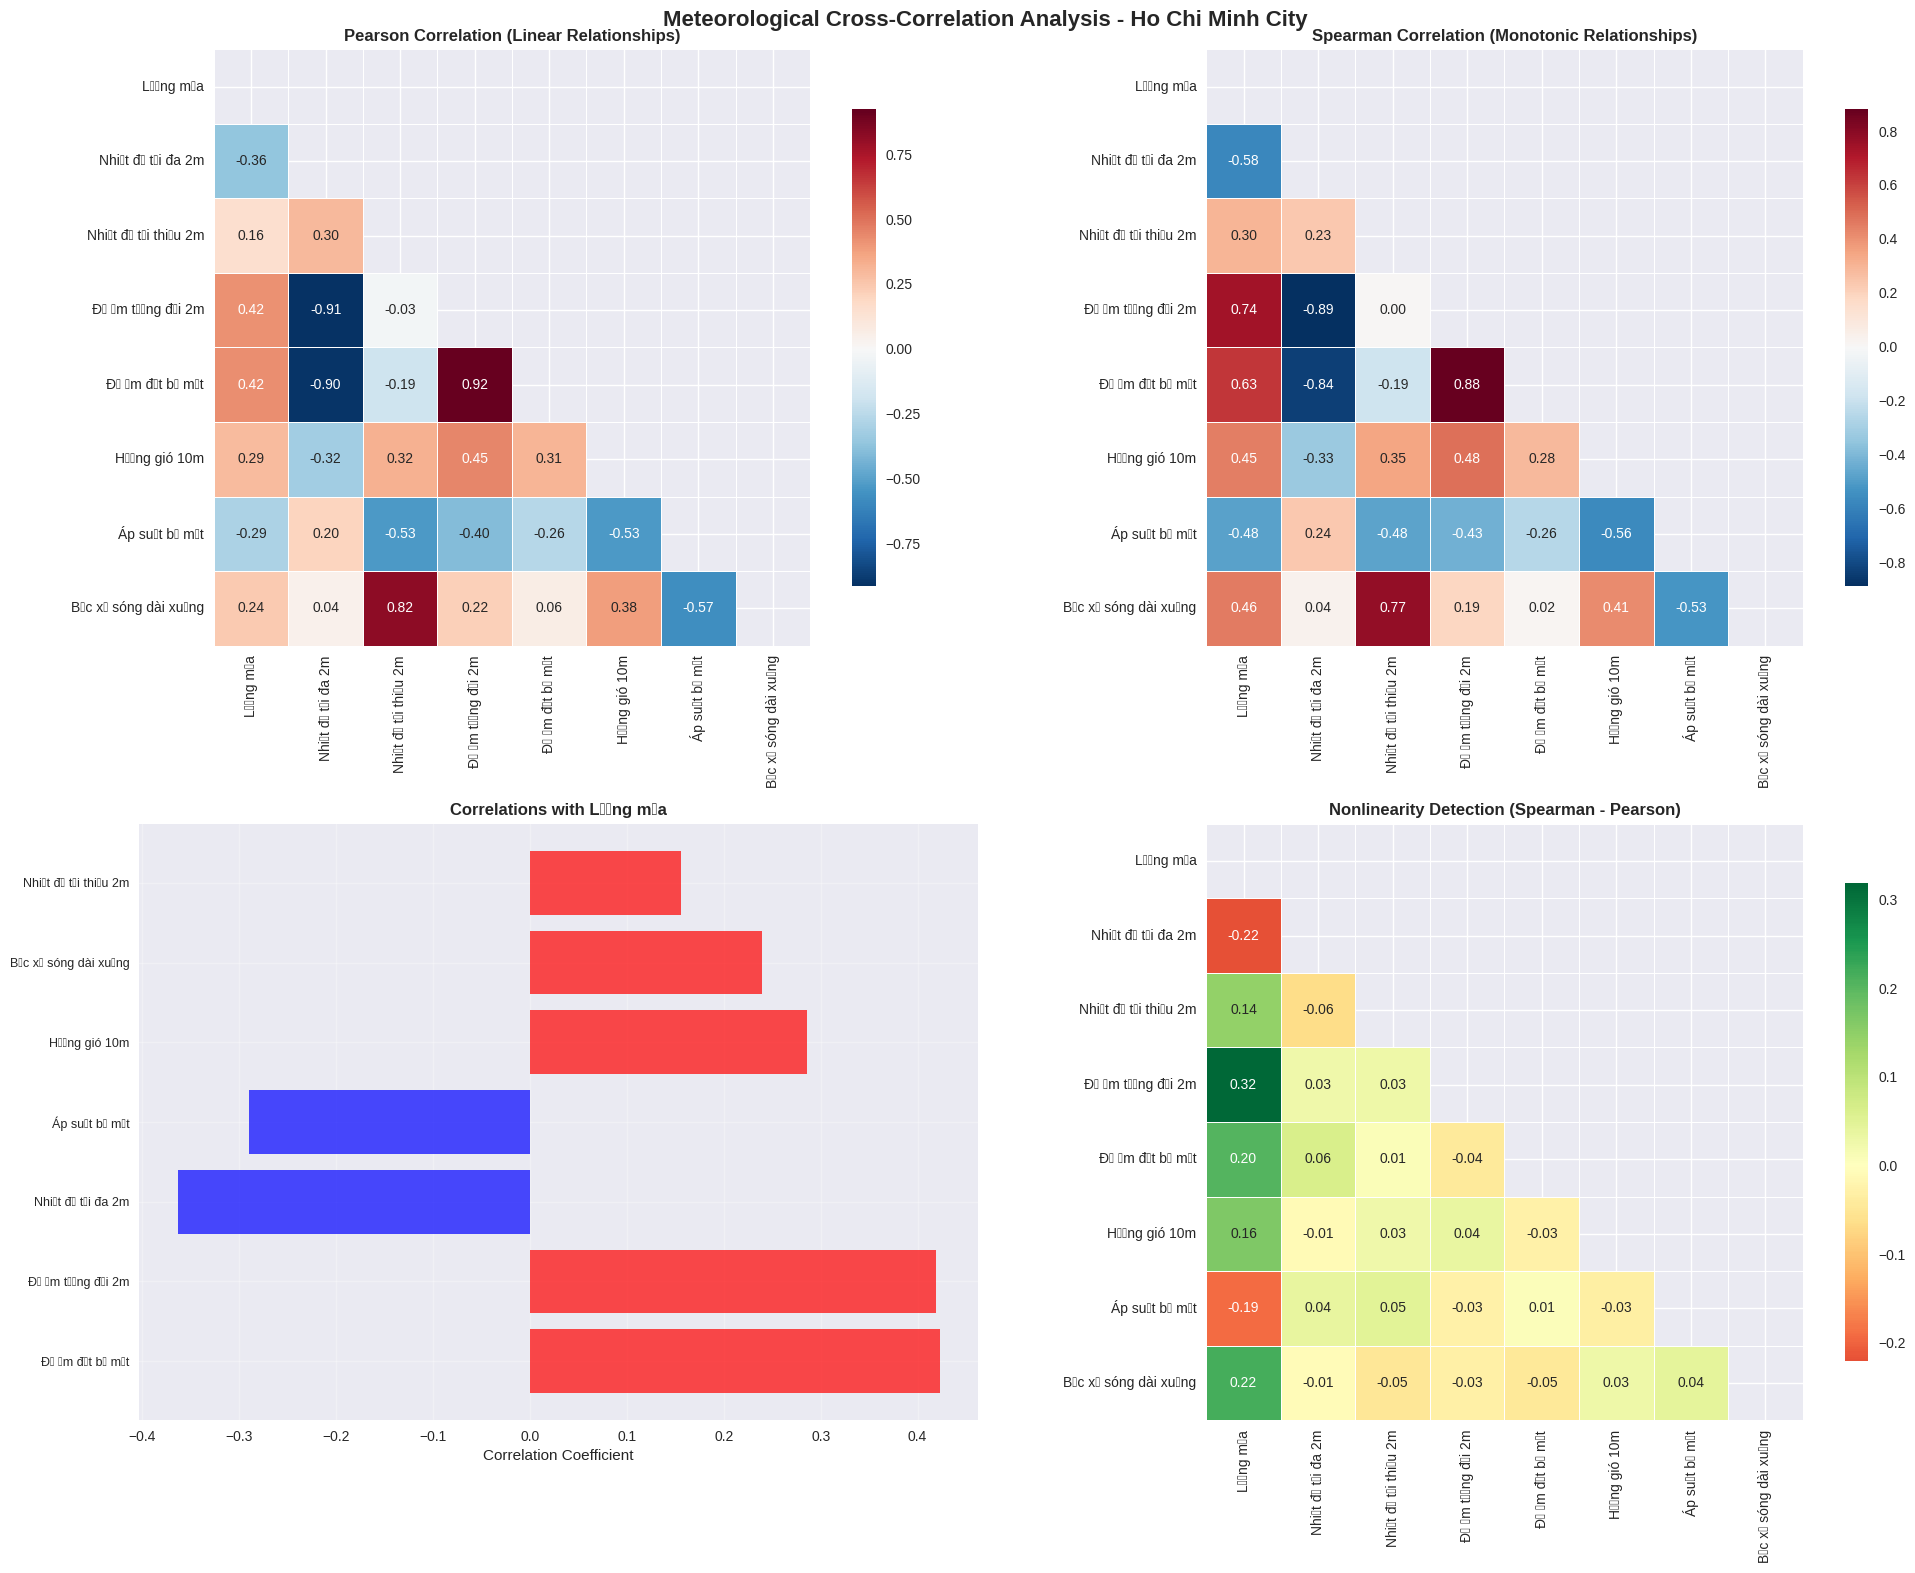


📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS
🌤️ 2.1 Seasonal Correlation Analysis
--------------------------------------------------


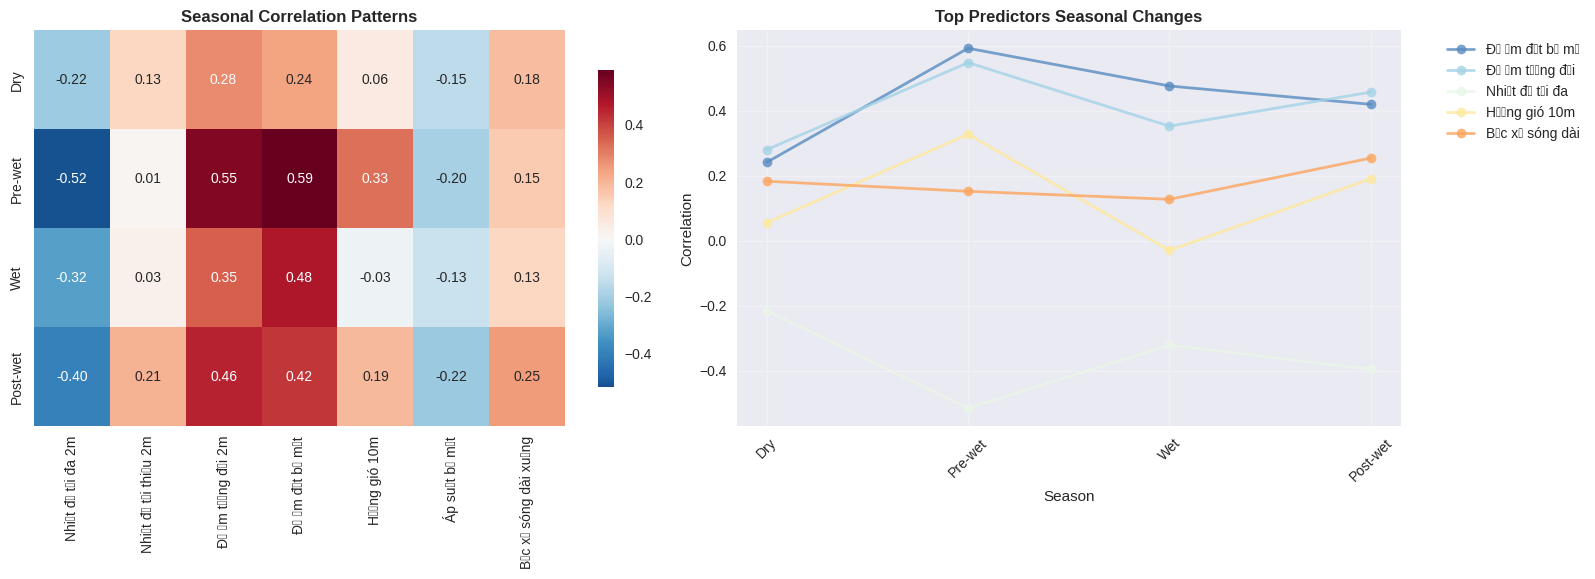


📈 2.2 Rolling Correlation Analysis
--------------------------------------------------

⏰ 2.3 Lagged Correlation Analysis
--------------------------------------------------

🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
              Feature  VIF_Score           Category Risk_Level
   Độ ẩm tương đối 2m  17.949677           Humidity       High
   Nhiệt độ tối đa 2m  11.575862        Temperature       High
     Độ ẩm đất bề mặt   8.849785           Humidity   Moderate
Nhiệt độ tối thiểu 2m   4.588379        Temperature        Low
Bức xạ sóng dài xuống   3.855778 Pressure_Radiation        Low
       Áp suất bề mặt   2.011460 Pressure_Radiation        Low
        Hướng gió 10m   1.612495               Wind        Low

🕸️ 4. FEATURE INTERACTION NETWORK
🕸️ Network: 8 nodes, 20 edges
   Density: 0.714

🔬 6. ADVANCED CORRELATION CLUSTERING & PCA ANALYSIS
📊 6.1 Feature Standardization
--------------------------------------------------
🌳 6.2 Hierarchical Feature

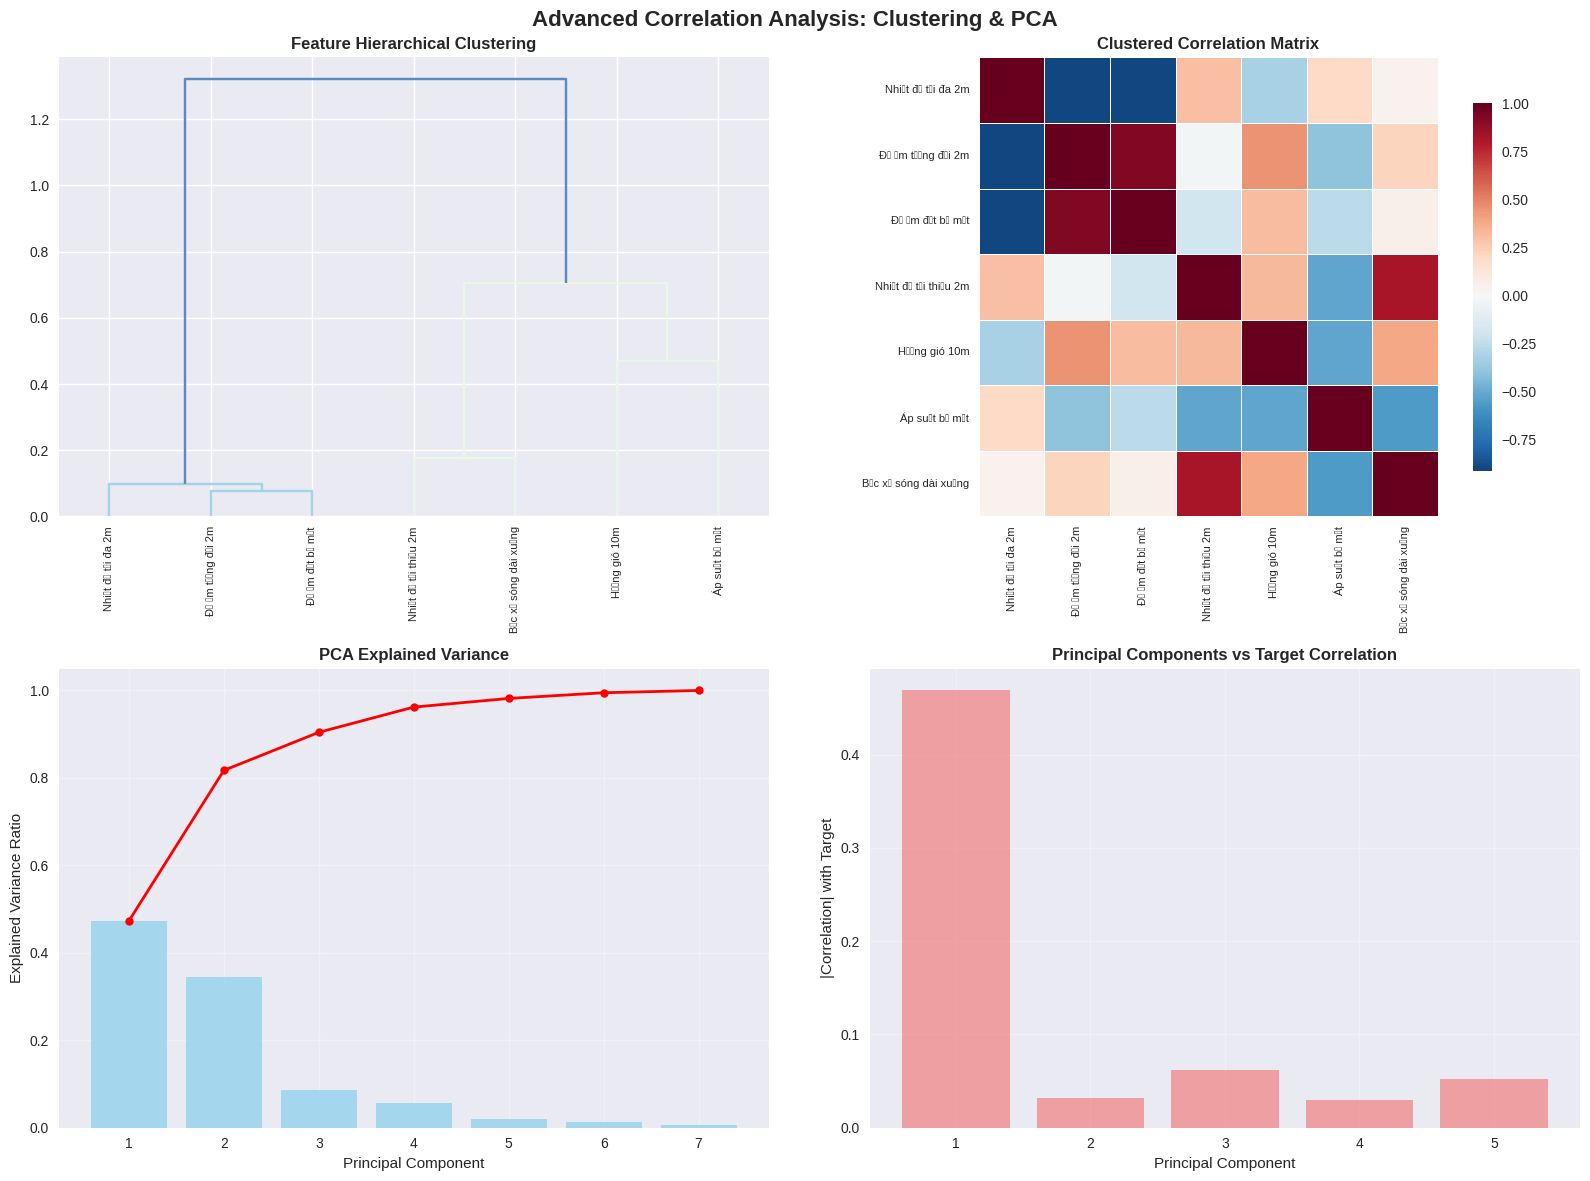


🎯 HO CHI MINH CITY WEATHER CORRELATION EXECUTIVE SUMMARY:
🌧️ PRECIPITATION PREDICTION INSIGHTS:
   - Strong predictors (|r| > 0.3): 3
   - Moderate predictors (0.2 < |r| ≤ 0.3): 3

📈 DYNAMIC CORRELATION INSIGHTS:
   - Độ ẩm đất bề mặt: Variable correlation
   - Độ ẩm tương đối 2m: Variable correlation

⏰ LAGGED CORRELATION INSIGHTS:
   - Độ ẩm đất bề mặt: best at 0 days (r=0.423)
   - Độ ẩm tương đối 2m: best at 0 days (r=0.419)

🔬 ADVANCED CLUSTERING INSIGHTS:
   - Feature clusters identified: 2
   - Top PC explains 47.3% variance
   - Top PC correlation with target: 0.469

✅ CLEANED ANALYSIS COMPLETED

PART 2: TEMPORAL FEATURES CORRELATION ANALYSIS
🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS
🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9223, 11)
   🎯 Target Variable: Lượng mưa
   📍 Geographic Scope: Ho Chi Minh City (Single Location)
   🔢 Total Features: 10
   📈 Predictor Features: 9

📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHTS REPORT

🌤️ 1. M

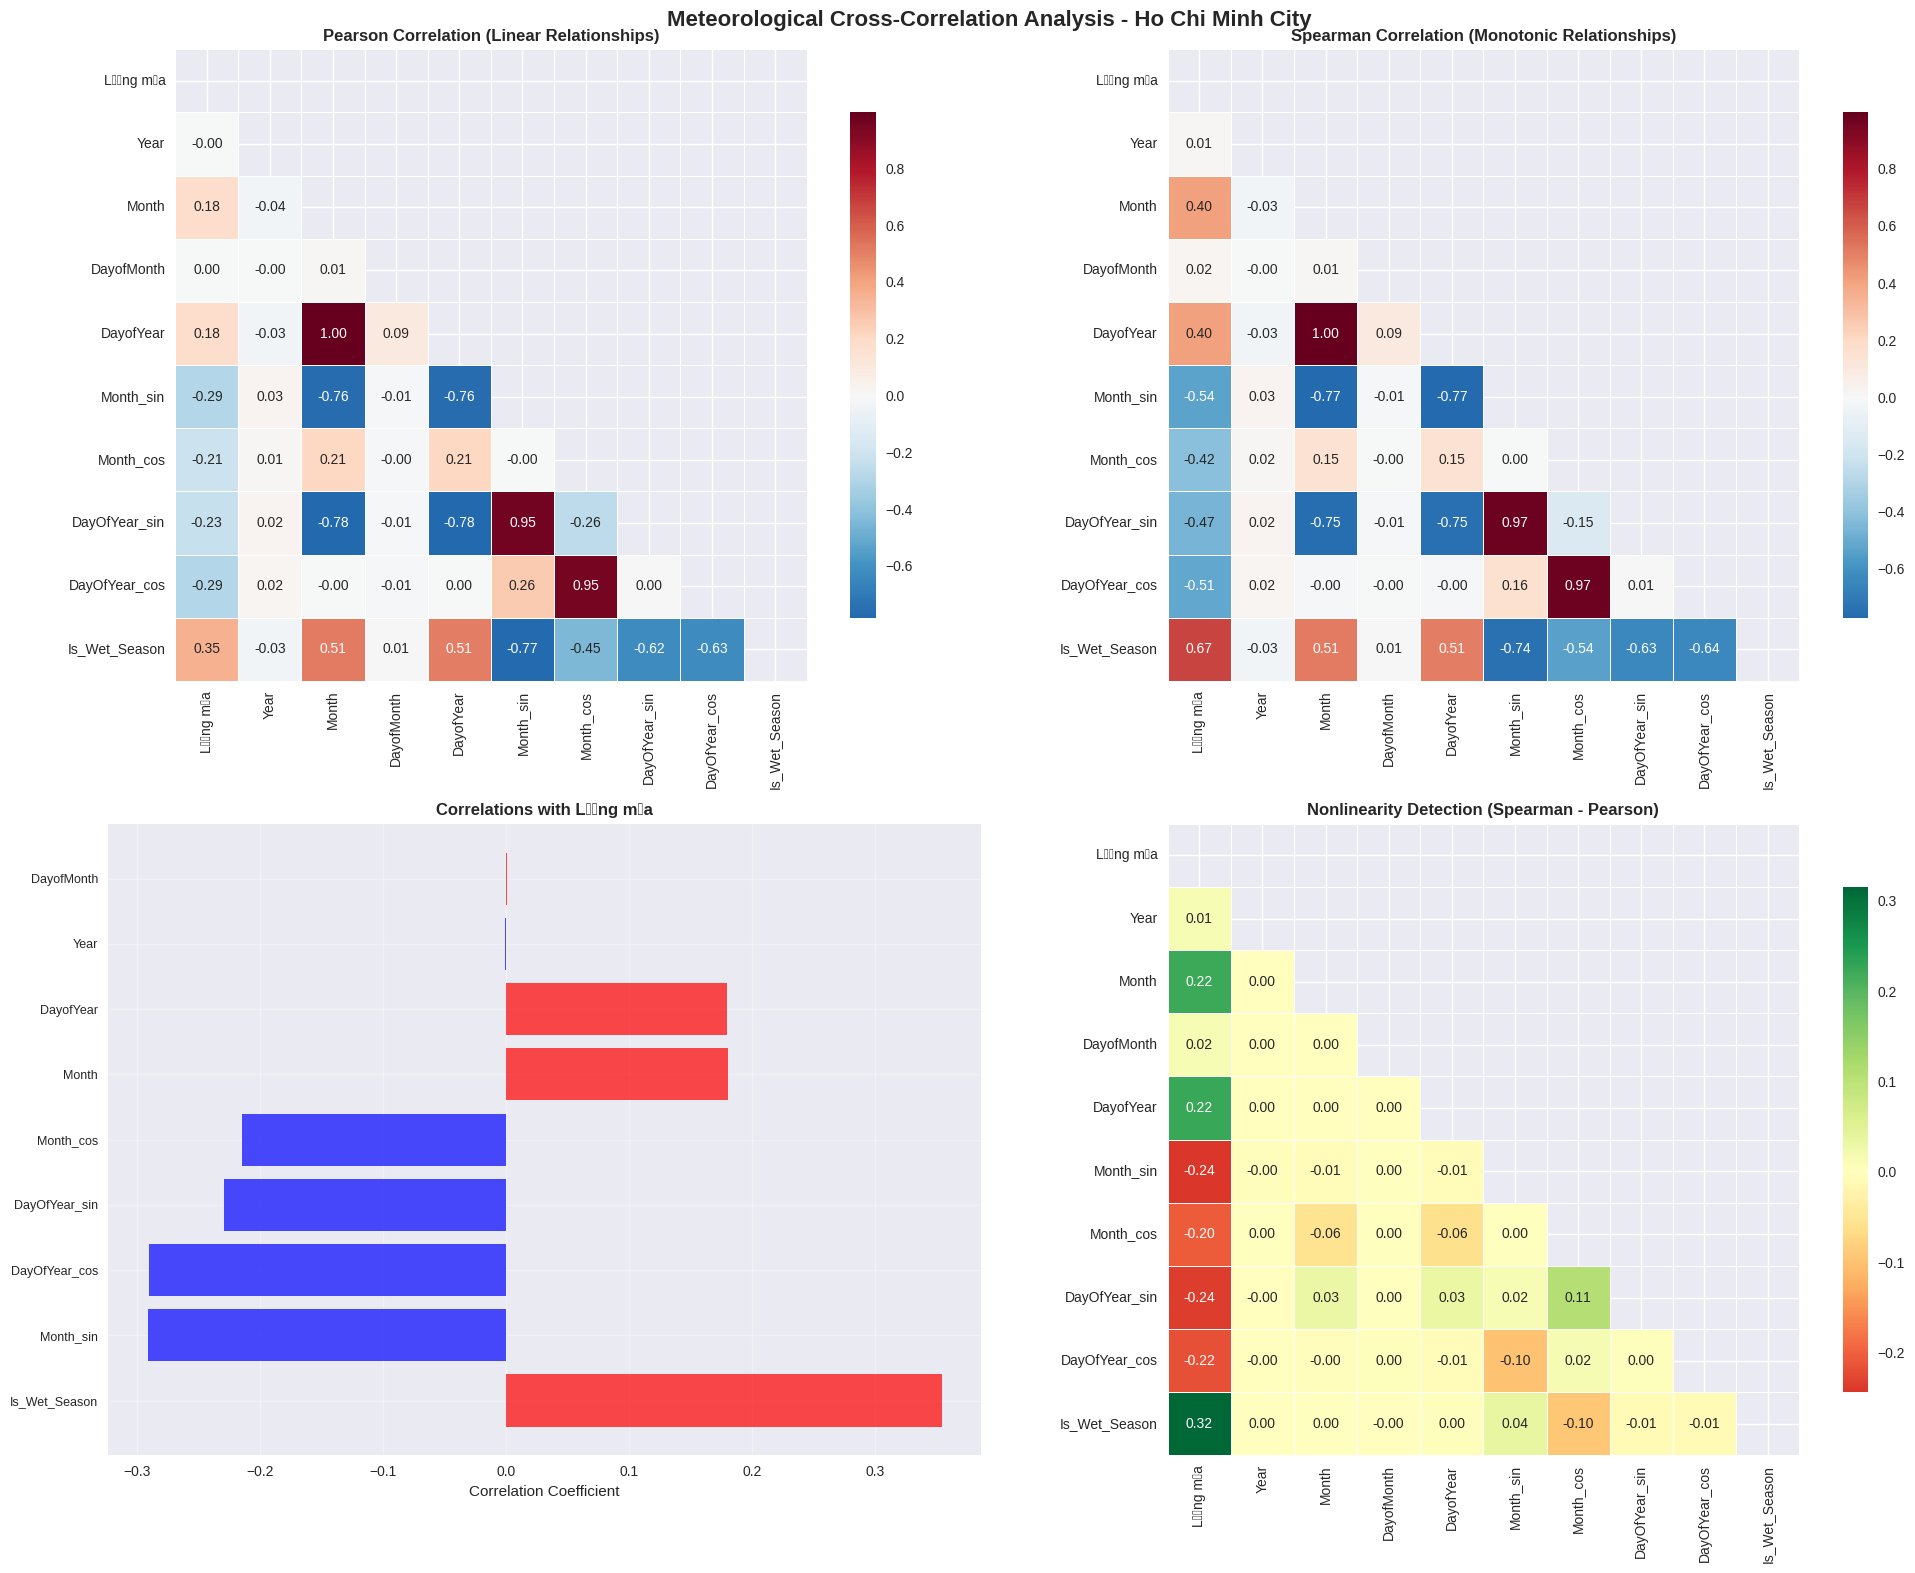


📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS
🌤️ 2.1 Seasonal Correlation Analysis
--------------------------------------------------


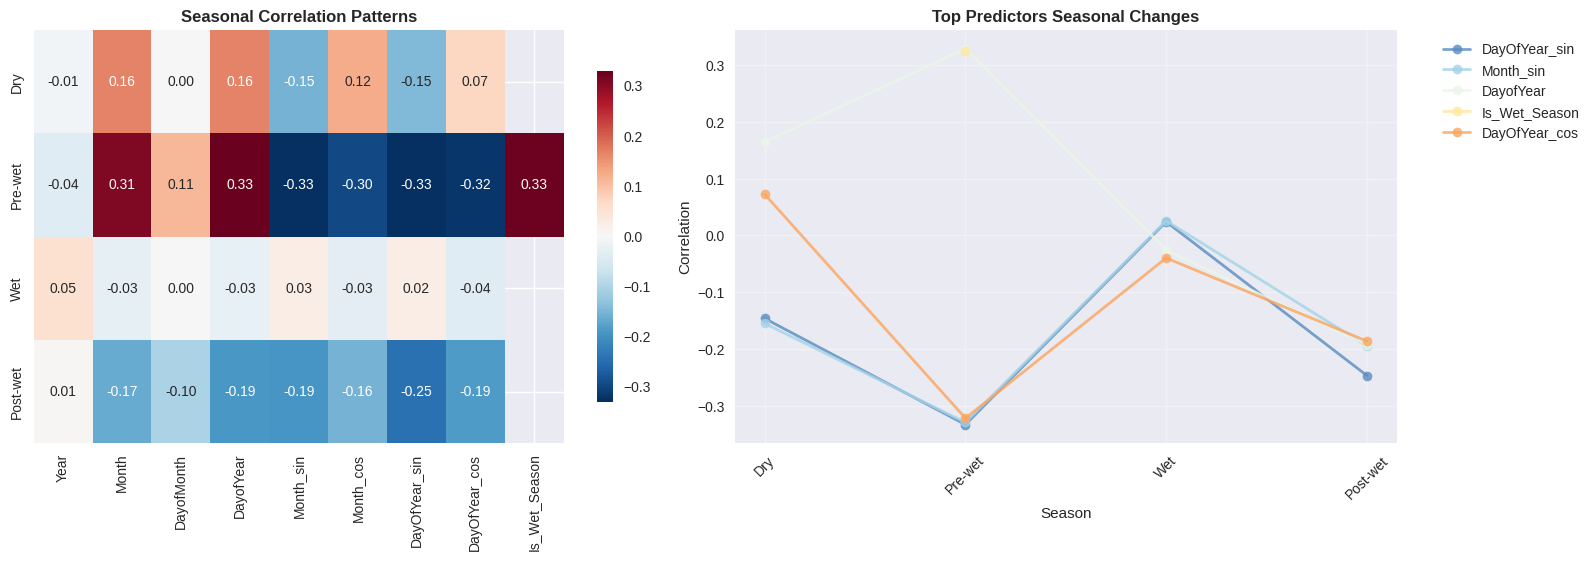


📈 2.2 Rolling Correlation Analysis
--------------------------------------------------

⏰ 2.3 Lagged Correlation Analysis
--------------------------------------------------

🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
      Feature    VIF_Score Category Risk_Level
    DayofYear 33954.629645    Other       High
        Month 33430.772684    Other       High
   DayofMonth   236.447223    Other       High
    Month_sin    48.805105    Other       High
    Month_cos    45.649624    Other       High
DayOfYear_sin    44.193008    Other       High
DayOfYear_cos    43.730236    Other       High
Is_Wet_Season     4.946675    Other        Low
         Year     1.001814    Other        Low

🕸️ 4. FEATURE INTERACTION NETWORK
🕸️ Network: 10 nodes, 18 edges
   Density: 0.400

🔬 6. ADVANCED CORRELATION CLUSTERING & PCA ANALYSIS
📊 6.1 Feature Standardization
--------------------------------------------------
🌳 6.2 Hierarchical Feature Clustering
---------------------

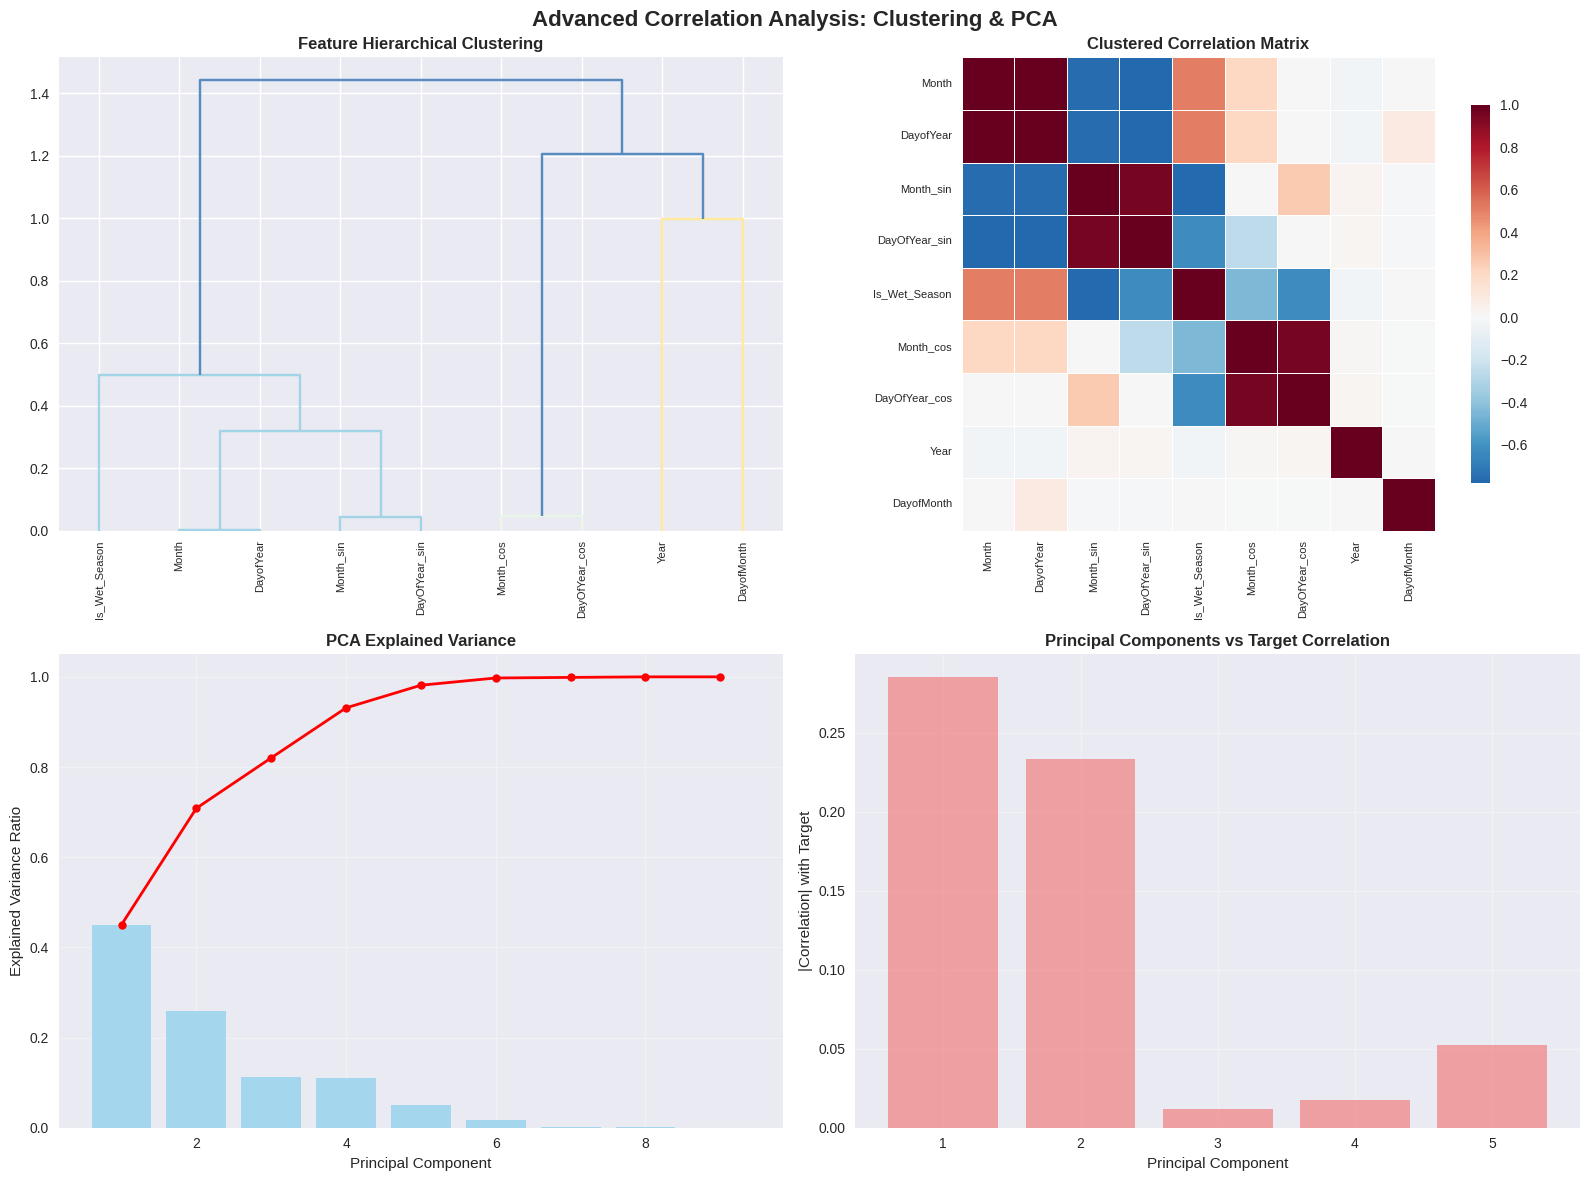


🎯 HO CHI MINH CITY WEATHER CORRELATION EXECUTIVE SUMMARY:
🌧️ PRECIPITATION PREDICTION INSIGHTS:
   - Strong predictors (|r| > 0.3): 1
   - Moderate predictors (0.2 < |r| ≤ 0.3): 4

📈 DYNAMIC CORRELATION INSIGHTS:
   - Is_Wet_Season: Variable correlation
   - Month: Variable correlation

⏰ LAGGED CORRELATION INSIGHTS:
   - Is_Wet_Season: best at -5 days (r=0.358)
   - Month: best at -5 days (r=0.198)

🔬 ADVANCED CLUSTERING INSIGHTS:
   - Feature clusters identified: 3
   - Top PC explains 45.0% variance
   - Top PC correlation with target: 0.285

✅ CLEANED ANALYSIS COMPLETED

PART 3: LAG FEATURES CORRELATION ANALYSIS
🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS
🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9223, 12)
   🎯 Target Variable: Lượng mưa
   📍 Geographic Scope: Ho Chi Minh City (Single Location)
   🔢 Total Features: 11
   📈 Predictor Features: 10

📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX A

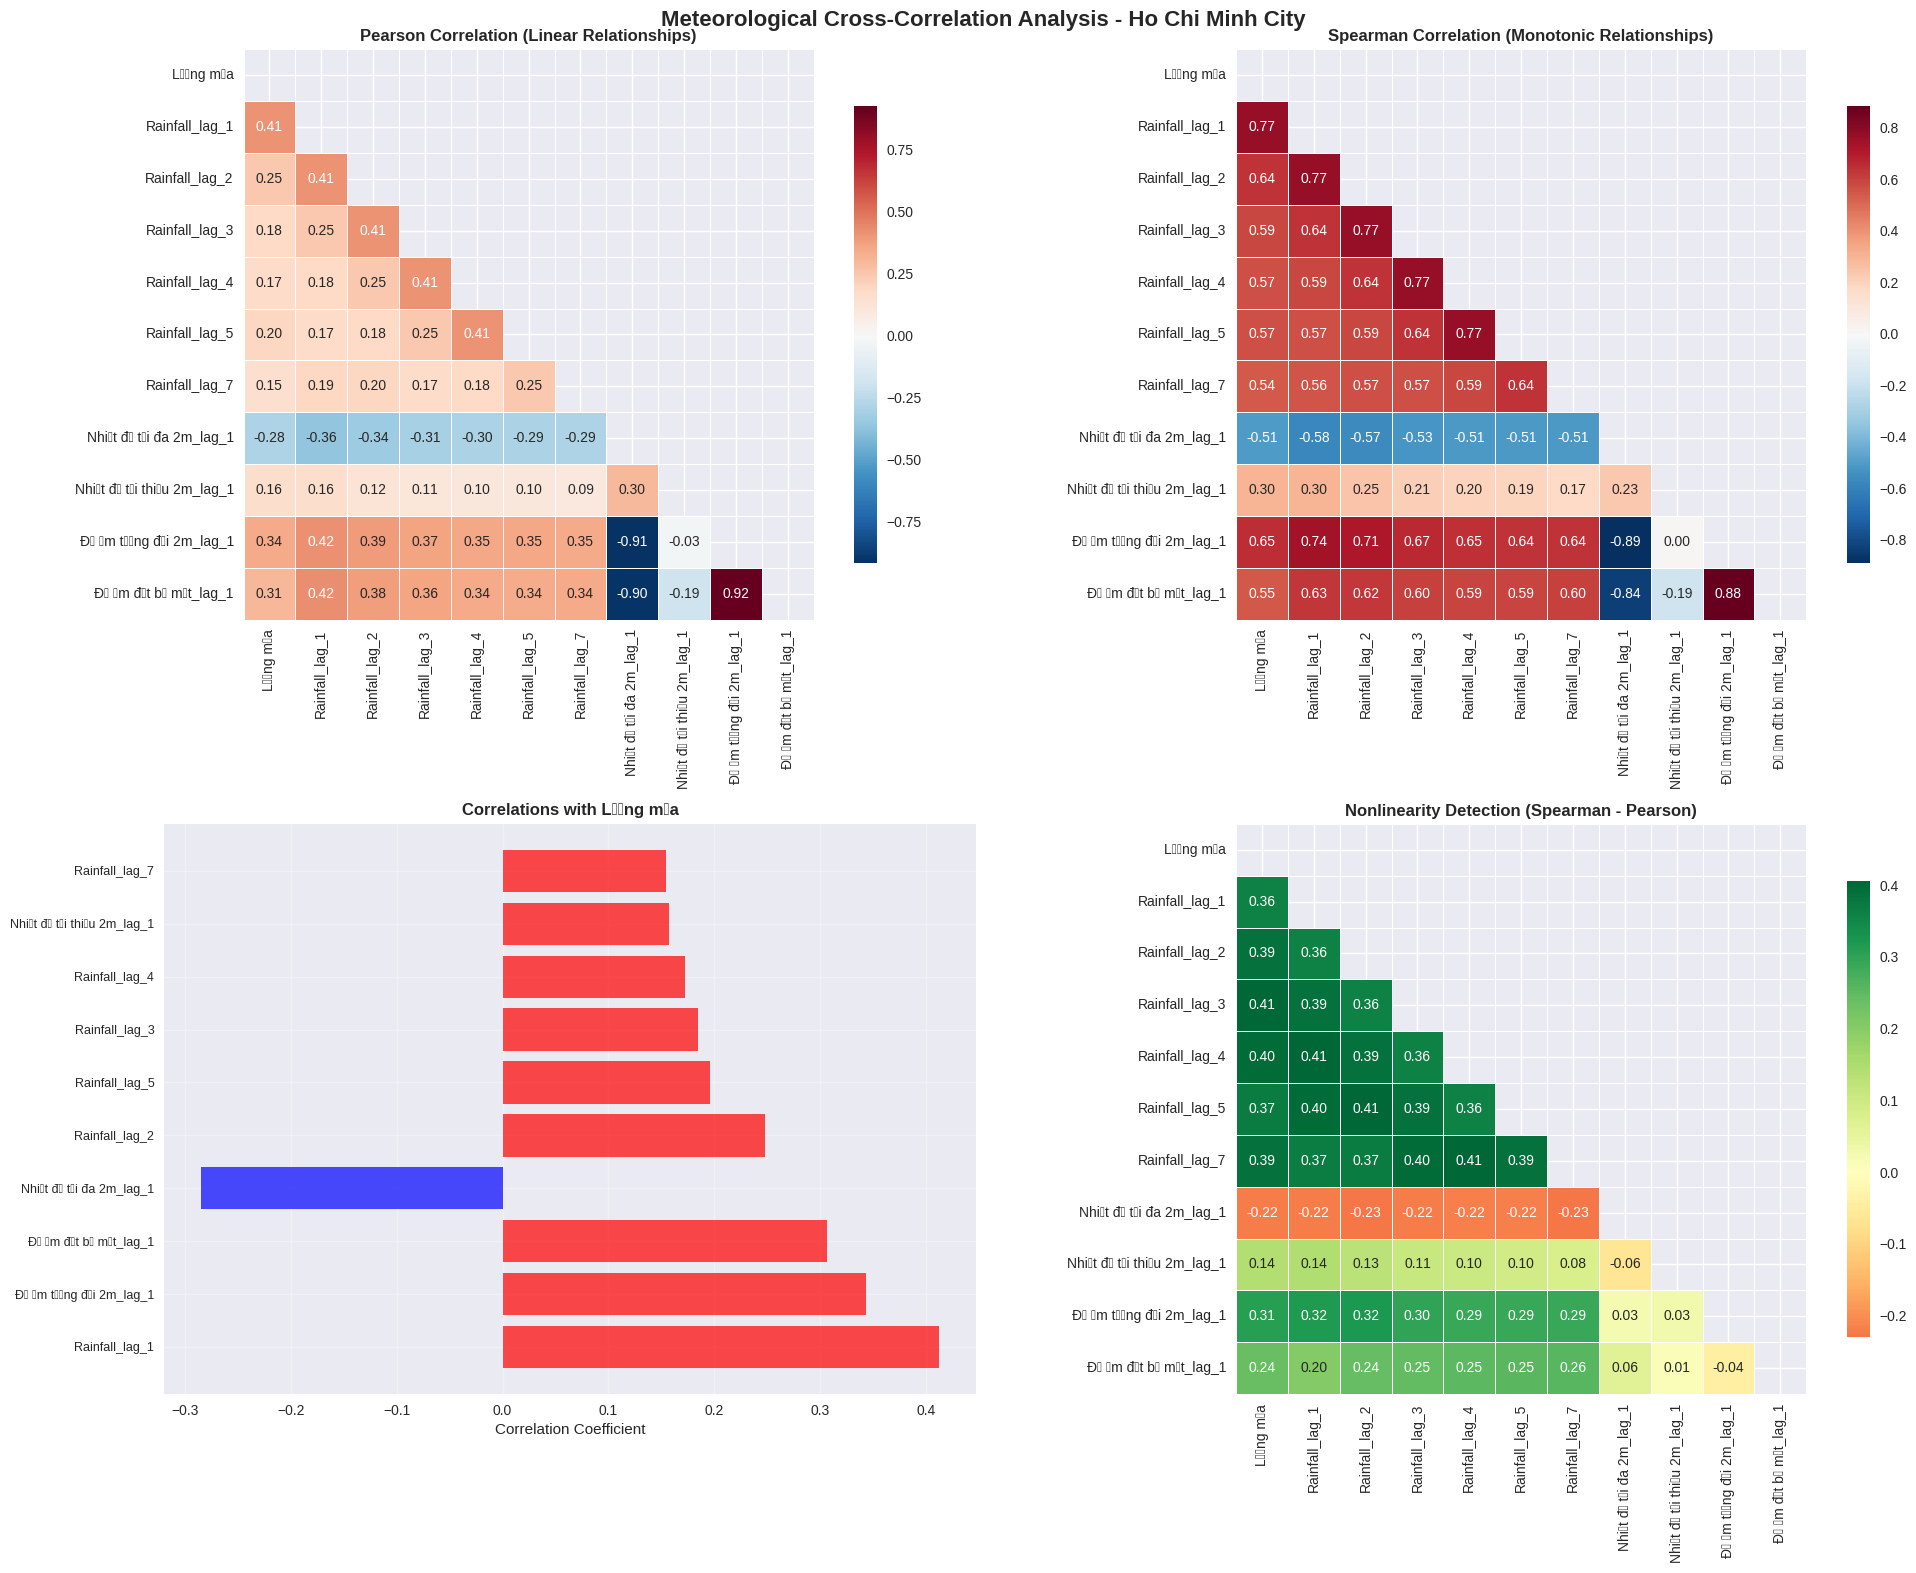


📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS
🌤️ 2.1 Seasonal Correlation Analysis
--------------------------------------------------


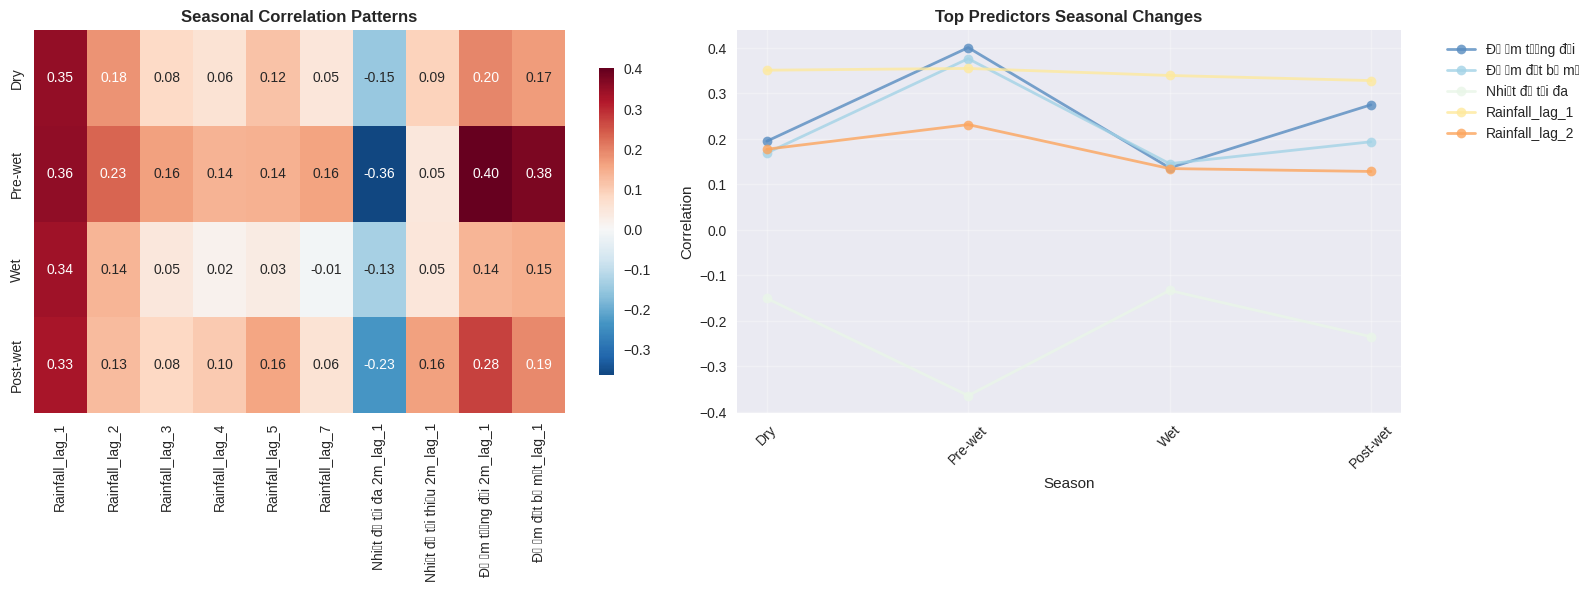


📈 2.2 Rolling Correlation Analysis
--------------------------------------------------

⏰ 2.3 Lagged Correlation Analysis
--------------------------------------------------

🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
                    Feature  VIF_Score    Category Risk_Level
   Độ ẩm tương đối 2m_lag_1  16.136181    Humidity       High
   Nhiệt độ tối đa 2m_lag_1  11.365947 Temperature       High
     Độ ẩm đất bề mặt_lag_1   9.316965    Humidity   Moderate
Nhiệt độ tối thiểu 2m_lag_1   2.235992 Temperature        Low
             Rainfall_lag_2   1.432926       Other        Low
             Rainfall_lag_3   1.420782       Other        Low
             Rainfall_lag_4   1.417196       Other        Low
             Rainfall_lag_1   1.415202       Other        Low
             Rainfall_lag_5   1.312683       Other        Low
             Rainfall_lag_7   1.187658       Other        Low

🕸️ 4. FEATURE INTERACTION NETWORK
🕸️ Network: 11 nodes, 30 edges

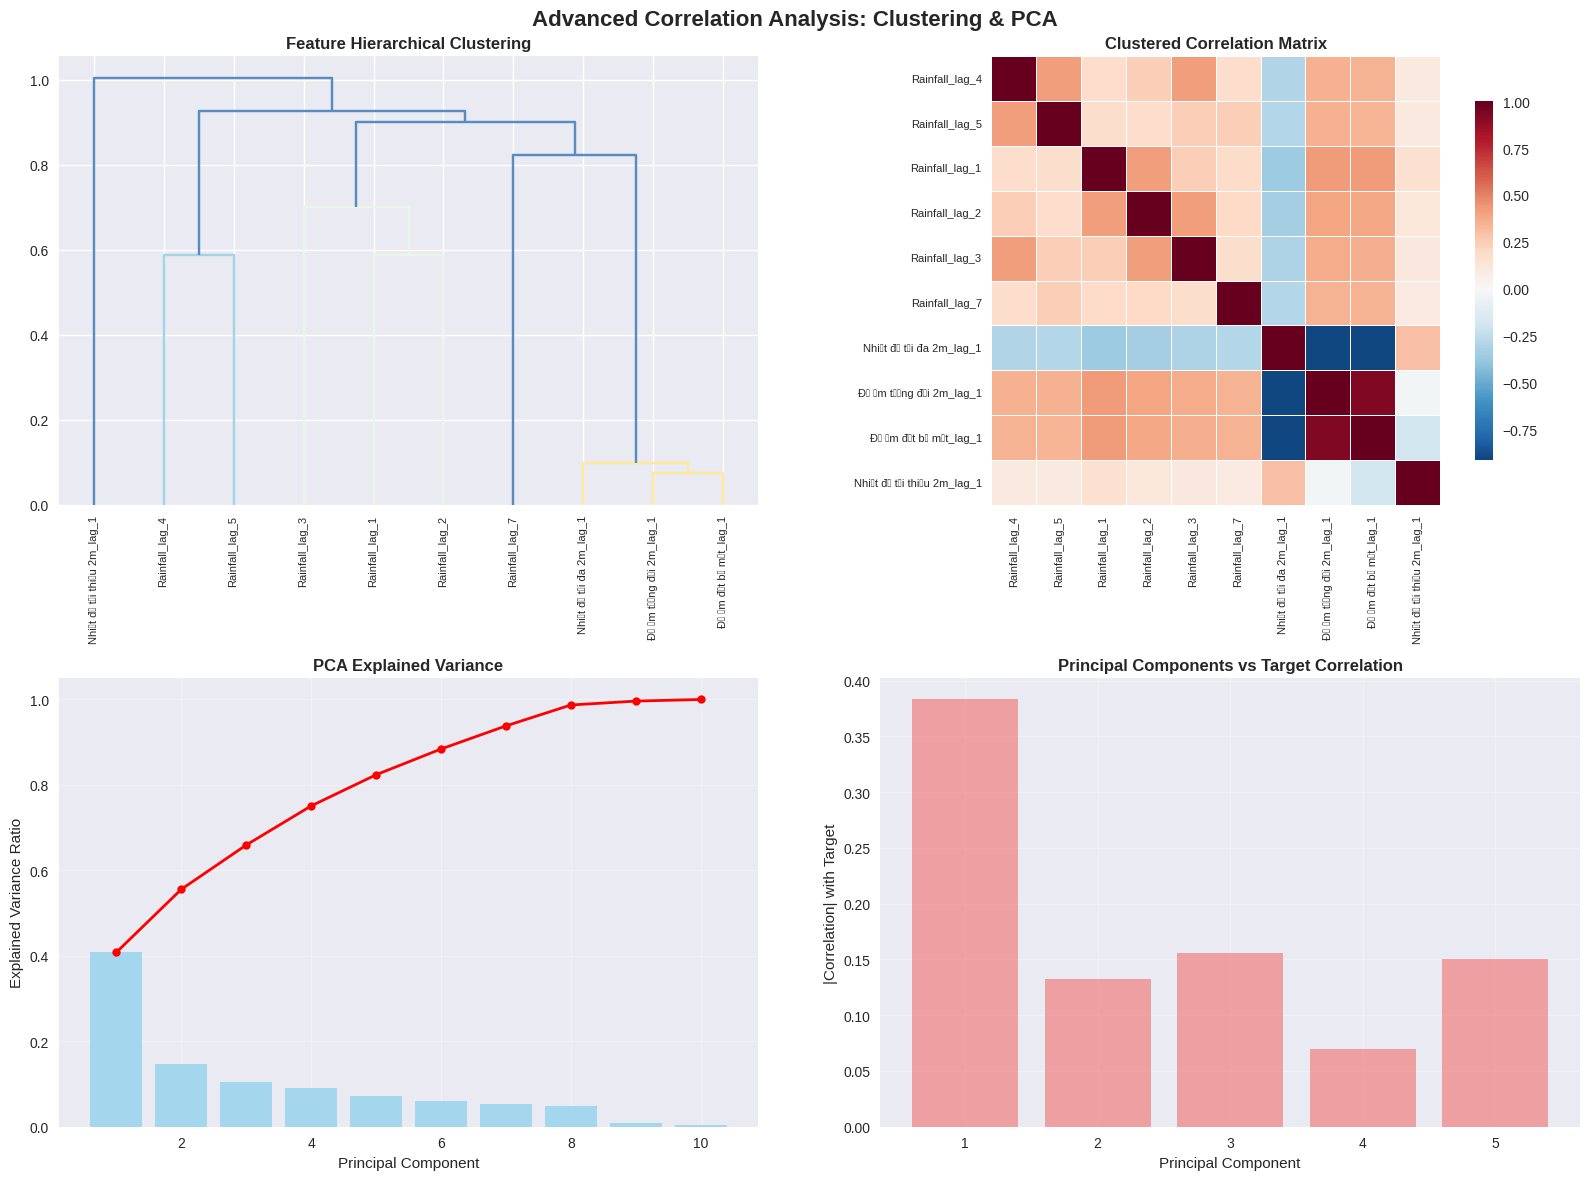


🎯 HO CHI MINH CITY WEATHER CORRELATION EXECUTIVE SUMMARY:
🌧️ PRECIPITATION PREDICTION INSIGHTS:
   - Strong predictors (|r| > 0.3): 3
   - Moderate predictors (0.2 < |r| ≤ 0.3): 2

📈 DYNAMIC CORRELATION INSIGHTS:
   - Rainfall_lag_1: Variable correlation
   - Độ ẩm tương đối 2m_lag_1: Variable correlation

⏰ LAGGED CORRELATION INSIGHTS:
   - Rainfall_lag_1: best at -1 days (r=1.000)
   - Độ ẩm tương đối 2m_lag_1: best at -1 days (r=0.419)

🔬 ADVANCED CLUSTERING INSIGHTS:
   - Feature clusters identified: 3
   - Top PC explains 40.8% variance
   - Top PC correlation with target: 0.383

✅ CLEANED ANALYSIS COMPLETED

PART 4: ROLLING WINDOW FEATURES CORRELATION ANALYSIS
🚀 STARTING CLEANED CITY-LEVEL CORRELATION ANALYSIS
🔍 CITY-LEVEL ADVANCED CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9223, 42)
   🎯 Target Variable: Lượng mưa
   📍 Geographic Scope: Ho Chi Minh City (Single Location)
   🔢 Total Features: 41
   📈 Predictor Features: 40

📋 5. ENHANCED CITY-LEVEL CORRELATION INSIGHT

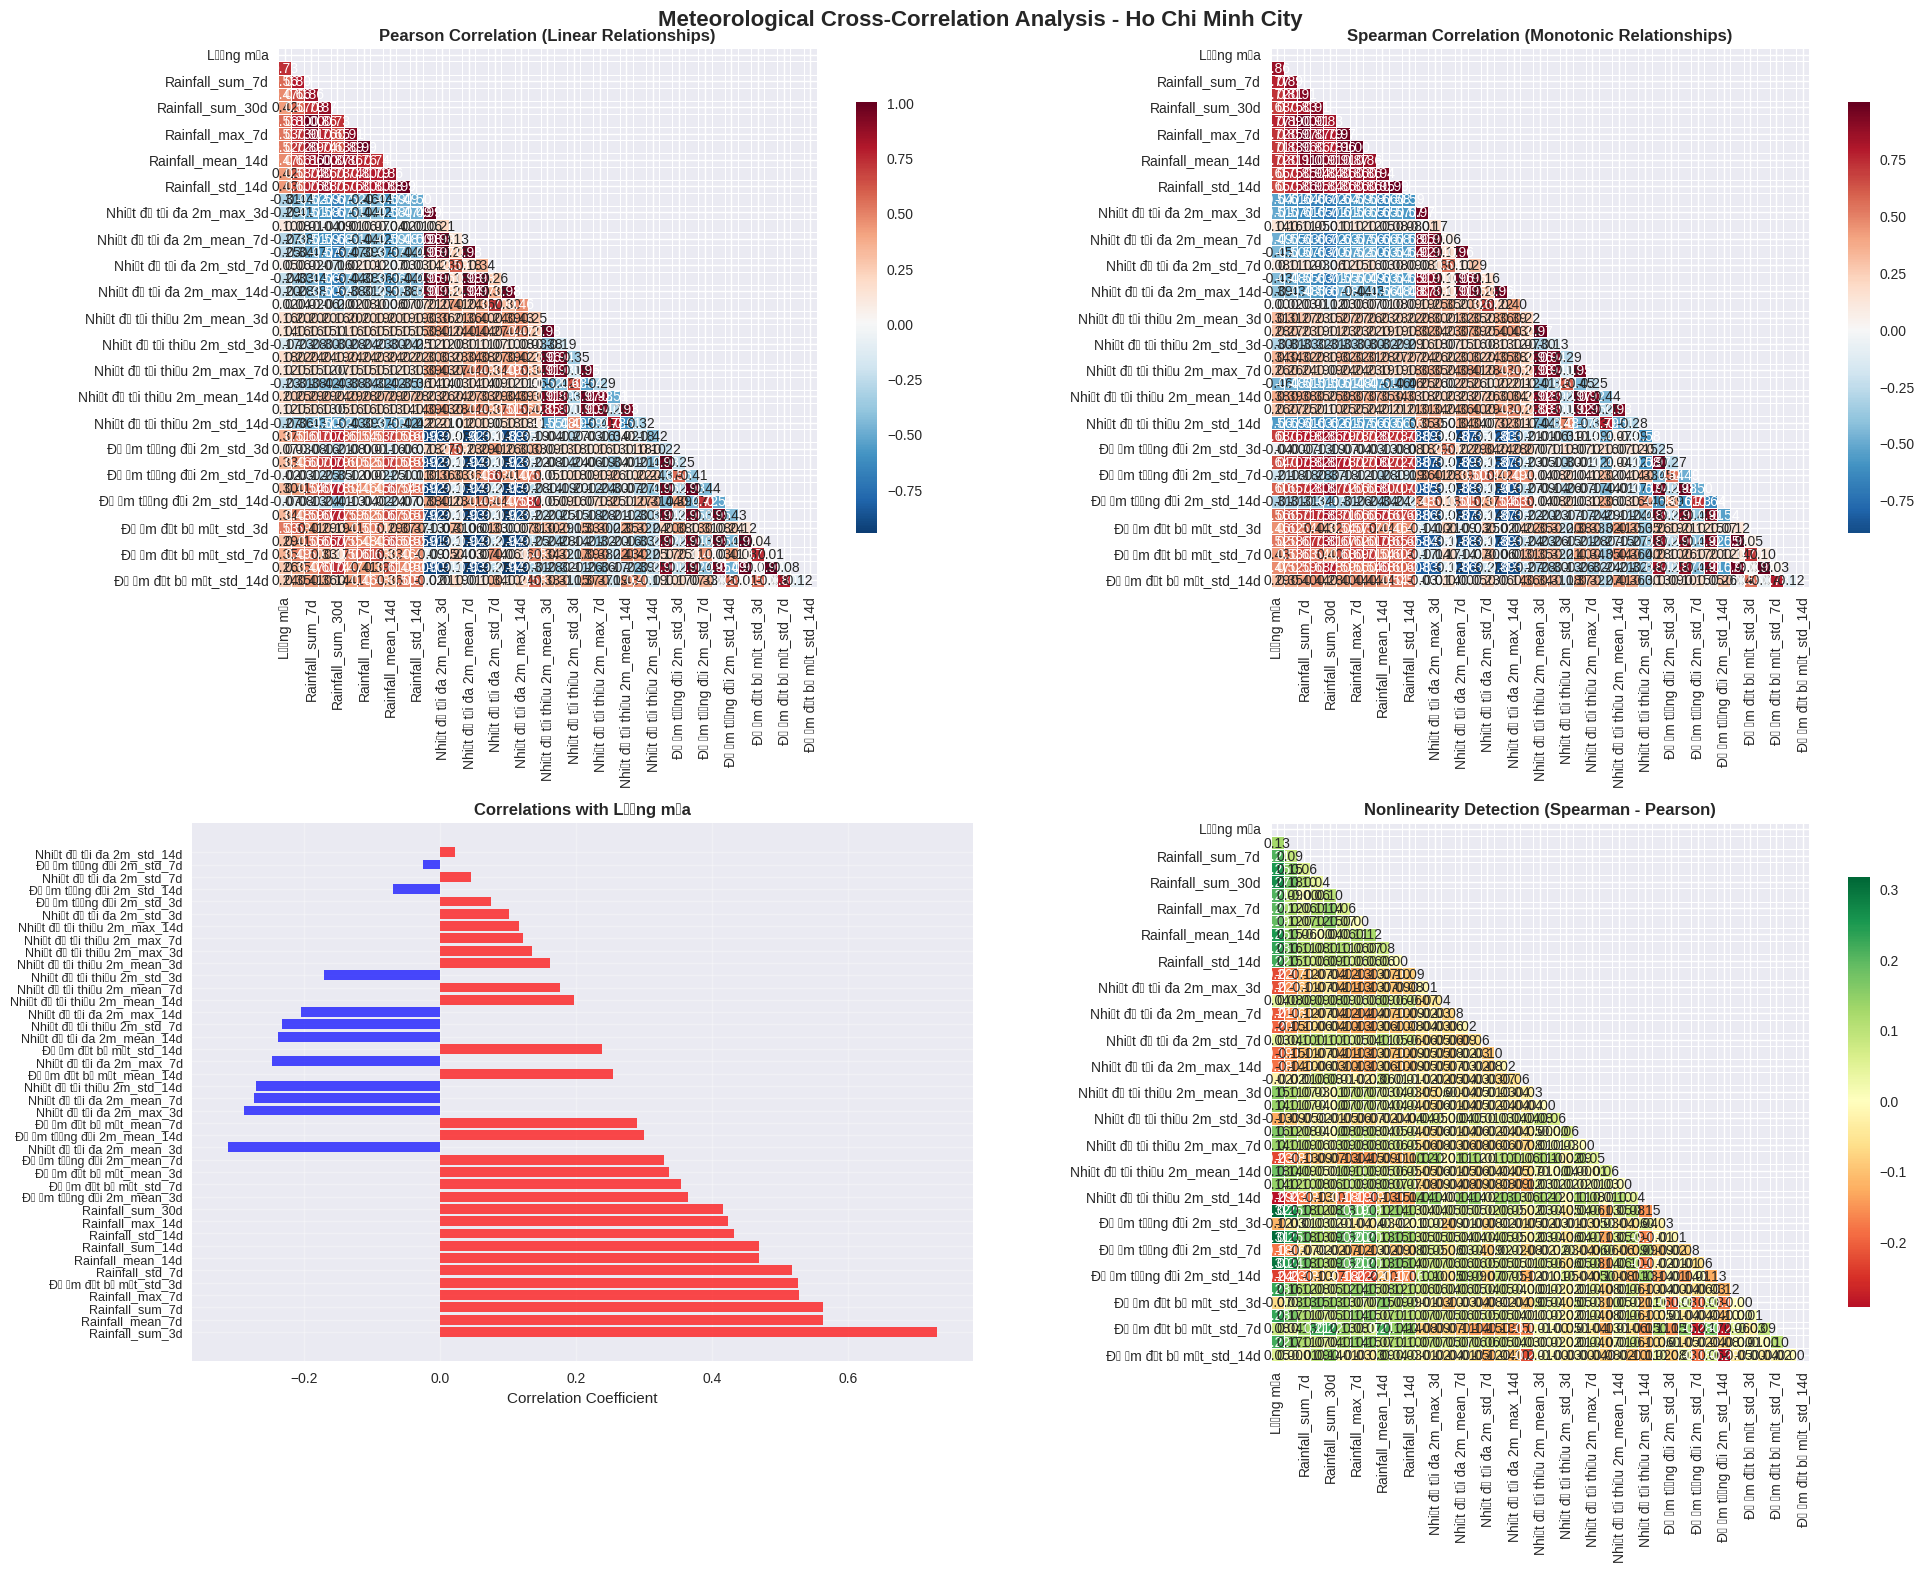


📅 2. ENHANCED TEMPORAL CORRELATION DYNAMICS
🌤️ 2.1 Seasonal Correlation Analysis
--------------------------------------------------


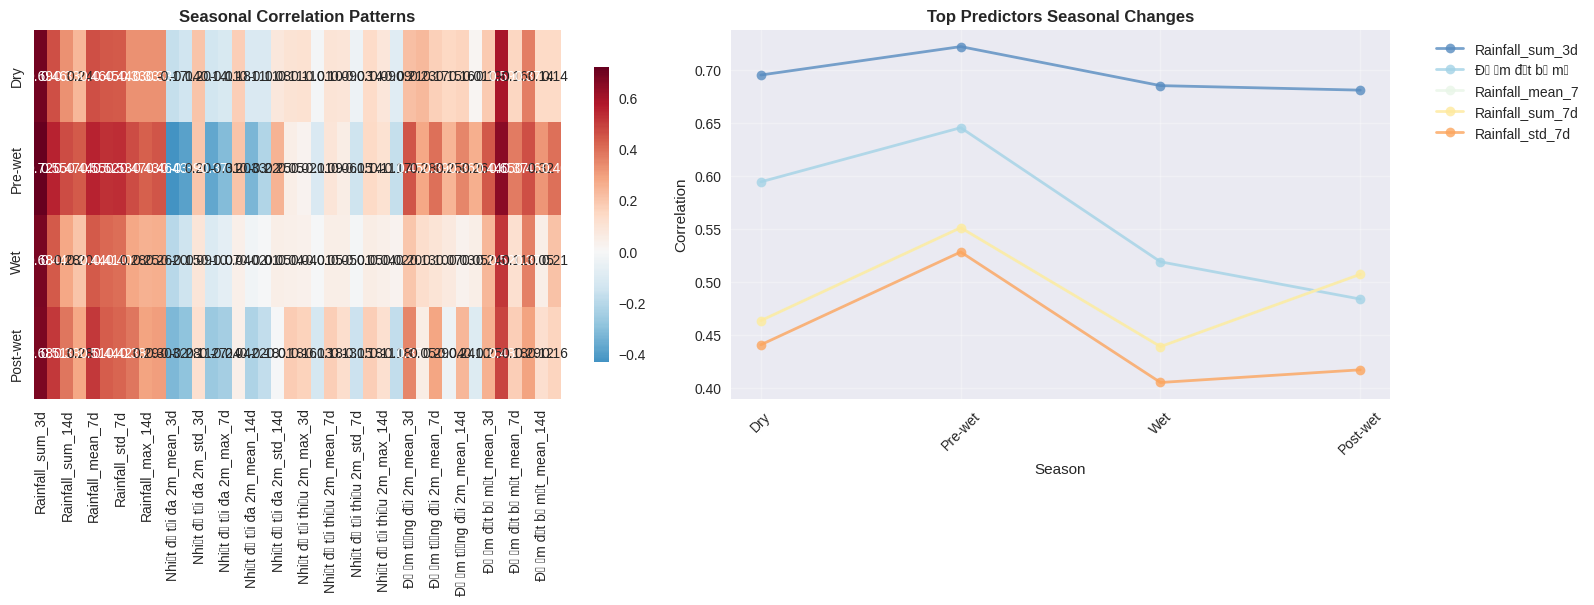


📈 2.2 Rolling Correlation Analysis
--------------------------------------------------

⏰ 2.3 Lagged Correlation Analysis
--------------------------------------------------

🔍 3. ADVANCED MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
                   Feature  VIF_Score    Category Risk_Level
           Rainfall_sum_7d        inf       Other       High
          Rainfall_sum_14d        inf       Other       High
         Rainfall_mean_14d        inf       Other       High
          Rainfall_mean_7d        inf       Other       High
  Độ ẩm đất bề mặt_mean_7d 719.640522    Humidity       High
Nhiệt độ tối đa 2m_mean_3d 382.269480 Temperature       High
 Độ ẩm đất bề mặt_mean_14d 368.501630    Humidity       High
 Nhiệt độ tối đa 2m_max_3d 360.298791 Temperature       High
  Độ ẩm đất bề mặt_mean_3d 332.868189    Humidity       High
Nhiệt độ tối đa 2m_mean_7d 277.452888 Temperature       High

🕸️ 4. FEATURE INTERACTION NETWORK
🕸️ Network: 41 nodes, 517 edges
   Densit

ValueError: Linkage 'Z' contains negative distances.

In [ ]:
# ==============================================================================
# MULTICOLLINEARITY & CROSS-CORRELATION CHECKING (4 PARTS)
# ==============================================================================

# Define feature groups
print("🔍 Defining Feature Groups for Correlation Analysis...")

# 1. Original selected features (after feature selection)
original_features = ['Ngày', 'Lượng mưa'] + [
    'Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m',
    'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống'
]

# 2. Temporal features
temporal_features = ['Ngày', 'Lượng mưa'] + [
    'Year', 'Month', 'DayofMonth', 'DayofYear',
    'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'Is_Wet_Season'
]

# 3. Lag features
lag_columns = ['Ngày', 'Lượng mưa'] + [col for col in df_selected.columns if '_lag_' in col]

# 4. Rolling window features
rolling_columns = ['Ngày', 'Lượng mưa'] + [col for col in df_selected.columns
                   if any(pattern in col for pattern in ['_sum_', '_mean_', '_max_', '_std_'])
                   and col.endswith('d')]

print(f"📊 Feature Groups Summary:")
print(f"   Original features: {len(original_features)-2}")
print(f"   Temporal features: {len(temporal_features)-2}")
print(f"   Lag features: {len(lag_columns)-2}")
print(f"   Rolling features: {len(rolling_columns)-2}")

# Part 1: Original Features Analysis
print("\n" + "="*50)
print("PART 1: ORIGINAL FEATURES CORRELATION ANALYSIS")
print("="*50)
df_original = df_selected[original_features].copy()
original_results = run_city_level_correlation_analysis(
    df_original,
    target_col='Lượng mưa',
    date_col='Ngày'
)

# Part 2: Temporal Features Analysis
print("\n" + "="*50)
print("PART 2: TEMPORAL FEATURES CORRELATION ANALYSIS")
print("="*50)
df_temporal = df_selected[temporal_features].copy()
temporal_results = run_city_level_correlation_analysis(
    df_temporal,
    target_col='Lượng mưa',
    date_col='Ngày'
)

# Part 3: Lag Features Analysis
print("\n" + "="*50)
print("PART 3: LAG FEATURES CORRELATION ANALYSIS")
print("="*50)
df_lag = df_selected[lag_columns].copy()
lag_results = run_city_level_correlation_analysis(
    df_lag,
    target_col='Lượng mưa',
    date_col='Ngày'
)

# Part 4: Rolling Window Features Analysis
print("\n" + "="*50)
print("PART 4: ROLLING WINDOW FEATURES CORRELATION ANALYSIS")
print("="*50)
df_rolling = df_selected[rolling_columns].copy()
rolling_results = run_city_level_correlation_analysis(
    df_rolling,
    target_col='Lượng mưa',
    date_col='Ngày'
)

print("\n✅ All correlation analyses completed!")

# Modeling

## Tree-based model

In [ ]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.7 MB/s eta 0:00:00


In [ ]:
# ==============================================================================
# LIGHTGBM TWO-STAGE MODEL WITH OPTUNA OPTIMIZATION (FIXED)
# ==============================================================================

import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("🚀 LIGHTGBM TWO-STAGE MODEL EXPERIMENTATION (FIXED)")
print("="*60)

print(f"📊 Data Setup:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Total samples: {len(X)}")
print(f"   Rain days: {y_clf.sum()} ({y_clf.mean()*100:.1f}%)")
print(f"   No rain days: {(1-y_clf).sum()} ({(1-y_clf.mean())*100:.1f}%)")

# Fixed Optuna optimization functions
def objective_classification_fixed(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1
    }

    auc_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_clf.iloc[train_idx], y_clf.iloc[test_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_data, num_boost_round=100)  # Removed verbose_eval

        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

def objective_regression_fixed(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbosity': -1
    }

    mae_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

        rain_mask_train = y_clf.iloc[train_idx] == 1
        rain_mask_test = y_clf.iloc[test_idx] == 1

        if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
            X_train_rain = X_train[rain_mask_train]
            y_train_rain = y_train[rain_mask_train]
            X_test_rain = X_test[rain_mask_test]
            y_test_rain = y_test[rain_mask_test]

            train_data = lgb.Dataset(X_train_rain, label=y_train_rain)
            model = lgb.train(params, train_data, num_boost_round=100)  # Removed verbose_eval

            y_pred = model.predict(X_test_rain)
            mae = mean_absolute_error(y_test_rain, y_pred)
            mae_scores.append(mae)

    return np.mean(mae_scores) if mae_scores else float('inf')

# Optimize Classification Model
print("\n🔍 Optimizing Classification Model...")
study_clf_fixed = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_clf_fixed.optimize(objective_classification_fixed, n_trials=20)
best_params_clf_fixed = study_clf_fixed.best_params
print(f"   Best AUC: {study_clf_fixed.best_value:.4f}")

# Optimize Regression Model
print("\n🔍 Optimizing Regression Model...")
study_reg_fixed = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_reg_fixed.optimize(objective_regression_fixed, n_trials=20)
best_params_reg_fixed = study_reg_fixed.best_params
print(f"   Best MAE: {study_reg_fixed.best_value:.4f}")

# Final evaluation with best parameters
print("\n📊 Final Evaluation with Best Parameters:")
clf_results_fixed = {'AUC': []}
reg_results_fixed = {'MAE': [], 'RMSE': [], 'R2': []}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n🔄 Fold {fold + 1}/3")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_clf, y_test_clf = y_clf.iloc[train_idx], y_clf.iloc[test_idx]
    y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # Classification Model
    best_params_clf_fixed.update({'objective': 'binary', 'metric': 'auc', 'verbosity': -1})
    train_data_clf = lgb.Dataset(X_train, label=y_train_clf)
    clf_model = lgb.train(best_params_clf_fixed, train_data_clf, num_boost_round=100)

    clf_pred = clf_model.predict(X_test)
    auc = roc_auc_score(y_test_clf, clf_pred)
    clf_results_fixed['AUC'].append(auc)

    # Regression Model
    rain_mask_train = y_train_clf == 1
    rain_mask_test = y_test_clf == 1

    if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
        X_train_rain = X_train[rain_mask_train]
        y_train_rain = y_train_reg[rain_mask_train]
        X_test_rain = X_test[rain_mask_test]
        y_test_rain = y_test_reg[rain_mask_test]

        best_params_reg_fixed.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1})
        train_data_reg = lgb.Dataset(X_train_rain, label=y_train_rain)
        reg_model = lgb.train(best_params_reg_fixed, train_data_reg, num_boost_round=100)

        reg_pred = reg_model.predict(X_test_rain)
        mae = mean_absolute_error(y_test_rain, reg_pred)
        rmse = np.sqrt(mean_squared_error(y_test_rain, reg_pred))
        r2 = r2_score(y_test_rain, reg_pred)

        reg_results_fixed['MAE'].append(mae)
        reg_results_fixed['RMSE'].append(rmse)
        reg_results_fixed['R2'].append(r2)

    print(f"   Classification AUC: {auc:.4f}")
    if rain_mask_test.sum() > 0:
        print(f"   Regression MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Summary Results
print("\n" + "="*60)
print("📋 LIGHTGBM FINAL RESULTS SUMMARY (FIXED)")
print("="*60)
print(f"Classification Model:")
print(f"   AUC: {np.mean(clf_results_fixed['AUC']):.4f} ± {np.std(clf_results_fixed['AUC']):.4f}")

if reg_results_fixed['MAE']:
    print(f"\nRegression Model (on rainy days only):")
    print(f"   MAE:  {np.mean(reg_results_fixed['MAE']):.4f} ± {np.std(reg_results_fixed['MAE']):.4f}")
    print(f"   RMSE: {np.mean(reg_results_fixed['RMSE']):.4f} ± {np.std(reg_results_fixed['RMSE']):.4f}")
    print(f"   R2:   {np.mean(reg_results_fixed['R2']):.4f} ± {np.std(reg_results_fixed['R2']):.4f}")

[I 2025-06-12 04:50:50,088] A new study created in memory with name: no-name-3bb05688-66fb-4f6f-82d4-3e3fd9c4b172


🚀 LIGHTGBM TWO-STAGE MODEL EXPERIMENTATION (FIXED)
📊 Data Setup:
   Total features: 72
   Total samples: 9223
   Rain days: 6853 (74.3%)
   No rain days: 2370 (25.7%)

🔍 Optimizing Classification Model...


[I 2025-06-12 04:50:57,136] Trial 0 finished with value: 0.9823208803543008 and parameters: {'num_leaves': 44, 'learning_rate': 0.28570714885887566, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'min_child_samples': 19}. Best is trial 0 with value: 0.9823208803543008.
[I 2025-06-12 04:50:58,715] Trial 1 finished with value: 0.9815140071163418 and parameters: {'num_leaves': 24, 'learning_rate': 0.026844247528777843, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'min_child_samples': 72}. Best is trial 0 with value: 0.9823208803543008.
[I 2025-06-12 04:50:59,784] Trial 2 finished with value: 0.9819301713692977 and parameters: {'num_leaves': 11, 'learning_rate': 0.29127385712697834, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'min_child_samples': 22}. Best is trial 0 with value: 0.9823208803543008.
[I 2025-06-12 04:51:01,540] Trial 3 finished with value: 0.983044830889871 and parameters: {'

   Best AUC: 0.9830

🔍 Optimizing Regression Model...


[I 2025-06-12 04:51:47,383] Trial 0 finished with value: 1.0731066359328187 and parameters: {'num_leaves': 44, 'learning_rate': 0.28570714885887566, 'feature_fraction': 0.839196365086843, 'bagging_fraction': 0.759195090518222, 'min_child_samples': 19}. Best is trial 0 with value: 1.0731066359328187.
[I 2025-06-12 04:51:48,795] Trial 1 finished with value: 1.5809026082169184 and parameters: {'num_leaves': 24, 'learning_rate': 0.026844247528777843, 'feature_fraction': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'min_child_samples': 72}. Best is trial 0 with value: 1.0731066359328187.
[I 2025-06-12 04:51:49,637] Trial 2 finished with value: 1.0865286469371382 and parameters: {'num_leaves': 11, 'learning_rate': 0.29127385712697834, 'feature_fraction': 0.899465584480253, 'bagging_fraction': 0.5274034664069657, 'min_child_samples': 22}. Best is trial 0 with value: 1.0731066359328187.
[I 2025-06-12 04:51:50,941] Trial 3 finished with value: 1.079917406221584 and parameters: {'

   Best MAE: 0.8887

📊 Final Evaluation with Best Parameters:

🔄 Fold 1/3
   Classification AUC: 0.9746
   Regression MAE: 1.1648, RMSE: 2.4007, R2: 0.9183

🔄 Fold 2/3
   Classification AUC: 0.9824
   Regression MAE: 0.6321, RMSE: 1.5632, R2: 0.9507

🔄 Fold 3/3
   Classification AUC: 0.9921
   Regression MAE: 0.8692, RMSE: 2.8363, R2: 0.9056

📋 LIGHTGBM FINAL RESULTS SUMMARY (FIXED)
Classification Model:
   AUC: 0.9830 ± 0.0071

Regression Model (on rainy days only):
   MAE:  0.8887 ± 0.2179
   RMSE: 2.2668 ± 0.5283
   R2:   0.9248 ± 0.0190


In [ ]:
# ==============================================================================
# XGBOOST TWO-STAGE MODEL WITH OPTUNA OPTIMIZATION
# ==============================================================================

import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("🚀 XGBOOST TWO-STAGE MODEL EXPERIMENTATION")
print("="*60)

# Use same data setup as LightGBM
print(f"📊 Data Setup:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Total samples: {len(X)}")
print(f"   Rain days: {y_clf.sum()} ({y_clf.mean()*100:.1f}%)")
print(f"   No rain days: {(1-y_clf).sum()} ({(1-y_clf.mean())*100:.1f}%)")

# Optuna optimization functions for XGBoost
def objective_classification_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
        'random_state': 42
    }

    auc_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_clf.iloc[train_idx], y_clf.iloc[test_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

    return np.mean(auc_scores)

def objective_regression_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
        'random_state': 42
    }

    mae_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

        # Only use rainy days for regression training
        rain_mask_train = y_clf.iloc[train_idx] == 1
        rain_mask_test = y_clf.iloc[test_idx] == 1

        if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
            X_train_rain = X_train[rain_mask_train]
            y_train_rain = y_train[rain_mask_train]
            X_test_rain = X_test[rain_mask_test]
            y_test_rain = y_test[rain_mask_test]

            model = xgb.XGBRegressor(**params)
            model.fit(X_train_rain, y_train_rain, verbose=False)

            y_pred = model.predict(X_test_rain)
            mae = mean_absolute_error(y_test_rain, y_pred)
            mae_scores.append(mae)

    return np.mean(mae_scores) if mae_scores else float('inf')

# Optimize Classification Model
print("\n🔍 Optimizing XGBoost Classification Model...")
study_clf_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_clf_xgb.optimize(objective_classification_xgb, n_trials=20)
best_params_clf_xgb = study_clf_xgb.best_params
print(f"   Best AUC: {study_clf_xgb.best_value:.4f}")

# Optimize Regression Model
print("\n🔍 Optimizing XGBoost Regression Model...")
study_reg_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_reg_xgb.optimize(objective_regression_xgb, n_trials=20)
best_params_reg_xgb = study_reg_xgb.best_params
print(f"   Best MAE: {study_reg_xgb.best_value:.4f}")

# Final evaluation with best parameters
print("\n📊 Final Evaluation with Best Parameters:")
clf_results_xgb = {'AUC': []}
reg_results_xgb = {'MAE': [], 'RMSE': [], 'R2': []}

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n🔄 Fold {fold + 1}/3")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_clf, y_test_clf = y_clf.iloc[train_idx], y_clf.iloc[test_idx]
    y_train_reg, y_test_reg = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    # Classification Model
    best_params_clf_xgb.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'verbosity': 0,
        'random_state': 42
    })
    clf_model_xgb = xgb.XGBClassifier(**best_params_clf_xgb)
    clf_model_xgb.fit(X_train, y_train_clf, verbose=False)

    # Classification predictions
    clf_pred_xgb = clf_model_xgb.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test_clf, clf_pred_xgb)
    clf_results_xgb['AUC'].append(auc)

    # Regression Model (only on rainy days)
    rain_mask_train = y_train_clf == 1
    rain_mask_test = y_test_clf == 1

    if rain_mask_train.sum() > 0 and rain_mask_test.sum() > 0:
        X_train_rain = X_train[rain_mask_train]
        y_train_rain = y_train_reg[rain_mask_train]
        X_test_rain = X_test[rain_mask_test]
        y_test_rain = y_test_reg[rain_mask_test]

        best_params_reg_xgb.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'verbosity': 0,
            'random_state': 42
        })
        reg_model_xgb = xgb.XGBRegressor(**best_params_reg_xgb)
        reg_model_xgb.fit(X_train_rain, y_train_rain, verbose=False)

        # Regression predictions
        reg_pred_xgb = reg_model_xgb.predict(X_test_rain)
        mae = mean_absolute_error(y_test_rain, reg_pred_xgb)
        rmse = np.sqrt(mean_squared_error(y_test_rain, reg_pred_xgb))
        r2 = r2_score(y_test_rain, reg_pred_xgb)

        reg_results_xgb['MAE'].append(mae)
        reg_results_xgb['RMSE'].append(rmse)
        reg_results_xgb['R2'].append(r2)

    print(f"   Classification AUC: {auc:.4f}")
    if rain_mask_test.sum() > 0:
        print(f"   Regression MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Summary Results
print("\n" + "="*60)
print("📋 XGBOOST FINAL RESULTS SUMMARY")
print("="*60)
print(f"Classification Model:")
print(f"   AUC: {np.mean(clf_results_xgb['AUC']):.4f} ± {np.std(clf_results_xgb['AUC']):.4f}")

if reg_results_xgb['MAE']:
    print(f"\nRegression Model (on rainy days only):")
    print(f"   MAE:  {np.mean(reg_results_xgb['MAE']):.4f} ± {np.std(reg_results_xgb['MAE']):.4f}")
    print(f"   RMSE: {np.mean(reg_results_xgb['RMSE']):.4f} ± {np.std(reg_results_xgb['RMSE']):.4f}")
    print(f"   R2:   {np.mean(reg_results_xgb['R2']):.4f} ± {np.std(reg_results_xgb['R2']):.4f}")

[I 2025-06-12 04:57:32,753] A new study created in memory with name: no-name-832498c2-cfef-44f1-9840-1f679b2b4f5a


🚀 XGBOOST TWO-STAGE MODEL EXPERIMENTATION
📊 Data Setup:
   Total features: 72
   Total samples: 9223
   Rain days: 6853 (74.3%)
   No rain days: 2370 (25.7%)

🔍 Optimizing XGBoost Classification Model...


[I 2025-06-12 04:57:44,508] Trial 0 finished with value: 0.9782485686630228 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 160, 'subsample': 0.759195090518222, 'colsample_bytree': 0.4936111842654619, 'min_child_weight': 2}. Best is trial 0 with value: 0.9782485686630228.
[I 2025-06-12 04:57:45,810] Trial 1 finished with value: 0.9781406186481121 and parameters: {'max_depth': 3, 'learning_rate': 0.2611910822747312, 'n_estimators': 140, 'subsample': 0.8248435466776274, 'colsample_bytree': 0.41235069657748147, 'min_child_weight': 10}. Best is trial 0 with value: 0.9782485686630228.
[I 2025-06-12 04:57:47,782] Trial 2 finished with value: 0.9786045545295982 and parameters: {'max_depth': 9, 'learning_rate': 0.07157834209670008, 'n_estimators': 77, 'subsample': 0.5100427059120604, 'colsample_bytree': 0.5825453457757226, 'min_child_weight': 6}. Best is trial 2 with value: 0.9786045545295982.
[I 2025-06-12 04:57:52,399] Trial 3 finished with value: 0.979

   Best AUC: 0.9835

🔍 Optimizing XGBoost Regression Model...


[I 2025-06-12 04:58:50,039] Trial 0 finished with value: 1.7871334547885285 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 160, 'subsample': 0.759195090518222, 'colsample_bytree': 0.4936111842654619, 'min_child_weight': 2}. Best is trial 0 with value: 1.7871334547885285.
[I 2025-06-12 04:58:51,325] Trial 1 finished with value: 1.4815583241266668 and parameters: {'max_depth': 3, 'learning_rate': 0.2611910822747312, 'n_estimators': 140, 'subsample': 0.8248435466776274, 'colsample_bytree': 0.41235069657748147, 'min_child_weight': 10}. Best is trial 1 with value: 1.4815583241266668.
[I 2025-06-12 04:58:58,180] Trial 2 finished with value: 1.5518992903097197 and parameters: {'max_depth': 9, 'learning_rate': 0.07157834209670008, 'n_estimators': 77, 'subsample': 0.5100427059120604, 'colsample_bytree': 0.5825453457757226, 'min_child_weight': 6}. Best is trial 1 with value: 1.4815583241266668.
[I 2025-06-12 04:59:01,849] Trial 3 finished with value: 1.323

   Best MAE: 0.8435

📊 Final Evaluation with Best Parameters:

🔄 Fold 1/3
   Classification AUC: 0.9756
   Regression MAE: 1.0335, RMSE: 1.9164, R2: 0.9479

🔄 Fold 2/3
   Classification AUC: 0.9829
   Regression MAE: 0.6212, RMSE: 1.2897, R2: 0.9664

🔄 Fold 3/3
   Classification AUC: 0.9919
   Regression MAE: 0.8759, RMSE: 2.8554, R2: 0.9043

📋 XGBOOST FINAL RESULTS SUMMARY
Classification Model:
   AUC: 0.9835 ± 0.0066

Regression Model (on rainy days only):
   MAE:  0.8435 ± 0.1698
   RMSE: 2.0205 ± 0.6434
   R2:   0.9396 ± 0.0260


## Times series model

In [ ]:
# ==============================================================================
# STATIONARITY TESTING FOR EXOGENOUS FEATURES (ADF & KPSS)
# ==============================================================================

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# Define exogenous features (original selected features)
exogenous_features = [
    'Nhiệt độ tối đa 2m',      # T2M_MAX
    'Nhiệt độ tối thiểu 2m',    # T2M_MIN
    'Độ ẩm tương đối 2m',       # RH2M
    'Độ ẩm đất bề mặt',         # GWETTOP
    'Hướng gió 10m',            # WD10M
    'Áp suất bề mặt',           # PS
    'Bức xạ sóng dài xuống'     # ALLSKY_SFC_LW_DWN
]

print("📊 STATIONARITY TESTING FOR EXOGENOUS FEATURES")
print("="*60)

stationarity_results = {}

for feature in exogenous_features:
    print(f"\n🔍 Testing: {feature}")

    # ADF Test
    adf_result = adfuller(df_selected[feature].dropna())
    adf_stationary = adf_result[1] < 0.05

    # KPSS Test
    kpss_result = kpss(df_selected[feature].dropna())
    kpss_stationary = kpss_result[1] > 0.05

    # Overall conclusion
    if adf_stationary and kpss_stationary:
        conclusion = "STATIONARY"
    elif not adf_stationary and not kpss_stationary:
        conclusion = "NON-STATIONARY"
    else:
        conclusion = "INCONCLUSIVE"

    # Store results
    stationarity_results[feature] = {
        'ADF_pvalue': adf_result[1],
        'ADF_stationary': adf_stationary,
        'KPSS_pvalue': kpss_result[1],
        'KPSS_stationary': kpss_stationary,
        'Conclusion': conclusion
    }

    print(f"   ADF p-value: {adf_result[1]:.6f} ({'Stationary' if adf_stationary else 'Non-stationary'})")
    print(f"   KPSS p-value: {kpss_result[1]:.6f} ({'Stationary' if kpss_stationary else 'Non-stationary'})")
    print(f"   ➤ Conclusion: {conclusion}")

# Summary
print("\n" + "="*60)
print("📋 STATIONARITY SUMMARY:")
stationary_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'STATIONARY')
non_stationary_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'NON-STATIONARY')
inconclusive_count = sum(1 for r in stationarity_results.values() if r['Conclusion'] == 'INCONCLUSIVE')

print(f"   Stationary features: {stationary_count}")
print(f"   Non-stationary features: {non_stationary_count}")
print(f"   Inconclusive features: {inconclusive_count}")

📊 STATIONARITY TESTING FOR EXOGENOUS FEATURES

🔍 Testing: Nhiệt độ tối đa 2m
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Nhiệt độ tối thiểu 2m
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Độ ẩm tương đối 2m
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Độ ẩm đất bề mặt
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Hướng gió 10m
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Áp suất bề mặt
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

🔍 Testing: Bức xạ sóng dài xuống
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY

📋 STAT

In [ ]:
# Chỉ cần import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Prepare data
print("🚀 TIME SERIES MODELS EXPERIMENTATION")
print("="*60)

# Use original features for exogenous variables (7 features)
exog_features = [
    'Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m',
    'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống'
]

# Target variable
target = df_selected['Lượng mưa']
exog_data_original = df_selected[exog_features]

# ==============================================================================
# >>>>>>>>>>>> START OF FIX 1: MAKE EXOGENOUS VARIABLES STATIONARY <<<<<<<<<<<<
# ==============================================================================
exog_data_stationary = pd.DataFrame(index=exog_data_original.index)

print("🩺 Checking and transforming exogenous variables for stationarity...")
for col in exog_data_original.columns:
    # ADF test to check for unit root
    adf_pvalue = adfuller(exog_data_original[col].dropna())[1]
    if adf_pvalue >= 0.05:
        # If not stationary, apply first difference
        print(f"   - Column '{col}' is non-stationary (p={adf_pvalue:.3f}). Applying differencing.")
        exog_data_stationary[col] = exog_data_original[col].diff()
    else:
        # If stationary, use as is
        print(f"   - Column '{col}' is stationary (p={adf_pvalue:.3f}).")
        exog_data_stationary[col] = exog_data_original[col]

# Drop NaNs created by differencing
exog_data_stationary = exog_data_stationary.dropna()
# Align target variable with the new stationary exogenous data
target = target.loc[exog_data_stationary.index]
print("   ✅ All exogenous variables are now stationary.")
# ==============================================================================
# >>>>>>>>>>>>>>>>>>>>>>>>>>>> END OF FIX 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# ==============================================================================


# Time Series Cross-Validation setup
tscv = TimeSeriesSplit(n_splits=5)
print(f"\n📊 Data Setup:")
print(f"   Total samples after alignment: {len(target)}")
print(f"   CV splits: 5")

# Results storage
results = {
    'ARIMA': {'MAE': [], 'RMSE': [], 'R2': []},
    'SARIMA': {'MAE': [], 'RMSE': [], 'R2': []},
    'ARIMAX': {'MAE': [], 'RMSE': [], 'R2': []},
    'SARIMAX': {'MAE': [], 'RMSE': [], 'R2': []}
}

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(tscv.split(target)):
    print(f"\n🔄 Fold {fold + 1}/5")

    # Split data
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    # Use the stationary exogenous data
    X_train, X_test = exog_data_stationary.iloc[train_idx], exog_data_stationary.iloc[test_idx]

    # Define model orders
    order = (3, 0, 3)
    seasonal_order = (1, 1, 1, 7)

    # ==============================================================================
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>> START OF FIX 2 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    # ==============================================================================
    # Use SARIMAX for all models for consistency

    # 1. ARIMA
    try:
        model = SARIMAX(y_train, order=order).fit(disp=False)
        pred = model.forecast(steps=len(y_test))
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['ARIMA']['MAE'].append(mae); results['ARIMA']['RMSE'].append(rmse); results['ARIMA']['R2'].append(r2)
        print(f"   ARIMA: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   ARIMA: Failed - {e}")

    # 2. SARIMA
    try:
        model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
        pred = model.forecast(steps=len(y_test))
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['SARIMA']['MAE'].append(mae); results['SARIMA']['RMSE'].append(rmse); results['SARIMA']['R2'].append(r2)
        print(f"   SARIMA: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   SARIMA: Failed - {e}")

    # 3. ARIMAX
    try:
        model = SARIMAX(y_train, exog=X_train, order=order).fit(disp=False)
        pred = model.forecast(steps=len(y_test), exog=X_test)
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['ARIMAX']['MAE'].append(mae); results['ARIMAX']['RMSE'].append(rmse); results['ARIMAX']['R2'].append(r2)
        print(f"   ARIMAX: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   ARIMAX: Failed - {e}")

    # 4. SARIMAX
    try:
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
        pred = model.forecast(steps=len(y_test), exog=X_test)
        # ... (evaluation code is the same)
        mae = mean_absolute_error(y_test, pred); rmse = np.sqrt(mean_squared_error(y_test, pred)); r2 = r2_score(y_test, pred)
        results['SARIMAX']['MAE'].append(mae); results['SARIMAX']['RMSE'].append(rmse); results['SARIMAX']['R2'].append(r2)
        print(f"   SARIMAX: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    except Exception as e:
        print(f"   SARIMAX: Failed - {e}")

🚀 TIME SERIES MODELS EXPERIMENTATION
🩺 Checking and transforming exogenous variables for stationarity...
   - Column 'Nhiệt độ tối đa 2m' is stationary (p=0.000).
   - Column 'Nhiệt độ tối thiểu 2m' is stationary (p=0.000).
   - Column 'Độ ẩm tương đối 2m' is stationary (p=0.000).
   - Column 'Độ ẩm đất bề mặt' is stationary (p=0.000).
   - Column 'Hướng gió 10m' is stationary (p=0.000).
   - Column 'Áp suất bề mặt' is stationary (p=0.000).
   - Column 'Bức xạ sóng dài xuống' is stationary (p=0.000).
   ✅ All exogenous variables are now stationary.

📊 Data Setup:
   Total samples after alignment: 9223
   CV splits: 5

🔄 Fold 1/5
   ARIMA: MAE=4.0026, RMSE=9.0568, R2=-0.2345
   SARIMA: MAE=4.6701, RMSE=8.2225, R2=-0.0176
   ARIMAX: MAE=4.3099, RMSE=7.1538, R2=0.2298
   SARIMAX: MAE=26.2853, RMSE=30.1649, R2=-12.6949

🔄 Fold 2/5
   ARIMA: MAE=4.1094, RMSE=8.5411, R2=-0.2271
   SARIMA: MAE=4.7576, RMSE=7.7217, R2=-0.0030
   ARIMAX: MAE=6.1283, RMSE=7.8367, R2=-0.0331
   SARIMAX: MAE=12.16